## Code used for processing the energy consumption data from the experiments with parallel mini-batching in MOA


In [126]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import time
from IPython.display import display
from collections import Counter
import os
import re
import math
import random
pd.set_option('display.max_rows', 300)
pd.options.display.float_format = '{:,.2f}'.format

In [171]:
PATH_TO_RESULTS = '/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results/socket/02-01-2022/'

In [172]:
def filter_by_substring_algorithm(df, string):
    aux = df[df['algorithm'].str.contains(string, regex=False)]
    ret = aux
    if string == 'OB':
        ret = aux[~aux.algorithm.str.contains("Adwin|ASHT")]
    elif string == 'OzaBag':
        ret = aux[(aux.algorithm.str.contains(string)) & (~aux.algorithm.str.contains("Adwin|ASHT"))]
    return ret

***

# MOA logs

In [173]:
def parse_MOA(fname):
    global header_printed
    columns = []
    wanted = ['learning evaluation instances', 'Wall Time (Actual Time)', 'Avg Delay (ms)', 'outRate (inst/s)']
    pstr = ''
    spname = fname.split('/')[-1].split('-')
    spline = []
    for s in spname[1:]:
        pstr += s + ','
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                spline = line.split(',')
                for s in spline:
                    if s in wanted:
                        columns.append(spline.index(s))
            else:
                spline = line.split(',')
        for c in columns:
            pstr += spline[c] + ','
        if len(columns) == 2:
            pstr += '1,'
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,inc_rate,instances,time,delay,out_rate'
            pstr = f"{head}\n{pstr}"
            header_printed = True
        return (pstr[:-1])

In [174]:
def read_MOA(folder, out_file):
    directory = os.fsencode(folder)
    global header_printed

    with open(out_file, "w+") as output:
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.startswith("term-"): 
                output.write(f"{parse_MOA(f'{os.fsdecode(directory)}/{filename}')}\n")
    fname = os.fsdecode(out_file)
    df = pd.read_csv(fname)
    df['inc_rate'].astype('int64')
    return df[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
               'instances', 'time', 'delay', 'out_rate']] 

## Energy Data

In [175]:
def load_Wmeas(filename):
    return pd.read_csv(filename, header=None, names=['date', 'time', 'measure'])

In [176]:
def exper_order_to_dict(filename, d):
    with open(filename) as forder:
        got_timestamp = False
        dataset = algorithm = Esize = cores = Bsize = ''
        dnow=None
        for line in forder:
            if not got_timestamp:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
                if dnow:
                    dnow['finish'] = date_time_obj - datetime.timedelta(seconds=1)
            elif ':' not in line:
                spline = line.split('/')[-1].strip().split('-')
                #print(spline)
                if len(spline) == 6:
                    dataset,algorithm,Esize,cores,Bsize,rate = spline
                else:
                    dataset,algorithm,Esize,cores,Bsize,rate = *spline,1
                if algorithm not in d:
                    d[algorithm] = {}
#                 if method not in d[algorithm]:
#                     d[algorithm][method] = {}
                if dataset not in d[algorithm]:
                    d[algorithm][dataset] = {}
                if Esize not in d[algorithm][dataset]:
                    d[algorithm][dataset][Esize] = {}
                if cores not in d[algorithm][dataset][Esize]:
                    d[algorithm][dataset][Esize][cores] = {}
                if Bsize not in d[algorithm][dataset][Esize][cores]:
                    d[algorithm][dataset][Esize][cores][Bsize] = {}
                if rate not in d[algorithm][dataset][Esize][cores][Bsize]:
                    d[algorithm][dataset][Esize][cores][Bsize][rate] = {'start': date_time_obj, 'finish': ''}
                    dnow = d[algorithm][dataset][Esize][cores][Bsize][rate]
                got_timestamp = False
            else:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
    return d

In [177]:
def populate_dict(d, df):
    df['datetime'] = df['date'] + ' ' + df['time']
    for k, v in d.items():
        for k1, v1 in v.items():
            for k2, v2 in v1.items():
                for k3, v3 in v2.items():
                    for k4, v4 in v3.items():
                        for k5, v5 in v4.items():
                            if 'seconds' not in v5:
                                st = v5['start']
                                ed = v5['finish']
                                v5['seconds'] = (ed - st).seconds
                                new_df = df[(df.datetime <= f'{ed.strftime("%d/%m/%y")} {ed.strftime("%X")}')
                                          & (df.datetime >= f'{st.strftime("%d/%m/%y")} {st.strftime("%X")}')]
                                v5['avg_measure'] = new_df['measure'].mean()
                                v5['sum_measure'] = new_df['measure'].sum()
                                v5['avg_times_seconds'] = v5['avg_measure'] * v5['seconds']
    return d

In [178]:
def append_dict_to_df(d, ensemble_size=False):
    dappend = {'algorithm': [], 'dataset': [], 'ensemble_size': [], 'cores': [], 
               'batch_size': [], 'duration': [], 'inc_rate': [], 'avg_measure': [], 'sum_measure': [], 'avg_times_seconds': []}
    for kalg,valg in d.items():
        for kds,vds in valg.items():
            for kens,vens in vds.items():
                for kcore,vcore in vens.items():
                    for kmbs,vmbs in vcore.items():
                        for krate,vrate in vmbs.items():
                            dappend['algorithm'].append(kalg)
                            dappend['dataset'].append(kds)
                            dappend['ensemble_size'].append(kens)
                            dappend['cores'].append(kcore)
                            dappend['batch_size'].append(kmbs)
                            dappend['duration'].append(vrate['seconds'])
                            dappend['inc_rate'].append(krate)
                            for key in ['avg_measure', 'sum_measure','avg_times_seconds']:
                                dappend[key].append(vrate[key])
    adf = pd.DataFrame(data=dappend)
    adf = adf.sort_values(['algorithm','dataset']).astype({'inc_rate': 'int64', 
                                                           'cores': 'int64',
                                                           'batch_size': 'int64'})
    if ensemble_size:
        return adf[['algorithm', 'dataset', 'ensemble_size', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]
    return adf[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]

# Parse SSH logs

In [179]:
def parse_SSH(fname):
    fname = os.fsdecode(fname)
    read_ssh = False
    alg = ''
    dataset = ''
    rate = ''
    d = {'algorithm': [], 'dataset': [], 'batch_size': [], 'inc_rate': [], 'prod_rate': [], 'tt_inst_prod': []}
    with open (fname, "r") as file:
        for line in file:
            if not read_ssh:
                if 'ssh-' in line:
                    read_ssh = True
                    spline = line.split('-')
                    if "MAX" in line:
                        if len(spline[1:]) == 3:
                            dataset, alg, rate = spline[1:]
                            bsize = 500
                        else:
                            dataset, alg, bsize, rate = spline[1:]
                    else:
                        dataset, alg, rate = spline[1:]
                        bsize = 1
                    d['algorithm'].append(alg)
                    d['dataset'].append(dataset)
                    d['inc_rate'].append(rate.strip())
                    d['batch_size'].append(bsize)
            else:
                if 'Total instances Producer' in line:
                    tt_inst = float(line.split(': ')[1])
                    d['tt_inst_prod'].append(tt_inst)
                elif 'Producer Rate' in line:
                    prod_rate = float(line.split(': ')[1])
                    d['prod_rate'].append(prod_rate)
                    read_ssh = False
    return pd.DataFrame.from_dict(d).astype({'inc_rate': 'int64'})

# Showing and preparing for charts

In [180]:
def filter_fields(df):
    wanted = ['algorithm', 'dataset', 'batch_size', 'cores', 'out_rate', 'instances', 'delay', 'joules', 'JPI']
    return df[[
        l for l in df.columns if any([w in l for w in wanted])
    ]]

In [181]:
def rename_columns_by_rate(df):
    if df is not None:
        rate = df.PERC.iloc[0]
        return df.rename(columns={"out_rate": f"out_rate_{rate}", "instances": f"instances_{rate}", 
                                  "delay": f"delay_{rate}", "joules": f"joules_{rate}", 
                                  "JPI": f"JPI_{rate}", "tput": f"tput_{rate}"})
    return None


In [182]:
def show_graph_JPI_delay(df, ax, mJPI, mDel, legend=False, title=False, ylabels=False, ds='', bar=False, share_y=False, log_y=False, norm=False, hide=True):
    if norm:
        df = my_norm(df, x=norm)
    global rate
    global twin
    width = 0.15
    alg_order = ['Sequential', 'B1', 'B50', 'B500', 'B2000']
    labels = ['10%', '50%', '90%']
    line_format = ['-', '--', ':', '-.', (0, (3, 5, 1, 5, 1, 5))]
    linfo = '--'
    x = np.arange(len(labels))
    lns_l = []
    versions = 5
    for i in range(versions):
        try:
            adf = df.iloc[i]
            values_j = [adf.JPI_10, adf.JPI_50, adf.JPI_90]
            if bar:
                lns_l += ax.bar(x - ((1 - i) * width), values_j, width, label=f'JPI-{alg_order[i]}')            
            else:
                lns_l += ax.plot(x, values_j, label=f'JPI-{alg_order[i]}')
        except IndexError:
            return None

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax_r = ax.twinx()
    twin = ax_r
    if log_y:
        ax.set_yscale('log')
        ax_r.set_yscale('log')
    if title:
        alg_title = re.sub('Sequential', '', df.algorithm.iloc[0])
        ax.set_title(f'{alg_title}')
    if ylabels:
        ax.set_ylabel(ds)
    if last:
        ax.set_ymargin(2)
    for i in range(versions): 
        adf = df.iloc[i]
        values_d = [ x/1000 for x in [adf.delay_10, adf.delay_50, adf.delay_90]]
        if bar:
            linfo = f'k{line_format[i]}'
            lns_l += ax_r.plot(x, values_d, color='black', linestyle=line_format[i], label=f'delay-{alg_order[i]}')
        else:
            lns_l += ax_r.plot(x, values_d, linfo, label=f'delay-{alg_order[i]}')
    labs = [l.get_label() for l in lns_l]
    if legend:
        ax.legend(lns_l, labs, loc=0)
    if hide:
        ax_r.set_yticklabels([])
    if share_y == 'row':
        ax.set_ylim(top=mJPI)
        ax_r.set_ylim(top=mDel/1000)

In [183]:
def aux_graphNx1(ds, axis, id_ds, df, bar=False, share_y='row', log_y=False, norm=False):
    rates = ['10', '50', '90']
    algs = ['Ada', 'L', 'Patches', 'Adwin', 'ASHT', 'OzaBag']
    global title
    global labels
    hide_axis = True
#     fig.suptitle(f'JPI and delay for {ds}', fontsize=18, y=1)
#     get max value from delay for all rates on all algorithms for this dataset
    mLstJPI = []
    mLstDel = []
    if share_y == 'row':
        for rt in rates:
            rtDF = df[df.PERC == rt]
            mLstJPI.append(rtDF.JPI.max())
            mLstDel.append(rtDF.delay.max())
        mJPI = max(mLstJPI)*1.05
        mDel = max(mLstDel)*1.05
    else:
        mJPI = mDel = 0
    for alg in algs:
        dsalgdf = filter_by_substring_algorithm(df, alg).sort_values(['algorithm','batch_size','cores'])
#         if alg == 'L' and ds == 'kyoto_binary':
#             display(dsalgdf)
        for rt in rates:
            if rt == '10':
                showdf = rename_columns_by_rate(dsalgdf[dsalgdf.PERC == rt])
            else:
                to_join = dsalgdf[dsalgdf.PERC == rt]
                showdf = showdf.merge(rename_columns_by_rate(to_join),
                                  on=['algorithm', 'dataset', 'batch_size', 'cores']).sort_values(['batch_size','cores'])
       
        # debug print, if it shows it is wrong
        if len(showdf) != 5:
            display(showdf)

        if 'Ada' in alg:
            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, ylabels=True, ds=ds, bar=bar, share_y=share_y, log_y=log_y, norm=norm)
        else:
            if algs[-1] == alg:
                hide_axis = False
            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, bar=bar, share_y=share_y, log_y=log_y, norm=norm, hide=hide_axis)

In [184]:
def gen_graph(df, bars=False, share_y='row', log_y=False, norm=False, arch='Vostro', tput=False):
    ps = f'{arch}\nbars: {bars}\nshare_y: {share_y}\nlog_y: {log_y} '
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm']
    #datasets = ['elecNormNew','covtypeNorm', 'GMSC']
    fig, axis = plt.subplots(len(datasets), 6, figsize=(16,12), tight_layout=True, sharey=share_y)
    global title
    global labels
    global last
    global twin
    leg = False
    labls = True
    title = True
    last = False
    twin = axis[0][0]
    for ds in datasets:
        if datasets.index(ds) == (len(datasets) - 1):
            last = True
        dsdf = df[df.dataset == ds]
        aux_graphNx1(ds, axis, datasets.index(ds), dsdf, bar=bars, share_y=share_y, log_y=log_y, norm=norm)
        title = True
    lines_1, labels_1 = axis[0][0].get_legend_handles_labels()
    lines_2, labels_2 = twin.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    lgd = fig.legend(lines, labels, loc=8, ncol=5, bbox_to_anchor=(0.5, -0.02))
    lgd.set_in_layout(True)
    fig.subplots_adjust(bottom=-0.5)
    filename = 'all-4x1-JPI-delay'
    if bars:
        filename = f'bars-{filename}'
    if share_y:
        filename = f'sharey-{filename}'
    if log_y:
        filename = f'logy-{filename}'
    plt.savefig(f'../figures/{arch}-{filename}.eps', pad_inches=0.2, bbox_inches='tight')
    plt.savefig(f'../figures/{arch}-{filename}.png', pad_inches=0.2, bbox_inches='tight')
    plt.show()

# MAIN

- Create a separate dataframe for each "set of results" (MOA logs, ssh-log, exper_order and Wmeasure)
- Join/merge all dataframes together
- generate charts

In [185]:
def read_data_create_final_dataframe(freq, DEBUG=False):
    d = {}
    global header_printed
    header_printed = False
    moaDF = read_MOA(f"{PATH_TO_RESULTS}{freq}/{freq}", f"{PATH_TO_RESULTS}{freq}/{freq}/inst-and-delay.csv")
    moaDF = moaDF[["algorithm", "dataset", "cores", "batch_size", "inc_rate", "out_rate", "instances", "time", "delay"]]
    measureDF = load_Wmeas(f'{PATH_TO_RESULTS}{freq}/{freq}/Wm-{freq}.log')
    d = exper_order_to_dict(f'{PATH_TO_RESULTS}{freq}/{freq}/exper_order-freq-max-{freq}-freq-min-{freq}.log', d)
    d = populate_dict(d, measureDF)
    mdf = append_dict_to_df(d)
    sshDF = parse_SSH(f'{PATH_TO_RESULTS}{freq}/{freq}/ssh-log')
    sshDF['batch_size'] = sshDF['batch_size'].astype(int)
    if DEBUG:
        print(f'moaDF: {len(moaDF)}    mdf: {len(mdf)}     sshDF: {len(sshDF)}')
    #join dfs
    finaldf = moaDF.merge(mdf, on=['algorithm', 'dataset', 'cores', 'batch_size', 'inc_rate'])
    finaldf = finaldf.merge(sshDF, 'left', on=['algorithm', 'dataset', 'batch_size', 'inc_rate'])
    finaldf['joules'] = finaldf['avg_measure'] * finaldf['time']
    finaldf['JPI'] = finaldf['joules'] / finaldf['instances']
    # Add PERC column to identify if it used 90, 50 or 10% max rate
    # Before merging rows with the same batch size, we need to differentiate the experiments with different work loads
    # We use the **PERC**entage column for that
    tdf = finaldf.sort_values(by=['dataset','algorithm','batch_size','inc_rate'], ascending=False)
    tdf['PERC'] = 0
    if DEBUG:
        tdf.to_csv(f"{PATH_TO_RESULTS}tdf.csv")
    masks = {'90':[], '50': [], '10': []}
    for k, v in zip(masks.keys(), [0, 1, 2]):
        for i in range(len(tdf)):
            masks[k].append(i % 3 == v)
    tdf.loc[masks['90'],'PERC'] = '90'
    tdf.loc[masks['50'],'PERC'] = '50'
    tdf.loc[masks['10'],'PERC'] = '10'
    tdf['tput'] = tdf['instances']/tdf['time']
    return tdf

In [193]:
freqs = ['600']
dataframes = []
for f in freqs:
    dataframes.append(read_data_create_final_dataframe(f, True))

moaDF: 439    mdf: 439     sshDF: 549


# rerun airlines




----------------- 600 -----------------


algorithm   dataset  cores  batch_size  \
0  AdaptiveRandomForestExecutorMAXChunk  airlines      4          50   
1  AdaptiveRandomForestExecutorMAXChunk  airlines      4         500   
2  AdaptiveRandomForestExecutorMAXChunk  airlines      4        2000   

   inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0          39        34.67      2,100.00   60.56  1,312.00          66  ...   
1          40        39.95      2,401.00   60.10 11,934.00          70  ...   
2          40          NaN           NaN     NaN       NaN        1088  ...   

   delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0  6,814.00        66         3.97       475.80       4.99        305.00   
1 46,473.00        82         3.94       591.20       4.99        383.00   
2 46,328.00        82         3.95       588.80       4.99        382.00   

  joules_90  JPI_90  PERC  tput_90  
0    241.41    0.80    90     4.93  
1    236.78    0.79    90     5.01  
2    237.41    0.79    90     5.01  

[3 rows x 46 columns]

algorithm   dataset  cores  batch_size  inc_rate_x  out_rate_10  \
0  LBagExecutorMAXChunk  airlines      4          50          32        29.90   
1  LBagExecutorMAXChunk  airlines      4         500          28        23.68   
2  LBagExecutorMAXChunk  airlines      4        2000          29        24.98   

   instances_10  time_x  delay_10  duration_x  ...  delay_90  duration  \
0      1,800.00   60.20  1,293.00          68  ...  6,820.00        68   
1      1,500.00   63.35 15,104.00          71  ... 15,346.00        71   
2      1,501.00   60.09 55,417.00          94  ... 54,989.00        93   

   avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  JPI_90  PERC  \
0         4.05       502.70       4.99        303.00    245.20    0.82    90   
1         4.20       542.30      24.97      1,590.00    266.50    0.18    90   
2         4.06       686.40      24.97      2,125.00    244.07    0.16    90   

   tput_90  
0     4.96  
1    23.66  
2    24.98  

[3 rows x 46 columns]

algorithm   dataset  cores  batch_size  \
0  StreamingRandomPatchesExecutorMAXChunk  airlines      4          50   
1  StreamingRandomPatchesExecutorMAXChunk  airlines      4         500   
2  StreamingRandomPatchesExecutorMAXChunk  airlines      4        2000   

   inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0          40        37.07      2,250.00   60.69  1,335.00          65  ...   
1          41        29.41      2,000.00   68.01 15,450.00          74  ...   
2          43          NaN           NaN     NaN       NaN        1189  ...   

   delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0  6,730.00        67         3.98       489.70       4.99        305.00   
1 47,969.00        83         3.97       602.70       4.99        390.00   
2 50,606.00        86         4.01       625.60       4.99        403.00   

  joules_90  JPI_90  PERC  tput_90  
0    242.97    0.81    90     4.92  
1    238.23    0.79    90     5.01  
2    240.94    0.80    90     5.01  

[3 rows x 46 columns]

algorithm   dataset  cores  batch_size  inc_rate_x  \
0  OzaBagAdwinExecutorMAXChunk  airlines      4          50         121   
1  OzaBagAdwinExecutorMAXChunk  airlines      4         500         109   
2  OzaBagAdwinExecutorMAXChunk  airlines      4        2000         102   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0       119.68      7,200.00   60.16    376.00          68  ...  1,708.00   
1       104.80      6,301.00   60.12  4,017.00          69  ... 16,962.00   
2        88.34      6,000.00   67.92 17,422.00          76  ... 50,143.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0        68         4.08       505.60      19.97      1,204.00    244.73   
1        67         4.11       505.10      19.97      1,216.00    246.76   
2        87         4.04       618.20      19.97      1,604.00    242.77   

   JPI_90  PERC  tput_90  
0    0.20    90    19.99  
1    0.21    90    19.99  
2    0.20    90    19.99  

[3 rows x 46 columns]

algorithm   dataset  cores  batch_size  inc_rate_x  \
0  OzaBagASHTExecutorMAXChunk  airlines      4          50         116   
1  OzaBagASHTExecutorMAXChunk  airlines      4         500         118   
2  OzaBagASHTExecutorMAXChunk  airlines      4        2000         114   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0       114.76      6,900.00   60.13    370.00          68  ...  1,678.00   
1       114.79      6,901.00   60.12  3,741.00          70  ... 17,021.00   
2        96.93      6,000.00   61.90 16,024.00          70  ... 47,538.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0        68         4.06       507.80      19.97      1,204.00    244.08   
1        68         4.10       512.20      19.97      1,212.00    246.15   
2        86         4.02       630.50      19.97      1,552.00    241.26   

   JPI_90  PERC  tput_90  
0    0.20    90    19.99  
1    0.20    90    19.99  
2    0.20    90    19.99  

[3 rows x 46 columns]

algorithm   dataset  cores  batch_size  inc_rate_x  \
0  OzaBagExecutorMAXChunk  airlines      4          50         100   
1  OzaBagExecutorMAXChunk  airlines      4         500         103   
2  OzaBagExecutorMAXChunk  airlines      4        2000         105   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        99.14      5,950.00   60.01    386.00          67  ...  1,686.00   
1        96.44      6,000.00   62.22  4,128.00          70  ... 16,874.00   
2        92.44      6,000.00   64.91 17,045.00          72  ... 50,057.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0        67         4.17       512.50      19.97      1,204.00    250.04   
1        68         4.08       505.70      19.97      1,212.00    245.06   
2        88         4.03       648.40      19.97      1,600.00    242.03   

   JPI_90  PERC  tput_90  
0    0.21    90    20.00  
1    0.20    90    19.99  
2    0.20    90    19.98  

[3 rows x 46 columns]

algorithm dataset  cores  batch_size  \
0   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
1   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
2   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
3   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
4   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
5   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
6   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
7   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
8   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
9   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
10  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
11  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
12  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
13  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
14  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
15  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
16  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
17  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
18  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
19  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
20  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
21  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
22  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
23  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
24  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
25  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
26  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
27  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
28  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
29  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
30  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
31  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
32  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
33  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
34  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
35  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
36  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
37  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
38  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
39  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
40  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
41  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
42  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
43  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
44  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
45  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
46  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
47  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
48  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
49  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
50  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
51  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
52  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
53  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
54  AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   
55  AdaptiveRandomForestExecutorMAXChunk    GMSC      4

algorithm dataset  cores  batch_size  inc_rate_x  out_rate_10  \
0   LBagExecutorMAXChunk    GMSC      4          50         753       729.01   
1   LBagExecutorMAXChunk    GMSC      4          50         753       729.01   
2   LBagExecutorMAXChunk    GMSC      4          50         753       729.01   
3   LBagExecutorMAXChunk    GMSC      4          50         753       729.01   
4   LBagExecutorMAXChunk    GMSC      4          50         753       729.01   
5   LBagExecutorMAXChunk    GMSC      4          50         753       729.01   
6   LBagExecutorMAXChunk    GMSC      4          50         206       204.99   
7   LBagExecutorMAXChunk    GMSC      4          50         206       204.99   
8   LBagExecutorMAXChunk    GMSC      4          50         206       204.99   
9   LBagExecutorMAXChunk    GMSC      4          50         206       204.99   
10  LBagExecutorMAXChunk    GMSC      4          50         206       204.99   
11  LBagExecutorMAXChunk    GMSC      4          50         206       204.99   
12  LBagExecutorMAXChunk    GMSC      4          50          83        79.98   
13  LBagExecutorMAXChunk    GMSC      4          50          83        79.98   
14  LBagExecutorMAXChunk    GMSC      4          50          83        79.98   
15  LBagExecutorMAXChunk    GMSC      4          50          83        79.98   
16  LBagExecutorMAXChunk    GMSC      4          50          83        79.98   
17  LBagExecutorMAXChunk    GMSC      4          50          83        79.98   
18  LBagExecutorMAXChunk    GMSC      4         500         818        52.30   
19  LBagExecutorMAXChunk    GMSC      4         500         818        52.30   
20  LBagExecutorMAXChunk    GMSC      4         500         818        52.30   
21  LBagExecutorMAXChunk    GMSC      4         500         818        52.30   
22  LBagExecutorMAXChunk    GMSC      4         500         818        52.30   
23  LBagExecutorMAXChunk    GMSC      4         500         818        52.30   
24  LBagExecutorMAXChunk    GMSC      4         500         818        52.30   
25  LBagExecutorMAXChunk    GMSC      4         500         818        52.30   
26  LBagExecutorMAXChunk    GMSC      4         500         818        52.30   
27  LBagExecutorMAXChunk    GMSC      4         500         210       209.56   
28  LBagExecutorMAXChunk    GMSC      4         500         210       209.56   
29  LBagExecutorMAXChunk    GMSC      4         500         210       209.56   
30  LBagExecutorMAXChunk    GMSC      4         500         210       209.56   
31  LBagExecutorMAXChunk    GMSC      4         500         210       209.56   
32  LBagExecutorMAXChunk    GMSC      4         500         210       209.56   
33  LBagExecutorMAXChunk    GMSC      4         500         210       209.56   
34  LBagExecutorMAXChunk    GMSC      4         500         210       209.56   
35  LBagExecutorMAXChunk    GMSC      4         500         210       209.56   
36  LBagExecutorMAXChunk    GMSC      4         500          90        89.83   
37  LBagExecutorMAXChunk    GMSC      4         500          90        89.83   
38  LBagExecutorMAXChunk    GMSC      4         500          90        89.83   
39  LBagExecutorMAXChunk    GMSC      4         500          90        89.83   
40  LBagExecutorMAXChunk    GMSC      4         500          90        89.83   
41  LBagExecutorMAXChunk    GMSC      4         500          90        89.83   
42  LBagExecutorMAXChunk    GMSC      4         500          90        89.83   
43  LBagExecutorMAXChunk    GMSC      4         500          90        89.83   
44  LBagExecutorMAXChunk    GMSC      4         500          90        89.83   
45  LBagExecutorMAXChunk    GMSC      4        2000         749       652.01   
46  LBagExecutorMAXChunk    GMSC      4        2000         749       652.01   
47  LBagExecutorMAXChunk    GMSC      4        2000         749       652.01   
48  LBagExecutorMAXChunk    GMSC      4        2000         749       652.01   
49  LBagExecuto

algorithm dataset  cores  batch_size  \
0   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
1   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
2   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
3   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
4   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
5   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
6   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
7   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
8   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
9   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
10  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
11  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
12  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
13  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
14  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
15  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
16  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
17  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
18  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
19  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
20  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
21  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
22  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
23  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
24  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
25  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
26  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
27  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
28  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
29  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
30  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
31  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
32  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
33  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
34  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
35  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
36  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
37  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
38  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
39  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
40  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
41  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
42  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
43  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
44  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
45  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
46  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
47  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
48  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
49  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
50  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
51  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
52  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   

    inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0         

algorithm dataset  cores  batch_size  inc_rate_x  \
0   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         578   
1   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         578   
2   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         578   
3   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         578   
4   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         578   
5   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         578   
6   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         578   
7   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         578   
8   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         578   
9   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         321   
10  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         321   
11  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         321   
12  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         321   
13  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         321   
14  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         321   
15  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         321   
16  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         321   
17  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         321   
18  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         546   
19  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         546   
20  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         546   
21  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         546   
22  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         546   
23  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         546   
24  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         546   
25  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         546   
26  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         546   
27  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         303   
28  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         303   
29  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         303   
30  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         303   
31  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         303   
32  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         303   
33  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         303   
34  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         303   
35  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         303   
36  OzaBagAdwinExecutorMAXChunk    GMSC      4         500          60   
37  OzaBagAdwinExecutorMAXChunk    GMSC      4         500          60   
38  OzaBagAdwinExecutorMAXChunk    GMSC      4         500          60   
39  OzaBagAdwinExecutorMAXChunk    GMSC      4         500          60   
40  OzaBagAdwinExecutorMAXChunk    GMSC      4         500          60   
41  OzaBagAdwinExecutorMAXChunk    GMSC      4         500          60   
42  OzaBagAdwinExecutorMAXChunk    GMSC      4         500          60   
43  OzaBagAdwinExecutorMAXChunk    GMSC      4         500          60   
44  OzaBagAdwinExecutorMAXChunk    GMSC      4         500          60   
45  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000         502   
46  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000         502   
47  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000         502   
48  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000         502   
49  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000          55   
50  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000          55   
51  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000          55   
52  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000          55   

    out_rate_10  instance

algorithm dataset  cores  batch_size  inc_rate_x  \
0   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1956   
1   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1956   
2   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1956   
3   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1956   
4   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1956   
5   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1956   
6   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1956   
7   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1956   
8   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1956   
9   OzaBagASHTExecutorMAXChunk    GMSC      4          50         816   
10  OzaBagASHTExecutorMAXChunk    GMSC      4          50         816   
11  OzaBagASHTExecutorMAXChunk    GMSC      4          50         816   
12  OzaBagASHTExecutorMAXChunk    GMSC      4          50         816   
13  OzaBagASHTExecutorMAXChunk    GMSC      4          50         816   
14  OzaBagASHTExecutorMAXChunk    GMSC      4          50         816   
15  OzaBagASHTExecutorMAXChunk    GMSC      4          50         816   
16  OzaBagASHTExecutorMAXChunk    GMSC      4          50         816   
17  OzaBagASHTExecutorMAXChunk    GMSC      4          50         816   
18  OzaBagASHTExecutorMAXChunk    GMSC      4          50         217   
19  OzaBagASHTExecutorMAXChunk    GMSC      4          50         217   
20  OzaBagASHTExecutorMAXChunk    GMSC      4          50         217   
21  OzaBagASHTExecutorMAXChunk    GMSC      4          50         217   
22  OzaBagASHTExecutorMAXChunk    GMSC      4          50         217   
23  OzaBagASHTExecutorMAXChunk    GMSC      4          50         217   
24  OzaBagASHTExecutorMAXChunk    GMSC      4          50         217   
25  OzaBagASHTExecutorMAXChunk    GMSC      4          50         217   
26  OzaBagASHTExecutorMAXChunk    GMSC      4          50         217   
27  OzaBagASHTExecutorMAXChunk    GMSC      4         500        2342   
28  OzaBagASHTExecutorMAXChunk    GMSC      4         500        2342   
29  OzaBagASHTExecutorMAXChunk    GMSC      4         500        2342   
30  OzaBagASHTExecutorMAXChunk    GMSC      4         500        2342   
31  OzaBagASHTExecutorMAXChunk    GMSC      4         500        2342   
32  OzaBagASHTExecutorMAXChunk    GMSC      4         500        2342   
33  OzaBagASHTExecutorMAXChunk    GMSC      4         500        2342   
34  OzaBagASHTExecutorMAXChunk    GMSC      4         500        2342   
35  OzaBagASHTExecutorMAXChunk    GMSC      4         500        2342   
36  OzaBagASHTExecutorMAXChunk    GMSC      4         500         871   
37  OzaBagASHTExecutorMAXChunk    GMSC      4         500         871   
38  OzaBagASHTExecutorMAXChunk    GMSC      4         500         871   
39  OzaBagASHTExecutorMAXChunk    GMSC      4         500         871   
40  OzaBagASHTExecutorMAXChunk    GMSC      4         500         871   
41  OzaBagASHTExecutorMAXChunk    GMSC      4         500         871   
42  OzaBagASHTExecutorMAXChunk    GMSC      4         500         871   
43  OzaBagASHTExecutorMAXChunk    GMSC      4         500         871   
44  OzaBagASHTExecutorMAXChunk    GMSC      4         500         871   
45  OzaBagASHTExecutorMAXChunk    GMSC      4         500         260   
46  OzaBagASHTExecutorMAXChunk    GMSC      4         500         260   
47  OzaBagASHTExecutorMAXChunk    GMSC      4         500         260   
48  OzaBagASHTExecutorMAXChunk    GMSC      4         500         260   
49  OzaBagASHTExecutorMAXChunk    GMSC      4         500         260   
50  OzaBagASHTExecutorMAXChunk    GMSC      4         500         260   
51  OzaBagASHTExecutorMAXChunk    GMSC      4         500         260   
52  OzaBagASHTExecutorMAXChunk    GMSC      4         500         260   
53  OzaBagASHTExecutorMAXChunk    GMSC      4         500         260   
54  Oz

algorithm dataset  cores  batch_size  inc_rate_x  \
0   OzaBagExecutorMAXChunk    GMSC      4          50         603   
1   OzaBagExecutorMAXChunk    GMSC      4          50         603   
2   OzaBagExecutorMAXChunk    GMSC      4          50         603   
3   OzaBagExecutorMAXChunk    GMSC      4          50         603   
4   OzaBagExecutorMAXChunk    GMSC      4          50         603   
5   OzaBagExecutorMAXChunk    GMSC      4          50         603   
6   OzaBagExecutorMAXChunk    GMSC      4          50         603   
7   OzaBagExecutorMAXChunk    GMSC      4          50         603   
8   OzaBagExecutorMAXChunk    GMSC      4          50         603   
9   OzaBagExecutorMAXChunk    GMSC      4          50         335   
10  OzaBagExecutorMAXChunk    GMSC      4          50         335   
11  OzaBagExecutorMAXChunk    GMSC      4          50         335   
12  OzaBagExecutorMAXChunk    GMSC      4          50         335   
13  OzaBagExecutorMAXChunk    GMSC      4          50         335   
14  OzaBagExecutorMAXChunk    GMSC      4          50         335   
15  OzaBagExecutorMAXChunk    GMSC      4          50         335   
16  OzaBagExecutorMAXChunk    GMSC      4          50         335   
17  OzaBagExecutorMAXChunk    GMSC      4          50         335   
18  OzaBagExecutorMAXChunk    GMSC      4          50          67   
19  OzaBagExecutorMAXChunk    GMSC      4          50          67   
20  OzaBagExecutorMAXChunk    GMSC      4          50          67   
21  OzaBagExecutorMAXChunk    GMSC      4          50          67   
22  OzaBagExecutorMAXChunk    GMSC      4          50          67   
23  OzaBagExecutorMAXChunk    GMSC      4          50          67   
24  OzaBagExecutorMAXChunk    GMSC      4          50          67   
25  OzaBagExecutorMAXChunk    GMSC      4          50          67   
26  OzaBagExecutorMAXChunk    GMSC      4          50          67   
27  OzaBagExecutorMAXChunk    GMSC      4         500         652   
28  OzaBagExecutorMAXChunk    GMSC      4         500         652   
29  OzaBagExecutorMAXChunk    GMSC      4         500         652   
30  OzaBagExecutorMAXChunk    GMSC      4         500         652   
31  OzaBagExecutorMAXChunk    GMSC      4         500         652   
32  OzaBagExecutorMAXChunk    GMSC      4         500         652   
33  OzaBagExecutorMAXChunk    GMSC      4         500         652   
34  OzaBagExecutorMAXChunk    GMSC      4         500         652   
35  OzaBagExecutorMAXChunk    GMSC      4         500         652   
36  OzaBagExecutorMAXChunk    GMSC      4         500         362   
37  OzaBagExecutorMAXChunk    GMSC      4         500         362   
38  OzaBagExecutorMAXChunk    GMSC      4         500         362   
39  OzaBagExecutorMAXChunk    GMSC      4         500         362   
40  OzaBagExecutorMAXChunk    GMSC      4         500         362   
41  OzaBagExecutorMAXChunk    GMSC      4         500         362   
42  OzaBagExecutorMAXChunk    GMSC      4         500         362   
43  OzaBagExecutorMAXChunk    GMSC      4         500         362   
44  OzaBagExecutorMAXChunk    GMSC      4         500         362   
45  OzaBagExecutorMAXChunk    GMSC      4         500          72   
46  OzaBagExecutorMAXChunk    GMSC      4         500          72   
47  OzaBagExecutorMAXChunk    GMSC      4         500          72   
48  OzaBagExecutorMAXChunk    GMSC      4         500          72   
49  OzaBagExecutorMAXChunk    GMSC      4         500          72   
50  OzaBagExecutorMAXChunk    GMSC      4         500          72   
51  OzaBagExecutorMAXChunk    GMSC      4         500          72   
52  OzaBagExecutorMAXChunk    GMSC      4         500          72   
53  OzaBagExecutorMAXChunk    GMSC      4         500          72   
54  OzaBagExecutorMAXChunk    GMSC      4        2000         593   
55  OzaBagExecutorMAXChunk    GMSC      4        2000         593   
56  OzaBagExecutorMAXChunk    GMSC      4        2000         593   
57  OzaBagExecu

algorithm      dataset  cores  batch_size  \
0    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
1    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
2    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
3    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
4    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
5    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
6    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
7    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
8    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
9    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
10   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
11   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
12   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
13   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
14   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
15   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
16   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
17   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
18   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
19   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
20   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
21   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
22   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
23   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
24   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
25   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
26   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
27   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
28   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
29   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
30   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
31   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
32   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
33   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
34   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
35   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
36   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
37   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
38   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
39   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
40   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
41   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
42   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
43   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
44   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
45   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
46   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
47   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
48   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
49   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
50   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
51   AdaptiveRandomForestExe

algorithm      dataset  cores  batch_size  inc_rate_x  \
0    LBagExecutorMAXChunk  elecNormNew      4          50         544   
1    LBagExecutorMAXChunk  elecNormNew      4          50         544   
2    LBagExecutorMAXChunk  elecNormNew      4          50         544   
3    LBagExecutorMAXChunk  elecNormNew      4          50         544   
4    LBagExecutorMAXChunk  elecNormNew      4          50         544   
5    LBagExecutorMAXChunk  elecNormNew      4          50         544   
6    LBagExecutorMAXChunk  elecNormNew      4          50         544   
7    LBagExecutorMAXChunk  elecNormNew      4          50         544   
8    LBagExecutorMAXChunk  elecNormNew      4          50         544   
9    LBagExecutorMAXChunk  elecNormNew      4          50         544   
10   LBagExecutorMAXChunk  elecNormNew      4          50         544   
11   LBagExecutorMAXChunk  elecNormNew      4          50         544   
12   LBagExecutorMAXChunk  elecNormNew      4          50         152   
13   LBagExecutorMAXChunk  elecNormNew      4          50         152   
14   LBagExecutorMAXChunk  elecNormNew      4          50         152   
15   LBagExecutorMAXChunk  elecNormNew      4          50         152   
16   LBagExecutorMAXChunk  elecNormNew      4          50         152   
17   LBagExecutorMAXChunk  elecNormNew      4          50         152   
18   LBagExecutorMAXChunk  elecNormNew      4          50         152   
19   LBagExecutorMAXChunk  elecNormNew      4          50         152   
20   LBagExecutorMAXChunk  elecNormNew      4          50         152   
21   LBagExecutorMAXChunk  elecNormNew      4          50         152   
22   LBagExecutorMAXChunk  elecNormNew      4          50         152   
23   LBagExecutorMAXChunk  elecNormNew      4          50         152   
24   LBagExecutorMAXChunk  elecNormNew      4          50          84   
25   LBagExecutorMAXChunk  elecNormNew      4          50          84   
26   LBagExecutorMAXChunk  elecNormNew      4          50          84   
27   LBagExecutorMAXChunk  elecNormNew      4          50          84   
28   LBagExecutorMAXChunk  elecNormNew      4          50          84   
29   LBagExecutorMAXChunk  elecNormNew      4          50          84   
30   LBagExecutorMAXChunk  elecNormNew      4          50          84   
31   LBagExecutorMAXChunk  elecNormNew      4          50          84   
32   LBagExecutorMAXChunk  elecNormNew      4          50          84   
33   LBagExecutorMAXChunk  elecNormNew      4          50          84   
34   LBagExecutorMAXChunk  elecNormNew      4          50          84   
35   LBagExecutorMAXChunk  elecNormNew      4          50          84   
36   LBagExecutorMAXChunk  elecNormNew      4          50          17   
37   LBagExecutorMAXChunk  elecNormNew      4          50          17   
38   LBagExecutorMAXChunk  elecNormNew      4          50          17   
39   LBagExecutorMAXChunk  elecNormNew      4          50          17   
40   LBagExecutorMAXChunk  elecNormNew      4          50          17   
41   LBagExecutorMAXChunk  elecNormNew      4          50          17   
42   LBagExecutorMAXChunk  elecNormNew      4          50          17   
43   LBagExecutorMAXChunk  elecNormNew      4          50          17   
44   LBagExecutorMAXChunk  elecNormNew      4          50          17   
45   LBagExecutorMAXChunk  elecNormNew      4          50          17   
46   LBagExecutorMAXChunk  elecNormNew      4          50          17   
47   LBagExecutorMAXChunk  elecNormNew      4          50          17   
48   LBagExecutorMAXChunk  elecNormNew      4         500         603   
49   LBagExecutorMAXChunk  elecNormNew      4         500         603   
50   LBagExecutorMAXChunk  elecNormNew      4         500         603   
51   LBagExecutorMAXChunk  elecNormNew      4         500         603   
52   LBagExecutorMAXChunk  elecNormNew      4         500         603   
53   LBagExecutorMAXChunk  elecNormNew      4         500         603   
5

algorithm      dataset  cores  batch_size  \
0    StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
1    StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
2    StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
3    StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
4    StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
5    StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
6    StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
7    StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
8    StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
9    StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
10   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
11   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
12   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
13   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
14   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
15   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
16   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
17   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
18   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
19   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
20   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
21   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
22   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
23   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
24   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
25   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
26   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
27   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
28   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
29   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
30   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
31   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
32   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
33   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
34   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
35   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
36   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
37   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
38   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
39   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
40   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
41   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
42   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
43   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
44   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
45   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
46   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
47   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
48   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
49   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
50   

algorithm      dataset  cores  batch_size  inc_rate_x  \
0    OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
1    OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
2    OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
3    OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
4    OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
5    OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
6    OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
7    OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
8    OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
9    OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
10   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
11   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
12   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
13   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
14   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
15   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
16   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
17   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
18   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
19   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
20   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
21   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
22   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
23   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
24   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
25   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
26   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
27   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
28   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
29   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
30   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
31   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
32   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
33   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
34   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
35   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
36   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
37   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
38   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
39   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
40   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
41   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
42   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
43   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
44   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
45   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
46   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
47   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
48   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50          42   
49   OzaBagAdwinExecuto

algorithm      dataset  cores  batch_size  inc_rate_x  \
0    OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
1    OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
2    OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
3    OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
4    OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
5    OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
6    OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
7    OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
8    OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
9    OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
10   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
11   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
12   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
13   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
14   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
15   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
16   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
17   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
18   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
19   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
20   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
21   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
22   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
23   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
24   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
25   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
26   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
27   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
28   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
29   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
30   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
31   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
32   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
33   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
34   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
35   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
36   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
37   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
38   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
39   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
40   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
41   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
42   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
43   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
44   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
45   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
46   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
47   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
48   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50          46   
49   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         

algorithm      dataset  cores  batch_size  inc_rate_x  \
0    OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
1    OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
2    OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
3    OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
4    OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
5    OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
6    OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
7    OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
8    OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
9    OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
10   OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
11   OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
12   OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
13   OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
14   OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
15   OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
16   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
17   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
18   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
19   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
20   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
21   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
22   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
23   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
24   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
25   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
26   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
27   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
28   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
29   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
30   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
31   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
32   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
33   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
34   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
35   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
36   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
37   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
38   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
39   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
40   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
41   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
42   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
43   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
44   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
45   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
46   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
47   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
48   OzaBagExecutorMAXChunk  elecNormNew      4          50          51   
49   OzaBagExecutorMAXChunk  elecNormNew      4          50          51   
50   OzaBagExecutorMAXChunk  elecNormNew      4          50          51   
51   OzaBagExecutorMAXChunk  elecNormNew      4          50          51   
52   OzaBagExecutorMAXChunk  elecNormNew   

algorithm      dataset  cores  batch_size  \
0    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
1    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
2    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
3    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
4    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
5    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
6    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
7    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
8    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
9    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
10   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
11   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
12   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
13   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
14   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
15   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
16   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
17   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
18   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
19   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
20   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
21   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
22   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
23   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
24   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
25   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
26   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
27   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
28   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
29   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
30   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
31   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
32   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
33   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
34   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
35   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
36   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
37   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
38   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
39   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
40   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
41   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
42   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
43   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
44   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
45   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
46   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
47   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
48   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
49   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
50   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
51   AdaptiveRandomForestExe

algorithm      dataset  cores  batch_size  inc_rate_x  \
0    LBagExecutorMAXChunk  covtypeNorm      4          50          77   
1    LBagExecutorMAXChunk  covtypeNorm      4          50          77   
2    LBagExecutorMAXChunk  covtypeNorm      4          50          77   
3    LBagExecutorMAXChunk  covtypeNorm      4          50          77   
4    LBagExecutorMAXChunk  covtypeNorm      4          50          77   
5    LBagExecutorMAXChunk  covtypeNorm      4          50          77   
6    LBagExecutorMAXChunk  covtypeNorm      4          50          77   
7    LBagExecutorMAXChunk  covtypeNorm      4          50          77   
8    LBagExecutorMAXChunk  covtypeNorm      4          50          77   
9    LBagExecutorMAXChunk  covtypeNorm      4          50          77   
10   LBagExecutorMAXChunk  covtypeNorm      4          50          77   
11   LBagExecutorMAXChunk  covtypeNorm      4          50          77   
12   LBagExecutorMAXChunk  covtypeNorm      4          50          77   
13   LBagExecutorMAXChunk  covtypeNorm      4          50          77   
14   LBagExecutorMAXChunk  covtypeNorm      4          50          77   
15   LBagExecutorMAXChunk  covtypeNorm      4          50          77   
16   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
17   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
18   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
19   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
20   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
21   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
22   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
23   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
24   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
25   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
26   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
27   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
28   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
29   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
30   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
31   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
32   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
33   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
34   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
35   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
36   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
37   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
38   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
39   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
40   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
41   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
42   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
43   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
44   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
45   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
46   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
47   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
48   LBagExecutorMAXChunk  covtypeNorm      4          50           0   
49   LBagExecutorMAXChunk  covtypeNorm      4          50           0   
50   LBagExecutorMAXChunk  covtypeNorm      4          50           0   
51   LBagExecutorMAXChunk  covtypeNorm      4          50           0   
52   LBagExecutorMAXChunk  covtypeNorm      4          50           0   
53   LBagExecutorMAXChunk  covtypeNorm      4          50           0   
5

algorithm      dataset  cores  batch_size  \
0    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
1    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
2    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
3    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
4    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
5    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
6    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
7    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
8    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
9    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
10   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
11   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
12   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
13   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
14   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
15   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
16   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
17   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
18   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
19   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
20   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
21   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
22   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
23   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
24   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
25   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
26   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
27   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
28   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
29   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
30   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
31   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
32   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
33   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
34   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
35   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
36   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
37   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
38   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
39   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
40   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
41   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
42   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
43   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
44   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
45   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
46   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
47   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
48   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
49   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
50   

algorithm      dataset  cores  batch_size  inc_rate_x  \
0    OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
1    OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
2    OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
3    OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
4    OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
5    OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
6    OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
7    OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
8    OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
9    OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
10   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
11   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
12   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
13   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
14   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
15   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
16   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
17   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
18   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
19   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
20   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
21   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
22   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
23   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
24   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
25   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
26   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
27   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
28   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
29   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
30   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
31   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
32   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
33   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
34   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
35   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
36   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
37   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
38   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
39   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
40   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
41   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
42   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
43   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
44   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
45   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
46   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
47   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
48   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           4   
49   OzaBagAdwinExecuto

algorithm      dataset  cores  batch_size  inc_rate_x  \
0    OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
1    OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
2    OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
3    OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
4    OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
5    OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
6    OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
7    OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
8    OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
9    OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
10   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
11   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
12   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
13   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
14   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
15   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
16   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
17   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
18   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
19   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
20   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
21   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
22   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
23   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
24   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
25   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
26   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
27   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
28   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
29   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
30   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
31   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
32   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
33   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
34   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
35   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
36   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
37   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
38   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
39   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
40   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
41   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
42   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
43   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
44   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
45   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
46   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
47   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
48   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           4   
49   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         

algorithm      dataset  cores  batch_size  inc_rate_x  \
0    OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
1    OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
2    OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
3    OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
4    OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
5    OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
6    OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
7    OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
8    OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
9    OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
10   OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
11   OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
12   OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
13   OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
14   OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
15   OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
16   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
17   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
18   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
19   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
20   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
21   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
22   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
23   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
24   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
25   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
26   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
27   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
28   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
29   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
30   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
31   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
32   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
33   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
34   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
35   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
36   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
37   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
38   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
39   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
40   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
41   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
42   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
43   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
44   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
45   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
46   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
47   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
48   OzaBagExecutorMAXChunk  covtypeNorm      4          50           4   
49   OzaBagExecutorMAXChunk  covtypeNorm      4          50           4   
50   OzaBagExecutorMAXChunk  covtypeNorm      4          50           4   
51   OzaBagExecutorMAXChunk  covtypeNorm      4          50           4   
52   OzaBagExecutorMAXChunk  covtypeNorm   

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


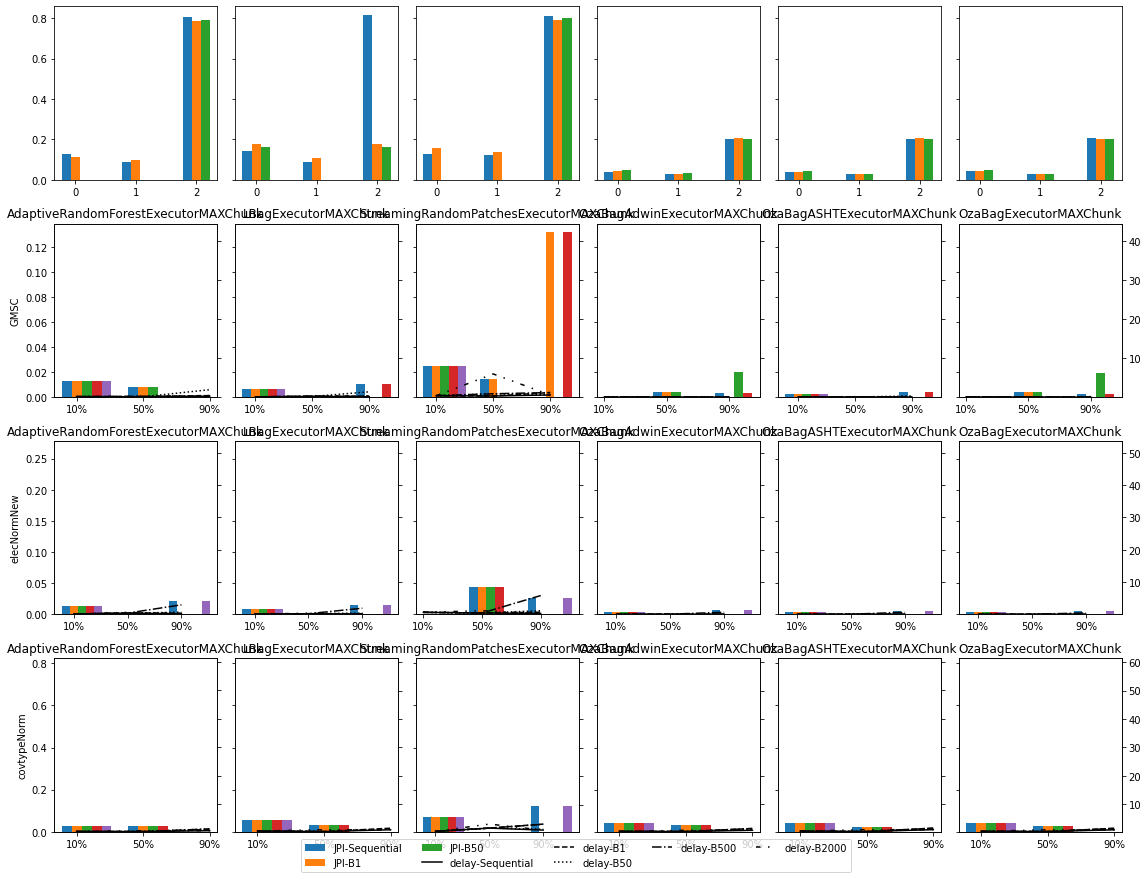

In [194]:
for f,df in zip(freqs, dataframes):
    print(f'\n\n\n----------------- {f} -----------------')
    gen_graph(df, bars=True, arch=f)




----------------- 600 -----------------


algorithm   dataset  cores  batch_size  \
0  AdaptiveRandomForestExecutorMAXChunk  airlines      4          50   
1  AdaptiveRandomForestExecutorMAXChunk  airlines      4         500   
2  AdaptiveRandomForestExecutorMAXChunk  airlines      4        2000   

   inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0         130        71.48      8,600.00  120.32    698.00         124  ...   
1         148        65.94      8,000.00  121.32  7,473.00         125  ...   
2         161        76.88     10,000.00  130.08 24,765.00         134  ...   

   delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0    757.00       125         5.57     1,236.70      69.89      8,400.00   
1  6,931.00       125         5.86     1,330.30      79.87      9,600.00   
2 25,355.00       143         5.96     1,550.00      84.87     10,200.00   

  joules_90  JPI_90  PERC  tput_90  
0    669.29    0.09    90    64.51  
1    709.62    0.08    90    70.20  
2    827.73    0.08    90    72.02  

[3 rows x 46 columns]

algorithm   dataset  cores  batch_size  inc_rate_x  out_rate_10  \
0  LBagExecutorMAXChunk  airlines      4          50         136        75.76   
1  LBagExecutorMAXChunk  airlines      4         500         153        55.56   
2  LBagExecutorMAXChunk  airlines      4        2000         164        17.23   

   instances_10  time_x   delay_10  duration_x  ...  delay_90  duration  \
0      9,200.00  121.43     659.00         127  ...    642.00       126   
1      7,000.00  125.99   8,883.00         131  ...  9,491.00       143   
2      8,000.00  464.37 114,543.00         470  ... 77,868.00       328   

   avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  JPI_90  PERC  \
0         5.63     1,288.40      74.89      9,000.00    676.43    0.08    90   
1         5.76     1,491.90      84.87     10,200.00    786.18    0.11    90   
2         5.95     3,524.80      89.86     10,800.00  1,920.78    0.24    90   

   tput_90  
0    74.86  
1    51.29  
2    24.80  

[3 rows x 46 columns]

algorithm   dataset  cores  batch_size  \
0  StreamingRandomPatchesExecutorMAXChunk  airlines      4          50   
1  StreamingRandomPatchesExecutorMAXChunk  airlines      4         500   
2  StreamingRandomPatchesExecutorMAXChunk  airlines      4        2000   

   inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0         159        59.24      7,250.00  122.39    843.00         127  ...   
1         170        56.36      7,000.00  124.21  8,768.00         128  ...   
2         144        50.55      8,000.00  158.26 37,784.00         162  ...   

   delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0    837.00       128         6.07     1,409.20      84.86     10,200.00   
1  8,932.00       132         5.72     1,372.00      89.86     10,800.00   
2 34,667.00       156         5.98     1,685.70      79.87      9,600.00   

  joules_90  JPI_90  PERC  tput_90  
0    748.83    0.10    90    59.62  
1    730.62    0.10    90    54.77  
2    903.94    0.11    90    52.90  

[3 rows x 46 columns]

algorithm   dataset  cores  batch_size  inc_rate_x  \
0  OzaBagAdwinExecutorMAXChunk  airlines      4          50         411   
1  OzaBagAdwinExecutorMAXChunk  airlines      4         500         403   
2  OzaBagAdwinExecutorMAXChunk  airlines      4        2000         554   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0       291.18     35,150.00  120.72    171.00         127  ...    196.00   
1       268.97     33,000.00  122.69  1,850.00         128  ...  2,169.00   
2       195.42     28,000.00  143.28 10,101.00         149  ...  9,800.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0       125         5.51     1,250.90     224.58     26,955.00    661.46   
1       126         5.50     1,260.30     219.59     26,356.00    659.51   
2       146         6.01     1,586.20     304.35     36,539.00    844.84   

   JPI_90  PERC  tput_90  
0    0.02    90   224.10  
1    0.03    90   219.94  
2    0.03    90   199.13  

[3 rows x 46 columns]

algorithm   dataset  cores  batch_size  inc_rate_x  \
0  OzaBagASHTExecutorMAXChunk  airlines      4          50         811   
1  OzaBagASHTExecutorMAXChunk  airlines      4         500         752   
2  OzaBagASHTExecutorMAXChunk  airlines      4        2000         831   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        92.06     11,100.00  120.57    542.00         126  ...    189.00   
1       264.63     32,000.00  120.92  1,883.00         126  ...  1,885.00   
2       255.89     32,000.00  125.05  7,737.00         134  ...  8,975.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0       126         6.26     1,426.70     448.84     53,910.00    754.29   
1       135         5.99     1,462.60     414.00     49,717.00    772.14   
2       142         6.15     1,586.00     458.88     55,108.00    841.42   

   JPI_90  PERC  tput_90  
0    0.02    90   262.98  
1    0.02    90   263.95  
2    0.03    90   219.17  

[3 rows x 46 columns]

algorithm   dataset  cores  batch_size  inc_rate_x  \
0  OzaBagExecutorMAXChunk  airlines      4          50         966   
1  OzaBagExecutorMAXChunk  airlines      4         500        1046   
2  OzaBagExecutorMAXChunk  airlines      4        2000        1019   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0       200.73     24,150.00  120.31    248.00         126  ...    263.00   
1       195.15     23,500.00  120.42  2,556.00         126  ...  2,628.00   
2       199.48     24,000.00  120.31  9,935.00         126  ... 12,683.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0       127         6.23     1,431.80     533.60     64,093.00    757.73   
1       137         5.79     1,384.90     578.48     69,484.00    764.12   
2       159         6.08     1,752.30     563.57     67,687.00    937.15   

   JPI_90  PERC  tput_90  
0    0.03    90   189.37  
1    0.03    90   189.58  
2    0.04    90   155.82  

[3 rows x 46 columns]

algorithm dataset  cores  batch_size  \
0   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
1   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
2   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
3   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
4   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
5   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
6   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
7   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
8   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
9   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
10  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
11  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
12  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
13  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
14  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
15  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
16  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
17  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
18  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
19  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
20  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
21  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
22  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
23  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
24  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
25  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
26  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
27  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
28  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
29  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
30  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
31  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
32  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
33  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
34  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
35  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
36  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
37  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
38  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
39  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
40  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
41  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
42  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
43  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
44  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
45  AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   
46  AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   
47  AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   
48  AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   
49  AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   
50  AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   
51  AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   
52  AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   

    inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0          627       623.50     74,850.00  120.05     58.00         124  ...   
1          627       623.50     74,8

algorithm dataset  cores  batch_size  inc_rate_x  out_rate_10  \
0   LBagExecutorMAXChunk    GMSC      4          50         675       673.25   
1   LBagExecutorMAXChunk    GMSC      4          50         675       673.25   
2   LBagExecutorMAXChunk    GMSC      4          50         675       673.25   
3   LBagExecutorMAXChunk    GMSC      4          50         675       673.25   
4   LBagExecutorMAXChunk    GMSC      4          50         675       673.25   
5   LBagExecutorMAXChunk    GMSC      4          50         675       673.25   
6   LBagExecutorMAXChunk    GMSC      4          50         675       673.25   
7   LBagExecutorMAXChunk    GMSC      4          50         675       673.25   
8   LBagExecutorMAXChunk    GMSC      4          50         675       673.25   
9   LBagExecutorMAXChunk    GMSC      4          50         675       673.25   
10  LBagExecutorMAXChunk    GMSC      4          50         675       673.25   
11  LBagExecutorMAXChunk    GMSC      4          50         675       673.25   
12  LBagExecutorMAXChunk    GMSC      4          50         675       673.25   
13  LBagExecutorMAXChunk    GMSC      4          50         675       673.25   
14  LBagExecutorMAXChunk    GMSC      4          50         675       673.25   
15  LBagExecutorMAXChunk    GMSC      4          50         675       673.25   
16  LBagExecutorMAXChunk    GMSC      4          50         299       294.76   
17  LBagExecutorMAXChunk    GMSC      4          50         299       294.76   
18  LBagExecutorMAXChunk    GMSC      4          50         299       294.76   
19  LBagExecutorMAXChunk    GMSC      4          50         299       294.76   
20  LBagExecutorMAXChunk    GMSC      4          50         299       294.76   
21  LBagExecutorMAXChunk    GMSC      4          50         299       294.76   
22  LBagExecutorMAXChunk    GMSC      4          50         299       294.76   
23  LBagExecutorMAXChunk    GMSC      4          50         299       294.76   
24  LBagExecutorMAXChunk    GMSC      4          50         299       294.76   
25  LBagExecutorMAXChunk    GMSC      4          50         299       294.76   
26  LBagExecutorMAXChunk    GMSC      4          50         299       294.76   
27  LBagExecutorMAXChunk    GMSC      4          50         299       294.76   
28  LBagExecutorMAXChunk    GMSC      4          50         299       294.76   
29  LBagExecutorMAXChunk    GMSC      4          50         299       294.76   
30  LBagExecutorMAXChunk    GMSC      4          50         299       294.76   
31  LBagExecutorMAXChunk    GMSC      4          50         299       294.76   
32  LBagExecutorMAXChunk    GMSC      4          50         166       164.92   
33  LBagExecutorMAXChunk    GMSC      4          50         166       164.92   
34  LBagExecutorMAXChunk    GMSC      4          50         166       164.92   
35  LBagExecutorMAXChunk    GMSC      4          50         166       164.92   
36  LBagExecutorMAXChunk    GMSC      4          50         166       164.92   
37  LBagExecutorMAXChunk    GMSC      4          50         166       164.92   
38  LBagExecutorMAXChunk    GMSC      4          50         166       164.92   
39  LBagExecutorMAXChunk    GMSC      4          50         166       164.92   
40  LBagExecutorMAXChunk    GMSC      4          50         166       164.92   
41  LBagExecutorMAXChunk    GMSC      4          50         166       164.92   
42  LBagExecutorMAXChunk    GMSC      4          50         166       164.92   
43  LBagExecutorMAXChunk    GMSC      4          50         166       164.92   
44  LBagExecutorMAXChunk    GMSC      4          50         166       164.92   
45  LBagExecutorMAXChunk    GMSC      4          50         166       164.92   
46  LBagExecutorMAXChunk    GMSC      4          50         166       164.92   
47  LBagExecutorMAXChunk    GMSC      4          50         166       164.92   
48  LBagExecutorMAXChunk    GMSC      4          50          33        30.00   
49  LBagExecuto

algorithm dataset  cores  batch_size  \
0   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
1   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
2   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
3   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
4   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
5   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
6   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
7   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
8   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
9   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
10  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
11  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
12  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
13  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
14  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
15  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
16  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
17  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
18  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
19  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
20  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
21  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
22  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
23  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
24  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
25  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
26  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
27  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
28  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
29  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
30  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
31  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
32  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
33  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
34  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
35  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
36  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
37  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
38  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
39  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
40  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
41  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
42  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
43  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
44  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
45  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
46  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
47  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
48  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
49  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
50  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
51  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   

    inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0          559       553.15     66,400.00  120.04     86.00         124  ...   
1  

algorithm dataset  cores  batch_size  inc_rate_x  \
0   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         824   
1   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         824   
2   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         824   
3   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         824   
4   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         824   
5   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         824   
6   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         824   
7   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         824   
8   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         824   
9   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         824   
10  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         824   
11  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         824   
12  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         824   
13  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         824   
14  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         824   
15  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         824   
16  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         457   
17  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         457   
18  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         457   
19  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         457   
20  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         457   
21  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         457   
22  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         457   
23  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         457   
24  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         457   
25  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         457   
26  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         457   
27  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         457   
28  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         457   
29  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         457   
30  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         457   
31  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         457   
32  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         391   
33  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         391   
34  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         391   
35  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         391   
36  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         391   
37  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         391   
38  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         391   
39  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         391   
40  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         391   
41  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         391   
42  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         391   
43  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         391   
44  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         391   
45  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         391   
46  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         391   
47  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         391   
48  OzaBagAdwinExecutorMAXChunk    GMSC      4          50          91   
49  OzaBagAdwinExecutorMAXChunk    GMSC      4          50          91   
50  OzaBagAdwinExecutorMAXChunk    GMSC      4          50          91   
51  OzaBagAdwinExecutorMAXChunk    GMSC      4          50          91   
52  OzaBagAdwinExecutorMAXChunk    GMSC      4          50          91   
53  OzaBagAdwinExecutorMAX

algorithm dataset  cores  batch_size  inc_rate_x  \
0   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1552   
1   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1552   
2   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1552   
3   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1552   
4   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1552   
5   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1552   
6   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1552   
7   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1552   
8   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1552   
9   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1552   
10  OzaBagASHTExecutorMAXChunk    GMSC      4          50        1552   
11  OzaBagASHTExecutorMAXChunk    GMSC      4          50        1552   
12  OzaBagASHTExecutorMAXChunk    GMSC      4          50        1552   
13  OzaBagASHTExecutorMAXChunk    GMSC      4          50        1552   
14  OzaBagASHTExecutorMAXChunk    GMSC      4          50        1552   
15  OzaBagASHTExecutorMAXChunk    GMSC      4          50        1552   
16  OzaBagASHTExecutorMAXChunk    GMSC      4          50         862   
17  OzaBagASHTExecutorMAXChunk    GMSC      4          50         862   
18  OzaBagASHTExecutorMAXChunk    GMSC      4          50         862   
19  OzaBagASHTExecutorMAXChunk    GMSC      4          50         862   
20  OzaBagASHTExecutorMAXChunk    GMSC      4          50         862   
21  OzaBagASHTExecutorMAXChunk    GMSC      4          50         862   
22  OzaBagASHTExecutorMAXChunk    GMSC      4          50         862   
23  OzaBagASHTExecutorMAXChunk    GMSC      4          50         862   
24  OzaBagASHTExecutorMAXChunk    GMSC      4          50         862   
25  OzaBagASHTExecutorMAXChunk    GMSC      4          50         862   
26  OzaBagASHTExecutorMAXChunk    GMSC      4          50         862   
27  OzaBagASHTExecutorMAXChunk    GMSC      4          50         862   
28  OzaBagASHTExecutorMAXChunk    GMSC      4          50         862   
29  OzaBagASHTExecutorMAXChunk    GMSC      4          50         862   
30  OzaBagASHTExecutorMAXChunk    GMSC      4          50         862   
31  OzaBagASHTExecutorMAXChunk    GMSC      4          50         862   
32  OzaBagASHTExecutorMAXChunk    GMSC      4          50         172   
33  OzaBagASHTExecutorMAXChunk    GMSC      4          50         172   
34  OzaBagASHTExecutorMAXChunk    GMSC      4          50         172   
35  OzaBagASHTExecutorMAXChunk    GMSC      4          50         172   
36  OzaBagASHTExecutorMAXChunk    GMSC      4          50         172   
37  OzaBagASHTExecutorMAXChunk    GMSC      4          50         172   
38  OzaBagASHTExecutorMAXChunk    GMSC      4          50         172   
39  OzaBagASHTExecutorMAXChunk    GMSC      4          50         172   
40  OzaBagASHTExecutorMAXChunk    GMSC      4          50         172   
41  OzaBagASHTExecutorMAXChunk    GMSC      4          50         172   
42  OzaBagASHTExecutorMAXChunk    GMSC      4          50         172   
43  OzaBagASHTExecutorMAXChunk    GMSC      4          50         172   
44  OzaBagASHTExecutorMAXChunk    GMSC      4          50         172   
45  OzaBagASHTExecutorMAXChunk    GMSC      4          50         172   
46  OzaBagASHTExecutorMAXChunk    GMSC      4          50         172   
47  OzaBagASHTExecutorMAXChunk    GMSC      4          50         172   
48  OzaBagASHTExecutorMAXChunk    GMSC      4         500        1552   
49  OzaBagASHTExecutorMAXChunk    GMSC      4         500        1552   
50  OzaBagASHTExecutorMAXChunk    GMSC      4         500        1552   
51  OzaBagASHTExecutorMAXChunk    GMSC      4         500        1552   
52  OzaBagASHTExecutorMAXChunk    GMSC      4         500         172   
53  OzaBagASHTExecutorMAXChunk    GMSC      4         500         172   
54  Oz

algorithm dataset  cores  batch_size  inc_rate_x  \
0   OzaBagExecutorMAXChunk    GMSC      4          50        1019   
1   OzaBagExecutorMAXChunk    GMSC      4          50        1019   
2   OzaBagExecutorMAXChunk    GMSC      4          50        1019   
3   OzaBagExecutorMAXChunk    GMSC      4          50        1019   
4   OzaBagExecutorMAXChunk    GMSC      4          50        1019   
5   OzaBagExecutorMAXChunk    GMSC      4          50        1019   
6   OzaBagExecutorMAXChunk    GMSC      4          50        1019   
7   OzaBagExecutorMAXChunk    GMSC      4          50        1019   
8   OzaBagExecutorMAXChunk    GMSC      4          50        1019   
9   OzaBagExecutorMAXChunk    GMSC      4          50        1019   
10  OzaBagExecutorMAXChunk    GMSC      4          50        1019   
11  OzaBagExecutorMAXChunk    GMSC      4          50        1019   
12  OzaBagExecutorMAXChunk    GMSC      4          50        1019   
13  OzaBagExecutorMAXChunk    GMSC      4          50        1019   
14  OzaBagExecutorMAXChunk    GMSC      4          50        1019   
15  OzaBagExecutorMAXChunk    GMSC      4          50        1019   
16  OzaBagExecutorMAXChunk    GMSC      4          50         566   
17  OzaBagExecutorMAXChunk    GMSC      4          50         566   
18  OzaBagExecutorMAXChunk    GMSC      4          50         566   
19  OzaBagExecutorMAXChunk    GMSC      4          50         566   
20  OzaBagExecutorMAXChunk    GMSC      4          50         566   
21  OzaBagExecutorMAXChunk    GMSC      4          50         566   
22  OzaBagExecutorMAXChunk    GMSC      4          50         566   
23  OzaBagExecutorMAXChunk    GMSC      4          50         566   
24  OzaBagExecutorMAXChunk    GMSC      4          50         566   
25  OzaBagExecutorMAXChunk    GMSC      4          50         566   
26  OzaBagExecutorMAXChunk    GMSC      4          50         566   
27  OzaBagExecutorMAXChunk    GMSC      4          50         566   
28  OzaBagExecutorMAXChunk    GMSC      4          50         566   
29  OzaBagExecutorMAXChunk    GMSC      4          50         566   
30  OzaBagExecutorMAXChunk    GMSC      4          50         566   
31  OzaBagExecutorMAXChunk    GMSC      4          50         566   
32  OzaBagExecutorMAXChunk    GMSC      4          50         393   
33  OzaBagExecutorMAXChunk    GMSC      4          50         393   
34  OzaBagExecutorMAXChunk    GMSC      4          50         393   
35  OzaBagExecutorMAXChunk    GMSC      4          50         393   
36  OzaBagExecutorMAXChunk    GMSC      4          50         393   
37  OzaBagExecutorMAXChunk    GMSC      4          50         393   
38  OzaBagExecutorMAXChunk    GMSC      4          50         393   
39  OzaBagExecutorMAXChunk    GMSC      4          50         393   
40  OzaBagExecutorMAXChunk    GMSC      4          50         393   
41  OzaBagExecutorMAXChunk    GMSC      4          50         393   
42  OzaBagExecutorMAXChunk    GMSC      4          50         393   
43  OzaBagExecutorMAXChunk    GMSC      4          50         393   
44  OzaBagExecutorMAXChunk    GMSC      4          50         393   
45  OzaBagExecutorMAXChunk    GMSC      4          50         393   
46  OzaBagExecutorMAXChunk    GMSC      4          50         393   
47  OzaBagExecutorMAXChunk    GMSC      4          50         393   
48  OzaBagExecutorMAXChunk    GMSC      4          50         113   
49  OzaBagExecutorMAXChunk    GMSC      4          50         113   
50  OzaBagExecutorMAXChunk    GMSC      4          50         113   
51  OzaBagExecutorMAXChunk    GMSC      4          50         113   
52  OzaBagExecutorMAXChunk    GMSC      4          50         113   
53  OzaBagExecutorMAXChunk    GMSC      4          50         113   
54  OzaBagExecutorMAXChunk    GMSC      4          50         113   
55  OzaBagExecutorMAXChunk    GMSC      4          50         113   
56  OzaBagExecutorMAXChunk    GMSC      4          50         113   
57  OzaBagExecu

algorithm      dataset  cores  batch_size  \
0    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
1    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
2    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
3    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
4    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
5    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
6    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
7    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
8    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
9    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
10   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
11   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
12   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
13   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
14   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
15   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
16   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
17   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
18   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
19   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
20   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
21   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
22   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
23   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
24   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
25   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
26   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
27   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
28   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
29   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
30   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
31   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
32   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
33   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
34   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
35   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
36   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
37   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
38   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
39   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
40   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
41   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
42   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
43   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
44   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
45   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
46   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
47   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
48   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
49   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
50   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
51   AdaptiveRandomForestExe

algorithm      dataset  cores  batch_size  inc_rate_x  \
0   LBagExecutorMAXChunk  elecNormNew      4          50        1029   
1   LBagExecutorMAXChunk  elecNormNew      4          50        1029   
2   LBagExecutorMAXChunk  elecNormNew      4          50        1029   
3   LBagExecutorMAXChunk  elecNormNew      4          50        1029   
4   LBagExecutorMAXChunk  elecNormNew      4          50        1029   
5   LBagExecutorMAXChunk  elecNormNew      4          50        1029   
6   LBagExecutorMAXChunk  elecNormNew      4          50        1029   
7   LBagExecutorMAXChunk  elecNormNew      4          50        1029   
8   LBagExecutorMAXChunk  elecNormNew      4          50        1029   
9   LBagExecutorMAXChunk  elecNormNew      4          50        1029   
10  LBagExecutorMAXChunk  elecNormNew      4          50        1029   
11  LBagExecutorMAXChunk  elecNormNew      4          50        1029   
12  LBagExecutorMAXChunk  elecNormNew      4          50         303   
13  LBagExecutorMAXChunk  elecNormNew      4          50         303   
14  LBagExecutorMAXChunk  elecNormNew      4          50         303   
15  LBagExecutorMAXChunk  elecNormNew      4          50         303   
16  LBagExecutorMAXChunk  elecNormNew      4          50         303   
17  LBagExecutorMAXChunk  elecNormNew      4          50         303   
18  LBagExecutorMAXChunk  elecNormNew      4          50         303   
19  LBagExecutorMAXChunk  elecNormNew      4          50         303   
20  LBagExecutorMAXChunk  elecNormNew      4          50         303   
21  LBagExecutorMAXChunk  elecNormNew      4          50         303   
22  LBagExecutorMAXChunk  elecNormNew      4          50         303   
23  LBagExecutorMAXChunk  elecNormNew      4          50         303   
24  LBagExecutorMAXChunk  elecNormNew      4          50         168   
25  LBagExecutorMAXChunk  elecNormNew      4          50         168   
26  LBagExecutorMAXChunk  elecNormNew      4          50         168   
27  LBagExecutorMAXChunk  elecNormNew      4          50         168   
28  LBagExecutorMAXChunk  elecNormNew      4          50         168   
29  LBagExecutorMAXChunk  elecNormNew      4          50         168   
30  LBagExecutorMAXChunk  elecNormNew      4          50         168   
31  LBagExecutorMAXChunk  elecNormNew      4          50         168   
32  LBagExecutorMAXChunk  elecNormNew      4          50         168   
33  LBagExecutorMAXChunk  elecNormNew      4          50         168   
34  LBagExecutorMAXChunk  elecNormNew      4          50         168   
35  LBagExecutorMAXChunk  elecNormNew      4          50         168   
36  LBagExecutorMAXChunk  elecNormNew      4          50          33   
37  LBagExecutorMAXChunk  elecNormNew      4          50          33   
38  LBagExecutorMAXChunk  elecNormNew      4          50          33   
39  LBagExecutorMAXChunk  elecNormNew      4          50          33   
40  LBagExecutorMAXChunk  elecNormNew      4          50          33   
41  LBagExecutorMAXChunk  elecNormNew      4          50          33   
42  LBagExecutorMAXChunk  elecNormNew      4          50          33   
43  LBagExecutorMAXChunk  elecNormNew      4          50          33   
44  LBagExecutorMAXChunk  elecNormNew      4          50          33   
45  LBagExecutorMAXChunk  elecNormNew      4          50          33   
46  LBagExecutorMAXChunk  elecNormNew      4          50          33   
47  LBagExecutorMAXChunk  elecNormNew      4          50          33   
48  LBagExecutorMAXChunk  elecNormNew      4         500        1186   
49  LBagExecutorMAXChunk  elecNormNew      4         500        1186   
50  LBagExecutorMAXChunk  elecNormNew      4         500        1186   
51  LBagExecutorMAXChunk  elecNormNew      4         500        1186   
52  LBagExecutorMAXChunk  elecNormNew      4         500         168   
53  LBagExecutorMAXChunk  elecNormNew      4         500         168   
54  LBagExecutorMAXChunk  elecNormNew      4         50

algorithm      dataset  cores  batch_size  \
0   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
1   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
2   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
3   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
4   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
5   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
6   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
7   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
8   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
9   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
10  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
11  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
12  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
13  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
14  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
15  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
16  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
17  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
18  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
19  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
20  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
21  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
22  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
23  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
24  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
25  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
26  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
27  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
28  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
29  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
30  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
31  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
32  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
33  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   

    inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0           42        39.98      4,800.00  120.07    715.00         123  ...   
1           42        39.98      4,800.00  120.07    715.00         123  ...   
2           42        39.98      4,800.00  120.07    715.00         123  ...   
3           42        39.98      4,800.00  120.07    715.00         123  ...   
4           42        39.98      4,800.00  120.07    715.00         123  ...   
5           42        39.98      4,800.00  120.07    715.00         123  ...   
6           42        39.98      4,800.00  120.07    715.00         123  ...   
7           42        39.98      4,800.00  120.07    715.00         123  ...   
8           42        39.98      4,800.00  120.07    715.00         123  ...   
9           23        19.99      2,400.00  120.04  1,365.00         124  ...   
10          23        19.99      2,400.00  120.04  1,365.00         124  ...   
11          23        19.99      2,400.00  120.04  1,365.00         124  ...   
12          23        19.99      2,400.00  120.04  1,365.00         124  ...   
13          23        19.99      2,400.00  120.04  1,365.00         124  ...   
14          23        19.99      2,400.00  120.04  1,365.00         124  ...   
15          23        

algorithm      dataset  cores  batch_size  inc_rate_x  \
0   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        2029   
1   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        2029   
2   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        2029   
3   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        2029   
4   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        2029   
5   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        2029   
6   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        2029   
7   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        2029   
8   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        2029   
9   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         668   
10  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         668   
11  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         668   
12  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         668   
13  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         668   
14  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         668   
15  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         668   
16  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         668   
17  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         668   
18  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         225   
19  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         225   
20  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         225   
21  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         225   
22  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         225   
23  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         225   
24  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         225   
25  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         225   
26  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         225   
27  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500        2335   
28  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500        2335   
29  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500        2335   
30  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500        2335   
31  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500         371   
32  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500         371   
33  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500         371   
34  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500         371   
35  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000        2196   
36  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000        2196   
37  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000        2196   
38  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000        2196   
39  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         371   
40  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         371   
41  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         371   
42  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         371   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0      1,857.39     43,242.00   23.28     26.00          29  ...     29.00   
1      1,857.39     43,242.00   23.28     26.00          29  ...     78.00   
2      1,857.39     43,242.00   23.28     26.00          29  ...    371.00   
3      1,857.39     43,242.00   23.28     26.00          29  ...     29.00   
4      1,857.39     43,242.00   23.28     26.00          29  ...     78.00   
5      1,857.39     43,242.00   23.28     26.00          29  ...    371.00   

algorithm      dataset  cores  batch_size  inc_rate_x  \
0   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        2357   
1   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        2357   
2   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        2357   
3   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        2357   
4   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        2357   
5   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        2357   
6   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        2357   
7   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        2357   
8   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        2357   
9   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         320   
10  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         320   
11  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         320   
12  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         320   
13  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         320   
14  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         320   
15  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         320   
16  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         320   
17  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         320   
18  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         178   
19  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         178   
20  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         178   
21  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         178   
22  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         178   
23  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         178   
24  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         178   
25  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         178   
26  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         178   
27  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500        2689   
28  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500        2689   
29  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500        2689   
30  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500        2689   
31  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500         298   
32  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500         298   
33  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500         298   
34  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500         298   
35  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000        2541   
36  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000        2541   
37  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000        2541   
38  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000        2541   
39  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000         282   
40  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000         282   
41  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000         282   
42  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000         282   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0      2,013.30     43,300.00   21.51     24.00          26  ...     29.00   
1      2,013.30     43,300.00   21.51     24.00          26  ...    103.00   
2      2,013.30     43,300.00   21.51     24.00          26  ...    733.00   
3      2,013.30     43,300.00   21.51     24.00          26  ...     29.00   
4      2,013.30     43,300.00   21.51     24.00          26  ...    103.00   
5      2,013.30     43,300.00   21.51     24.00          26  ...    733.00   
6      2,013.30     43,300.00   21.51     

algorithm      dataset  cores  batch_size  inc_rate_x  \
0   OzaBagExecutorMAXChunk  elecNormNew      4          50        2459   
1   OzaBagExecutorMAXChunk  elecNormNew      4          50        2459   
2   OzaBagExecutorMAXChunk  elecNormNew      4          50        2459   
3   OzaBagExecutorMAXChunk  elecNormNew      4          50        2459   
4   OzaBagExecutorMAXChunk  elecNormNew      4          50        2459   
5   OzaBagExecutorMAXChunk  elecNormNew      4          50        2459   
6   OzaBagExecutorMAXChunk  elecNormNew      4          50        2459   
7   OzaBagExecutorMAXChunk  elecNormNew      4          50        2459   
8   OzaBagExecutorMAXChunk  elecNormNew      4          50        2459   
9   OzaBagExecutorMAXChunk  elecNormNew      4          50         852   
10  OzaBagExecutorMAXChunk  elecNormNew      4          50         852   
11  OzaBagExecutorMAXChunk  elecNormNew      4          50         852   
12  OzaBagExecutorMAXChunk  elecNormNew      4          50         852   
13  OzaBagExecutorMAXChunk  elecNormNew      4          50         852   
14  OzaBagExecutorMAXChunk  elecNormNew      4          50         852   
15  OzaBagExecutorMAXChunk  elecNormNew      4          50         852   
16  OzaBagExecutorMAXChunk  elecNormNew      4          50         852   
17  OzaBagExecutorMAXChunk  elecNormNew      4          50         852   
18  OzaBagExecutorMAXChunk  elecNormNew      4          50         273   
19  OzaBagExecutorMAXChunk  elecNormNew      4          50         273   
20  OzaBagExecutorMAXChunk  elecNormNew      4          50         273   
21  OzaBagExecutorMAXChunk  elecNormNew      4          50         273   
22  OzaBagExecutorMAXChunk  elecNormNew      4          50         273   
23  OzaBagExecutorMAXChunk  elecNormNew      4          50         273   
24  OzaBagExecutorMAXChunk  elecNormNew      4          50         273   
25  OzaBagExecutorMAXChunk  elecNormNew      4          50         273   
26  OzaBagExecutorMAXChunk  elecNormNew      4          50         273   
27  OzaBagExecutorMAXChunk  elecNormNew      4         500        2632   
28  OzaBagExecutorMAXChunk  elecNormNew      4         500        2632   
29  OzaBagExecutorMAXChunk  elecNormNew      4         500        2632   
30  OzaBagExecutorMAXChunk  elecNormNew      4         500        2632   
31  OzaBagExecutorMAXChunk  elecNormNew      4         500         473   
32  OzaBagExecutorMAXChunk  elecNormNew      4         500         473   
33  OzaBagExecutorMAXChunk  elecNormNew      4         500         473   
34  OzaBagExecutorMAXChunk  elecNormNew      4         500         473   
35  OzaBagExecutorMAXChunk  elecNormNew      4        2000        2515   
36  OzaBagExecutorMAXChunk  elecNormNew      4        2000        2515   
37  OzaBagExecutorMAXChunk  elecNormNew      4        2000        2515   
38  OzaBagExecutorMAXChunk  elecNormNew      4        2000        2515   
39  OzaBagExecutorMAXChunk  elecNormNew      4        2000         473   
40  OzaBagExecutorMAXChunk  elecNormNew      4        2000         473   
41  OzaBagExecutorMAXChunk  elecNormNew      4        2000         473   
42  OzaBagExecutorMAXChunk  elecNormNew      4        2000         473   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0      2,316.43     42,884.00   18.51     21.00          24  ...     28.00   
1      2,316.43     42,884.00   18.51     21.00          24  ...     61.00   
2      2,316.43     42,884.00   18.51     21.00          24  ...    287.00   
3      2,316.43     42,884.00   18.51     21.00          24  ...     28.00   
4      2,316.43     42,884.00   18.51     21.00          24  ...     61.00   
5      2,316.43     42,884.00   18.51     21.00          24  ...    287.00   
6      2,316.43     42,884.00   18.51     21.00          24  ...     28.00   
7      2,316.43     42,884.00   18.51     21.00          24  ...     61.00   
8      2,316.43     42,884.00   18.51     21.00          2

algorithm      dataset  cores  batch_size  \
0   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
1   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
2   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
3   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
4   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
5   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
6   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
7   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
8   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
9   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
10  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
11  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
12  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
13  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
14  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
15  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
16  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
17  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
18  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
19  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
20  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
21  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
22  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
23  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
24  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
25  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
26  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
27  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
28  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
29  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
30  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
31  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
32  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
33  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   

    inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0           96        94.84     11,382.00  120.01    371.00         124  ...   
1           96        94.84     11,382.00  120.01    371.00         124  ...   
2           96        94.84     11,382.00  120.01    371.00         124  ...   
3           96        94.84     11,382.00  120.01    371.00         124  ...   
4           96        94.84     11,382.00  120.01    371.00         124  ...   
5           96        94.84     11,382.00  120.01    371.00         124  ...   
6           96        94.84     11,382.00  120.01    371.00         124  ...   
7           96        94.84     11,382.00  120.01    371.00         124  ...   
8           96        94.84     11,382.00  120.01    371.00         124  ...   
9           53        49.95      6,000.00  120.12    531.00         125  ...   
10          53        49.95      6,000.00  120.12    531.00         125  ...   
11          53        49.95      6,000.00  120.12    531.00         125  ...   
12          53        49.95      6,000.00  120.12    531.00         125  ...   
13          53        49.95      6,000.00  120.12    531.00         125  ...   
14          53        49.95      6,000.00  120.12    531.00         125  ...   
15          53        49.95      6,000.00  120.12    531.00         125  ...   
16        

algorithm      dataset  cores  batch_size  inc_rate_x  \
0   LBagExecutorMAXChunk  covtypeNorm      4          50          63   
1   LBagExecutorMAXChunk  covtypeNorm      4          50          63   
2   LBagExecutorMAXChunk  covtypeNorm      4          50          63   
3   LBagExecutorMAXChunk  covtypeNorm      4          50          63   
4   LBagExecutorMAXChunk  covtypeNorm      4          50          63   
5   LBagExecutorMAXChunk  covtypeNorm      4          50          63   
6   LBagExecutorMAXChunk  covtypeNorm      4          50          63   
7   LBagExecutorMAXChunk  covtypeNorm      4          50          63   
8   LBagExecutorMAXChunk  covtypeNorm      4          50          63   
9   LBagExecutorMAXChunk  covtypeNorm      4          50          35   
10  LBagExecutorMAXChunk  covtypeNorm      4          50          35   
11  LBagExecutorMAXChunk  covtypeNorm      4          50          35   
12  LBagExecutorMAXChunk  covtypeNorm      4          50          35   
13  LBagExecutorMAXChunk  covtypeNorm      4          50          35   
14  LBagExecutorMAXChunk  covtypeNorm      4          50          35   
15  LBagExecutorMAXChunk  covtypeNorm      4          50          35   
16  LBagExecutorMAXChunk  covtypeNorm      4          50          35   
17  LBagExecutorMAXChunk  covtypeNorm      4          50          35   
18  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
19  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
20  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
21  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
22  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
23  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
24  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
25  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
26  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
27  LBagExecutorMAXChunk  covtypeNorm      4         500          63   
28  LBagExecutorMAXChunk  covtypeNorm      4         500          63   
29  LBagExecutorMAXChunk  covtypeNorm      4         500          63   
30  LBagExecutorMAXChunk  covtypeNorm      4         500          63   
31  LBagExecutorMAXChunk  covtypeNorm      4         500           7   
32  LBagExecutorMAXChunk  covtypeNorm      4         500           7   
33  LBagExecutorMAXChunk  covtypeNorm      4         500           7   
34  LBagExecutorMAXChunk  covtypeNorm      4         500           7   
35  LBagExecutorMAXChunk  covtypeNorm      4        2000          63   
36  LBagExecutorMAXChunk  covtypeNorm      4        2000          63   
37  LBagExecutorMAXChunk  covtypeNorm      4        2000          63   
38  LBagExecutorMAXChunk  covtypeNorm      4        2000          63   
39  LBagExecutorMAXChunk  covtypeNorm      4        2000           7   
40  LBagExecutorMAXChunk  covtypeNorm      4        2000           7   
41  LBagExecutorMAXChunk  covtypeNorm      4        2000           7   
42  LBagExecutorMAXChunk  covtypeNorm      4        2000           7   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0         59.88      7,200.00  120.24    559.00         125  ...    121.00   
1         59.88      7,200.00  120.24    559.00         125  ...    559.00   
2         59.88      7,200.00  120.24    559.00         125  ...    867.00   
3         59.88      7,200.00  120.24    559.00         125  ...    121.00   
4         59.88      7,200.00  120.24    559.00         125  ...    559.00   
5         59.88      7,200.00  120.24    559.00         125  ...    867.00   
6         59.88      7,200.00  120.24    559.00         125  ...    121.00   
7         59.88      7,200.00  120.24    559.00         125  ...    559.00   
8         59.88      7,200.00  120.24    559.00         125  ...    867.00   
9         34.96      4,200.00  120.14    867.00         126  ...  

algorithm      dataset  cores  batch_size  \
0   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
1   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
2   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
3   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
4   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
5   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
6   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
7   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
8   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
9   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
10  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
11  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
12  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
13  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
14  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
15  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
16  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
17  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
18  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
19  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
20  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
21  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
22  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
23  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
24  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
25  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
26  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
27  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
28  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
29  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
30  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
31  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
32  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
33  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
34  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
35  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
36  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
37  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
38  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
39  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
40  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
41  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
42  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   

    inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0           37        34.95      4,200.00  120.16    940.00         124  ...   
1           37        34.95      4,200.00  120.16    940.00         124  ...   
2           37        34.95      4,200.00  120.16    940.00         124  ...   
3           37        34.95      4,200.00  120.16    940.00         124  ...   
4           37        34.95      4,200.00  120.16    940.00         124  ...   
5           37        34.95      4,200.00  120.16    940.00         124  ...   
6           37        34.95      4,200.0

algorithm      dataset  cores  batch_size  inc_rate_x  \
0   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          72   
1   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          72   
2   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          72   
3   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          72   
4   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          72   
5   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          72   
6   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          72   
7   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          72   
8   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          72   
9   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          40   
10  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          40   
11  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          40   
12  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          40   
13  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          40   
14  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          40   
15  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          40   
16  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          40   
17  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          40   
18  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           8   
19  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           8   
20  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           8   
21  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           8   
22  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           8   
23  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           8   
24  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           8   
25  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           8   
26  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           8   
27  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          76   
28  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          76   
29  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          76   
30  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          76   
31  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           8   
32  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           8   
33  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           8   
34  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           8   
35  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4        2000          72   
36  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4        2000          72   
37  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4        2000          72   
38  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4        2000          72   
39  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4        2000           8   
40  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4        2000           8   
41  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4        2000           8   
42  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4        2000           8   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0         69.94      8,400.00  120.11    502.00         125  ...     89.00   
1         69.94      8,400.00  120.11    502.00         125  ...    502.00   
2         69.94      8,400.00  120.11    502.00         125  ...    775.00   
3         69.94      8,400.00  120.11    502.00         125  ...     89.00   
4         69.94      8,400.00  120.11    502.00         125  ...    502.00   
5         69.94      8,400.00  120.11    502.00         125  ...    775.00   

algorithm      dataset  cores  batch_size  inc_rate_x  \
0   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          70   
1   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          70   
2   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          70   
3   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          70   
4   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          70   
5   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          70   
6   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          70   
7   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          70   
8   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          70   
9   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          33   
10  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          33   
11  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          33   
12  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          33   
13  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          33   
14  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          33   
15  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          33   
16  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          33   
17  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          33   
18  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           6   
19  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           6   
20  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           6   
21  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           6   
22  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           6   
23  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           6   
24  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           6   
25  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           6   
26  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           6   
27  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500          79   
28  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500          79   
29  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500          79   
30  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500          79   
31  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500           6   
32  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500           6   
33  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500           6   
34  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500           6   
35  OzaBagASHTExecutorMAXChunk  covtypeNorm      4        2000          73   
36  OzaBagASHTExecutorMAXChunk  covtypeNorm      4        2000          73   
37  OzaBagASHTExecutorMAXChunk  covtypeNorm      4        2000          73   
38  OzaBagASHTExecutorMAXChunk  covtypeNorm      4        2000          73   
39  OzaBagASHTExecutorMAXChunk  covtypeNorm      4        2000           6   
40  OzaBagASHTExecutorMAXChunk  covtypeNorm      4        2000           6   
41  OzaBagASHTExecutorMAXChunk  covtypeNorm      4        2000           6   
42  OzaBagASHTExecutorMAXChunk  covtypeNorm      4        2000           6   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0         69.89      8,387.00  120.00    484.00         126  ...     79.00   
1         69.89      8,387.00  120.00    484.00         126  ...    549.00   
2         69.89      8,387.00  120.00    484.00         126  ...    908.00   
3         69.89      8,387.00  120.00    484.00         126  ...     79.00   
4         69.89      8,387.00  120.00    484.00         126  ...    549.00   
5         69.89      8,387.00  120.00    484.00         126  ...    908.00   
6         69.89      8,387.00  120.00    4

algorithm      dataset  cores  batch_size  inc_rate_x  \
0   OzaBagExecutorMAXChunk  covtypeNorm      4          50          81   
1   OzaBagExecutorMAXChunk  covtypeNorm      4          50          81   
2   OzaBagExecutorMAXChunk  covtypeNorm      4          50          81   
3   OzaBagExecutorMAXChunk  covtypeNorm      4          50          81   
4   OzaBagExecutorMAXChunk  covtypeNorm      4          50          81   
5   OzaBagExecutorMAXChunk  covtypeNorm      4          50          81   
6   OzaBagExecutorMAXChunk  covtypeNorm      4          50          81   
7   OzaBagExecutorMAXChunk  covtypeNorm      4          50          81   
8   OzaBagExecutorMAXChunk  covtypeNorm      4          50          81   
9   OzaBagExecutorMAXChunk  covtypeNorm      4          50          45   
10  OzaBagExecutorMAXChunk  covtypeNorm      4          50          45   
11  OzaBagExecutorMAXChunk  covtypeNorm      4          50          45   
12  OzaBagExecutorMAXChunk  covtypeNorm      4          50          45   
13  OzaBagExecutorMAXChunk  covtypeNorm      4          50          45   
14  OzaBagExecutorMAXChunk  covtypeNorm      4          50          45   
15  OzaBagExecutorMAXChunk  covtypeNorm      4          50          45   
16  OzaBagExecutorMAXChunk  covtypeNorm      4          50          45   
17  OzaBagExecutorMAXChunk  covtypeNorm      4          50          45   
18  OzaBagExecutorMAXChunk  covtypeNorm      4          50           9   
19  OzaBagExecutorMAXChunk  covtypeNorm      4          50           9   
20  OzaBagExecutorMAXChunk  covtypeNorm      4          50           9   
21  OzaBagExecutorMAXChunk  covtypeNorm      4          50           9   
22  OzaBagExecutorMAXChunk  covtypeNorm      4          50           9   
23  OzaBagExecutorMAXChunk  covtypeNorm      4          50           9   
24  OzaBagExecutorMAXChunk  covtypeNorm      4          50           9   
25  OzaBagExecutorMAXChunk  covtypeNorm      4          50           9   
26  OzaBagExecutorMAXChunk  covtypeNorm      4          50           9   
27  OzaBagExecutorMAXChunk  covtypeNorm      4         500          81   
28  OzaBagExecutorMAXChunk  covtypeNorm      4         500          81   
29  OzaBagExecutorMAXChunk  covtypeNorm      4         500          81   
30  OzaBagExecutorMAXChunk  covtypeNorm      4         500          81   
31  OzaBagExecutorMAXChunk  covtypeNorm      4         500           9   
32  OzaBagExecutorMAXChunk  covtypeNorm      4         500           9   
33  OzaBagExecutorMAXChunk  covtypeNorm      4         500           9   
34  OzaBagExecutorMAXChunk  covtypeNorm      4         500           9   
35  OzaBagExecutorMAXChunk  covtypeNorm      4        2000          81   
36  OzaBagExecutorMAXChunk  covtypeNorm      4        2000          81   
37  OzaBagExecutorMAXChunk  covtypeNorm      4        2000          81   
38  OzaBagExecutorMAXChunk  covtypeNorm      4        2000          81   
39  OzaBagExecutorMAXChunk  covtypeNorm      4        2000           9   
40  OzaBagExecutorMAXChunk  covtypeNorm      4        2000           9   
41  OzaBagExecutorMAXChunk  covtypeNorm      4        2000           9   
42  OzaBagExecutorMAXChunk  covtypeNorm      4        2000           9   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0         79.99      9,584.00  119.82    440.00         126  ...     80.00   
1         79.99      9,584.00  119.82    440.00         126  ...    440.00   
2         79.99      9,584.00  119.82    440.00         126  ...    688.00   
3         79.99      9,584.00  119.82    440.00         126  ...     80.00   
4         79.99      9,584.00  119.82    440.00         126  ...    440.00   
5         79.99      9,584.00  119.82    440.00         126  ...    688.00   
6         79.99      9,584.00  119.82    440.00         126  ...     80.00   
7         79.99      9,584.00  119.82    440.00         126  ...    440.00   
8         79.99      9,584.00  119.82    440.00         12

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


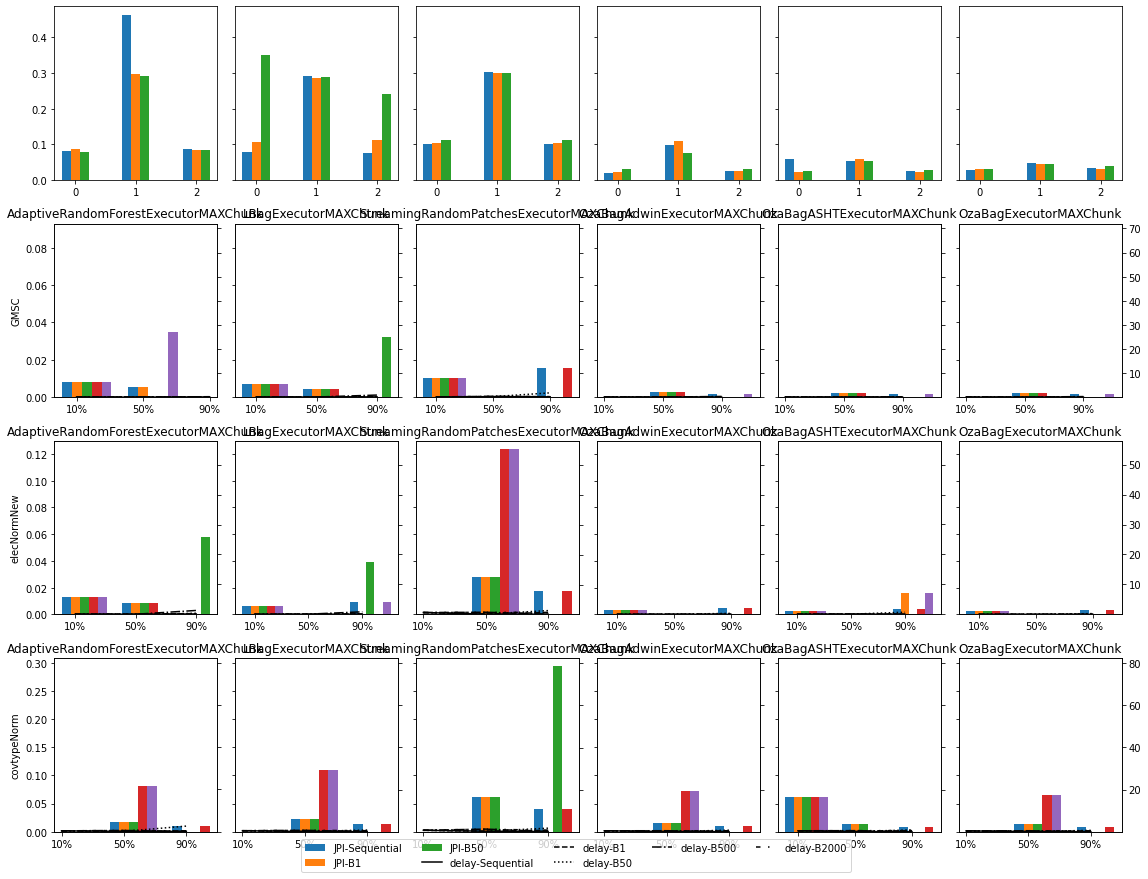

In [190]:
freqs = ['600', '1200']
for freq, df in zip(freqs,dataframes):
    print(f'\n\n\n----------------- {freq} -----------------')
    gen_graph(df, bars=True, arch=freq.title())

In [122]:
def aux2_tput(df, ax, mTput, legend=False, title=False, ylabels=False, ds='', bar=False, share_y=False, log_y=False, norm=False, hide=True):
    if norm:
        df = my_norm(df, x=norm)
    global rate
    width = 0.15
    alg_order = ['Sequential', 'B1', 'B50', 'B500', 'B2000']
    labels = ['10%', '50%', '90%']
    line_format = ['-', '--', ':', '-.', (0, (3, 5, 1, 5, 1, 5))]
    linfo = '--'
    x = np.arange(len(labels))
    lns_l = []
    versions = len(alg_order)

    for i in range(versions):
        try:
            adf = df.iloc[i]
            values = [adf.tput_10, adf.tput_50, adf.tput_90]
            if bar:
                lns_l += ax.bar(x - ((1 - i) * width), values, width, label=f'Tput-{alg_order[i]}')
            else:
                lns_l += ax.plot(x, values, label=f'Tput-{alg_order[i]}')
        except IndexError:
            return None

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    if log_y:
        ax.set_yscale('log')
    if title:
        alg_title = re.sub('Sequential', '', df.algorithm.iloc[0])
        ax.set_title(f'{alg_title}')
    if ylabels:
        ax.set_ylabel(ds)
    if last:
        ax.set_ymargin(2)
    labs = [l.get_label() for l in lns_l]
    if legend:
        ax.legend(lns_l, labs, loc=0)
    if share_y == 'row':
        ax.set_ylim(bottom=0, top=mTput)

In [123]:
def aux_tput(ds, axis, id_ds, df, bar=False, share_y='row', log_y=False, norm=False):
    rates = ['10', '50', '90']
    algs = ['Ada', 'L', 'Patches', 'Adwin', 'ASHT', 'OzaBag']
    global title
    global labels
    hide_axis = True
#     get max value from delay for all rates on all algorithms for this dataset
    mLstTput = []
    if share_y == 'row':
        for rt in rates:
            rtDF = df[df.PERC == rt]
            mLstTput.append(rtDF.tput.max())
        mTput = max(mLstTput)*1.05
    else:
        mTput = 0
    for alg in algs:
        dsalgdf = filter_by_substring_algorithm(df, alg).sort_values(['algorithm','batch_size','cores'])
        for rt in rates:
            if rt == '10':
                showdf = rename_columns_by_rate(dsalgdf[dsalgdf.PERC == rt])
            else:
                to_join = dsalgdf[dsalgdf.PERC == rt]
                showdf = showdf.merge(rename_columns_by_rate(to_join),
                                  on=['algorithm', 'dataset', 'batch_size', 'cores']).sort_values(['batch_size','cores'])
        # debug print, if it shows it is wrong
        if len(showdf) != 5:
            display(showdf)   
        #display(showdf[['algorithm','dataset','batch_size','cores','tput_10', 'tput_50', 'tput_90']])
        if 'Ada' in alg:
            aux2_tput(showdf, axis[id_ds][algs.index(alg)], mTput, title=title, ylabels=True, ds=ds, bar=bar, share_y=share_y, log_y=log_y, norm=norm)
        else:
            if algs[-1] == alg:
                hide_axis = False
            aux2_tput(showdf, axis[id_ds][algs.index(alg)], mTput, title=title, bar=bar, share_y=share_y, log_y=log_y, norm=norm, hide=hide_axis)

In [152]:
def show_tput(df, share_y='row', bars=False, log_y=False, norm=False, arch='Vostro'):
    print(f'{arch}\nshare_y: {share_y}\nlog_y: {log_y}\nnorm: {norm}')
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm']
    fig, axis = plt.subplots(len(datasets), 6, figsize=(16,12), tight_layout=True, sharey=share_y)
    global title
    global labels
    global last
    global twin
    leg = False
    labls = True
    title = True
    last = False
    twin = axis[0][0]
    for ds in ['airlines']:
#     for ds in datasets:
        if datasets.index(ds) == (len(datasets) - 1):
            last = True

        dsdf = df[df.dataset == ds]               
        aux_tput(ds, axis, datasets.index(ds), dsdf, bar=bars, share_y=share_y, log_y=log_y, norm=norm)
        title = False
    lines, labels = axis[0][0].get_legend_handles_labels()
    lgd = fig.legend(lines, labels, loc=8, ncol=5, bbox_to_anchor=(0.5, -0.02))
    lgd.set_in_layout(True)
    fig.subplots_adjust(bottom=-0.5)
    filename = 'all-Tput'
    if bars:
        filename = f'bars-{filename}'
    if share_y:
        filename = f'sharey-{filename}'
    if log_y:
        filename = f'logy-{filename}'
    plt.savefig(f'../figures/{arch}-{filename}.eps', pad_inches=0.2, bbox_inches='tight')
    plt.savefig(f'../figures/{arch}-{filename}.png', pad_inches=0.2, bbox_inches='tight')
    plt.show()




----------------- 600 -----------------
600
share_y: row
log_y: False
norm: False


algorithm   dataset  cores  batch_size  \
207  AdaptiveRandomForestExecutorMAXChunk  airlines      4          50   
117  AdaptiveRandomForestExecutorMAXChunk  airlines      4         500   
218  AdaptiveRandomForestExecutorMAXChunk  airlines      4        2000   

     inc_rate  out_rate  instances  time     delay  duration  avg_measure  \
207        39     34.67   2,100.00 60.56  1,312.00        66         4.50   
117        40     39.95   2,401.00 60.10 11,934.00        70         4.48   
218        40       NaN        NaN   NaN       NaN      1088         3.76   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  tput  
207       544.20      34.95      2,121.00  272.39 0.13   10 34.67  
117       572.90      39.94      2,584.00  268.99 0.11   10 39.95  
218     7,324.90      39.94      4,800.00     NaN  NaN   10   NaN

algorithm   dataset  cores  batch_size  \
88   AdaptiveRandomForestExecutorMAXChunk  airlines      4          50   
368  AdaptiveRandomForestExecutorMAXChunk  airlines      4         500   
479  AdaptiveRandomForestExecutorMAXChunk  airlines      4        2000   

     inc_rate  out_rate  instances  time     delay  duration  avg_measure  \
88         70     53.92   3,250.00 60.27    922.00        65         4.75   
368        72     46.36   3,000.00 64.71 10,189.00        70         4.63   
479        72       NaN        NaN   NaN       NaN       126         4.11   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  tput  
88        565.10      69.88      4,214.00  286.22 0.09   50 53.92  
368       587.50      69.88      4,522.00  299.32 0.10   50 46.36  
479       937.40      69.89      8,400.00     NaN  NaN   50   NaN

algorithm   dataset  cores  batch_size  \
62   AdaptiveRandomForestExecutorMAXChunk  airlines      4          50   
49   AdaptiveRandomForestExecutorMAXChunk  airlines      4         500   
247  AdaptiveRandomForestExecutorMAXChunk  airlines      4        2000   

     inc_rate  out_rate  instances  time     delay  duration  avg_measure  \
62          7      4.93     300.00 60.88  6,814.00        66         3.97   
49          8      5.01     301.00 60.08 46,473.00        82         3.94   
247         8      5.01     301.00 60.08 46,328.00        82         3.95   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  tput  
62        475.80       4.99        305.00  241.41 0.80   90  4.93  
49        591.20       4.99        383.00  236.78 0.79   90  5.01  
247       588.80       4.99        382.00  237.41 0.79   90  5.01

algorithm   dataset  cores  batch_size  \
0  AdaptiveRandomForestExecutorMAXChunk  airlines      4          50   
1  AdaptiveRandomForestExecutorMAXChunk  airlines      4         500   
2  AdaptiveRandomForestExecutorMAXChunk  airlines      4        2000   

   inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0          39        34.67      2,100.00   60.56  1,312.00          66  ...   
1          40        39.95      2,401.00   60.10 11,934.00          70  ...   
2          40          NaN           NaN     NaN       NaN        1088  ...   

   delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0  6,814.00        66         3.97       475.80       4.99        305.00   
1 46,473.00        82         3.94       591.20       4.99        383.00   
2 46,328.00        82         3.95       588.80       4.99        382.00   

  joules_90  JPI_90  PERC  tput_90  
0    241.41    0.80    90     4.93  
1    236.78    0.79    90     5.01  
2    237.41    0.79    90     5.01  

[3 rows x 46 columns]

algorithm   dataset  batch_size  cores  tput_10  \
0  AdaptiveRandomForestExecutorMAXChunk  airlines          50      4    34.67   
1  AdaptiveRandomForestExecutorMAXChunk  airlines         500      4    39.95   
2  AdaptiveRandomForestExecutorMAXChunk  airlines        2000      4      NaN   

   tput_50  tput_90  
0    53.92     4.93  
1    46.36     5.01  
2      NaN     5.01

algorithm   dataset  cores  batch_size  inc_rate  out_rate  \
17   LBagExecutorMAXChunk  airlines      4          50        32     29.90   
547  LBagExecutorMAXChunk  airlines      4         500        28     23.68   
543  LBagExecutorMAXChunk  airlines      4        2000        29     24.98   

     instances  time     delay  duration  avg_measure  sum_measure  prod_rate  \
17    1,800.00 60.20  1,293.00        68         4.21       521.60      29.96   
547   1,500.00 63.35 15,104.00        71         4.14       505.30      24.96   
543   1,501.00 60.09 55,417.00        94         4.07       696.70      24.97   

     tt_inst_prod  joules  JPI PERC  tput  
17       1,812.00  253.22 0.14   10 29.90  
547      1,585.00  262.37 0.17   10 23.68  
543      2,135.00  244.82 0.16   10 24.98

algorithm   dataset  cores  batch_size  inc_rate  out_rate  \
2   LBagExecutorMAXChunk  airlines      4          50        57     52.31   
53  LBagExecutorMAXChunk  airlines      4         500        52     42.43   
58  LBagExecutorMAXChunk  airlines      4        2000        53       NaN   

    instances  time     delay  duration  avg_measure  sum_measure  prod_rate  \
2    3,200.00 61.18    922.00        69         4.68       589.20      54.91   
53   3,000.00 70.70 10,537.00        79         4.50       647.70      49.92   
58        NaN   NaN       NaN      1420         3.75     9,549.20      49.93   

    tt_inst_prod  joules  JPI PERC  tput  
2       3,377.00  286.08 0.09   50 52.31  
53      3,540.00  318.02 0.11   50 42.43  
58      6,000.00     NaN  NaN   50   NaN

algorithm   dataset  cores  batch_size  inc_rate  out_rate  \
331  LBagExecutorMAXChunk  airlines      4          50         6      4.96   
234  LBagExecutorMAXChunk  airlines      4         500         5     23.66   
414  LBagExecutorMAXChunk  airlines      4        2000         5     24.98   

     instances  time     delay  duration  avg_measure  sum_measure  prod_rate  \
331     300.00 60.48  6,820.00        68         4.05       502.70       4.99   
234   1,500.00 63.40 15,346.00        71         4.20       542.30      24.97   
414   1,501.00 60.09 54,989.00        93         4.06       686.40      24.97   

     tt_inst_prod  joules  JPI PERC  tput  
331        303.00  245.20 0.82   90  4.96  
234      1,590.00  266.50 0.18   90 23.66  
414      2,125.00  244.07 0.16   90 24.98

algorithm   dataset  cores  batch_size  inc_rate_x  out_rate_10  \
0  LBagExecutorMAXChunk  airlines      4          50          32        29.90   
1  LBagExecutorMAXChunk  airlines      4         500          28        23.68   
2  LBagExecutorMAXChunk  airlines      4        2000          29        24.98   

   instances_10  time_x  delay_10  duration_x  ...  delay_90  duration  \
0      1,800.00   60.20  1,293.00          68  ...  6,820.00        68   
1      1,500.00   63.35 15,104.00          71  ... 15,346.00        71   
2      1,501.00   60.09 55,417.00          94  ... 54,989.00        93   

   avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  JPI_90  PERC  \
0         4.05       502.70       4.99        303.00    245.20    0.82    90   
1         4.20       542.30      24.97      1,590.00    266.50    0.18    90   
2         4.06       686.40      24.97      2,125.00    244.07    0.16    90   

   tput_90  
0     4.96  
1    23.66  
2    24.98  

[3 rows x 46 columns]

algorithm   dataset  batch_size  cores  tput_10  tput_50  \
0  LBagExecutorMAXChunk  airlines          50      4    29.90    52.31   
1  LBagExecutorMAXChunk  airlines         500      4    23.68    42.43   
2  LBagExecutorMAXChunk  airlines        2000      4    24.98      NaN   

   tput_90  
0     4.96  
1    23.66  
2    24.98

algorithm   dataset  cores  batch_size  \
151  StreamingRandomPatchesExecutorMAXChunk  airlines      4          50   
399  StreamingRandomPatchesExecutorMAXChunk  airlines      4         500   
352  StreamingRandomPatchesExecutorMAXChunk  airlines      4        2000   

     inc_rate  out_rate  instances  time     delay  duration  avg_measure  \
151        40     37.07   2,250.00 60.69  1,335.00        65         4.67   
399        41     29.41   2,000.00 68.01 15,450.00        74         4.56   
352        43       NaN        NaN   NaN       NaN      1189         3.77   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  tput  
151       555.30      39.94      2,432.00  283.21 0.13   10 37.07  
399       610.60      39.94      2,720.00  309.89 0.15   10 29.41  
352     8,063.70      39.95      4,800.00     NaN  NaN   10   NaN

algorithm   dataset  cores  batch_size  \
408  StreamingRandomPatchesExecutorMAXChunk  airlines      4          50   
157  StreamingRandomPatchesExecutorMAXChunk  airlines      4         500   
1    StreamingRandomPatchesExecutorMAXChunk  airlines      4        2000   

     inc_rate  out_rate  instances  time     delay  duration  avg_measure  \
408        72     38.84   2,350.00 60.50  1,280.00        66         4.71   
157        74     32.94   2,000.00 60.72 14,291.00        66         4.60   
1          77       NaN        NaN   NaN       NaN      1353         3.76   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  tput  
408       565.00      69.88      4,228.00  284.84 0.12   50 38.84  
157       556.90      69.88      4,256.00  279.47 0.14   50 32.94  
1       9,139.80      74.88      9,000.00     NaN  NaN   50   NaN

algorithm   dataset  cores  batch_size  \
213  StreamingRandomPatchesExecutorMAXChunk  airlines      4          50   
55   StreamingRandomPatchesExecutorMAXChunk  airlines      4         500   
511  StreamingRandomPatchesExecutorMAXChunk  airlines      4        2000   

     inc_rate  out_rate  instances  time     delay  duration  avg_measure  \
213         8      4.92     300.00 61.03  6,730.00        67         3.98   
55          8      5.01     301.00 60.08 47,969.00        83         3.97   
511         8      5.01     301.00 60.08 50,606.00        86         4.01   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  tput  
213       489.70       4.99        305.00  242.97 0.81   90  4.92  
55        602.70       4.99        390.00  238.23 0.79   90  5.01  
511       625.60       4.99        403.00  240.94 0.80   90  5.01

algorithm   dataset  cores  batch_size  \
0  StreamingRandomPatchesExecutorMAXChunk  airlines      4          50   
1  StreamingRandomPatchesExecutorMAXChunk  airlines      4         500   
2  StreamingRandomPatchesExecutorMAXChunk  airlines      4        2000   

   inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0          40        37.07      2,250.00   60.69  1,335.00          65  ...   
1          41        29.41      2,000.00   68.01 15,450.00          74  ...   
2          43          NaN           NaN     NaN       NaN        1189  ...   

   delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0  6,730.00        67         3.98       489.70       4.99        305.00   
1 47,969.00        83         3.97       602.70       4.99        390.00   
2 50,606.00        86         4.01       625.60       4.99        403.00   

  joules_90  JPI_90  PERC  tput_90  
0    242.97    0.81    90     4.92  
1    238.23    0.79    90     5.01  
2    240.94    0.80    90     5.01  

[3 rows x 46 columns]

algorithm   dataset  batch_size  cores  \
0  StreamingRandomPatchesExecutorMAXChunk  airlines          50      4   
1  StreamingRandomPatchesExecutorMAXChunk  airlines         500      4   
2  StreamingRandomPatchesExecutorMAXChunk  airlines        2000      4   

   tput_10  tput_50  tput_90  
0    37.07    38.84     4.92  
1    29.41    32.94     5.01  
2      NaN      NaN     5.01

algorithm   dataset  cores  batch_size  inc_rate  \
34   OzaBagAdwinExecutorMAXChunk  airlines      4          50       121   
509  OzaBagAdwinExecutorMAXChunk  airlines      4         500       109   
64   OzaBagAdwinExecutorMAXChunk  airlines      4        2000       102   

     out_rate  instances  time     delay  duration  avg_measure  sum_measure  \
34     119.68   7,200.00 60.16    376.00        68         4.39       522.90   
509    104.80   6,301.00 60.12  4,017.00        69         4.32       543.90   
64      88.34   6,000.00 67.92 17,422.00        76         4.25       586.90   

     prod_rate  tt_inst_prod  joules  JPI PERC   tput  
34      119.76      7,224.00  264.36 0.04   10 119.68  
509     104.80      6,510.00  259.54 0.04   10 104.80  
64       99.81      6,800.00  288.85 0.05   10  88.34

algorithm   dataset  cores  batch_size  inc_rate  \
206  OzaBagAdwinExecutorMAXChunk  airlines      4          50       218   
495  OzaBagAdwinExecutorMAXChunk  airlines      4         500       196   
534  OzaBagAdwinExecutorMAXChunk  airlines      4        2000       185   

     out_rate  instances  time     delay  duration  avg_measure  sum_measure  \
206    175.40  10,600.00 60.43    284.00        68         4.65       576.20   
495    161.63  10,000.00 61.87  3,030.00        70         4.73       600.70   
534    146.02  10,000.00 68.49 12,602.00        77         4.60       648.20   

     prod_rate  tt_inst_prod  joules  JPI PERC   tput  
206     214.52     13,029.00  280.82 0.03   50 175.40  
495     194.58     12,090.00  292.64 0.03   50 161.63  
534     184.62     12,691.00  314.84 0.03   50 146.02

algorithm   dataset  cores  batch_size  inc_rate  \
226  OzaBagAdwinExecutorMAXChunk  airlines      4          50        24   
43   OzaBagAdwinExecutorMAXChunk  airlines      4         500        21   
236  OzaBagAdwinExecutorMAXChunk  airlines      4        2000        20   

     out_rate  instances  time     delay  duration  avg_measure  sum_measure  \
226     19.99   1,200.00 60.02  1,708.00        68         4.08       505.60   
43      19.99   1,201.00 60.09 16,962.00        67         4.11       505.10   
236     19.99   1,201.00 60.08 50,143.00        87         4.04       618.20   

     prod_rate  tt_inst_prod  joules  JPI PERC  tput  
226      19.97      1,204.00  244.73 0.20   90 19.99  
43       19.97      1,216.00  246.76 0.21   90 19.99  
236      19.97      1,604.00  242.77 0.20   90 19.99

algorithm   dataset  cores  batch_size  inc_rate_x  \
0  OzaBagAdwinExecutorMAXChunk  airlines      4          50         121   
1  OzaBagAdwinExecutorMAXChunk  airlines      4         500         109   
2  OzaBagAdwinExecutorMAXChunk  airlines      4        2000         102   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0       119.68      7,200.00   60.16    376.00          68  ...  1,708.00   
1       104.80      6,301.00   60.12  4,017.00          69  ... 16,962.00   
2        88.34      6,000.00   67.92 17,422.00          76  ... 50,143.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0        68         4.08       505.60      19.97      1,204.00    244.73   
1        67         4.11       505.10      19.97      1,216.00    246.76   
2        87         4.04       618.20      19.97      1,604.00    242.77   

   JPI_90  PERC  tput_90  
0    0.20    90    19.99  
1    0.21    90    19.99  
2    0.20    90    19.99  

[3 rows x 46 columns]

algorithm   dataset  batch_size  cores  tput_10  tput_50  \
0  OzaBagAdwinExecutorMAXChunk  airlines          50      4   119.68   175.40   
1  OzaBagAdwinExecutorMAXChunk  airlines         500      4   104.80   161.63   
2  OzaBagAdwinExecutorMAXChunk  airlines        2000      4    88.34   146.02   

   tput_90  
0    19.99  
1    19.99  
2    19.99

algorithm   dataset  cores  batch_size  inc_rate  \
404  OzaBagASHTExecutorMAXChunk  airlines      4          50       116   
82   OzaBagASHTExecutorMAXChunk  airlines      4         500       118   
278  OzaBagASHTExecutorMAXChunk  airlines      4        2000       114   

     out_rate  instances  time     delay  duration  avg_measure  sum_measure  \
404    114.76   6,900.00 60.13    370.00        68         4.38       542.80   
82     114.79   6,901.00 60.12  3,741.00        70         4.34       551.30   
278     96.93   6,000.00 61.90 16,024.00        70         4.28       547.90   

     prod_rate  tt_inst_prod  joules  JPI PERC   tput  
404     114.77      6,923.00  263.20 0.04   10 114.76  
82      114.76      7,176.00  260.97 0.04   10 114.79  
278     109.78      6,820.00  264.97 0.04   10  96.93

algorithm   dataset  cores  batch_size  inc_rate  \
72   OzaBagASHTExecutorMAXChunk  airlines      4          50       209   
482  OzaBagASHTExecutorMAXChunk  airlines      4         500       212   
203  OzaBagASHTExecutorMAXChunk  airlines      4        2000       206   

     out_rate  instances  time     delay  duration  avg_measure  sum_measure  \
72     165.04   9,950.00 60.29    302.00        69         4.70       591.80   
482    171.35  10,500.00 61.28  2,859.00        70         4.67       598.20   
203    156.50  10,000.00 63.90 11,804.00        71         4.61       595.20   

     prod_rate  tt_inst_prod  joules  JPI PERC   tput  
72      204.56     12,382.00  283.17 0.03   50 165.04  
482     209.55     12,894.00  286.37 0.03   50 171.35  
203     204.57     13,120.00  294.83 0.03   50 156.50

algorithm   dataset  cores  batch_size  inc_rate  \
388  OzaBagASHTExecutorMAXChunk  airlines      4          50        23   
91   OzaBagASHTExecutorMAXChunk  airlines      4         500        23   
515  OzaBagASHTExecutorMAXChunk  airlines      4        2000        22   

     out_rate  instances  time     delay  duration  avg_measure  sum_measure  \
388     19.99   1,201.00 60.08  1,678.00        68         4.06       507.80   
91      19.99   1,201.00 60.07 17,021.00        68         4.10       512.20   
515     19.99   1,201.00 60.08 47,538.00        86         4.02       630.50   

     prod_rate  tt_inst_prod  joules  JPI PERC  tput  
388      19.97      1,204.00  244.08 0.20   90 19.99  
91       19.97      1,212.00  246.15 0.20   90 19.99  
515      19.97      1,552.00  241.26 0.20   90 19.99

algorithm   dataset  cores  batch_size  inc_rate_x  \
0  OzaBagASHTExecutorMAXChunk  airlines      4          50         116   
1  OzaBagASHTExecutorMAXChunk  airlines      4         500         118   
2  OzaBagASHTExecutorMAXChunk  airlines      4        2000         114   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0       114.76      6,900.00   60.13    370.00          68  ...  1,678.00   
1       114.79      6,901.00   60.12  3,741.00          70  ... 17,021.00   
2        96.93      6,000.00   61.90 16,024.00          70  ... 47,538.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0        68         4.06       507.80      19.97      1,204.00    244.08   
1        68         4.10       512.20      19.97      1,212.00    246.15   
2        86         4.02       630.50      19.97      1,552.00    241.26   

   JPI_90  PERC  tput_90  
0    0.20    90    19.99  
1    0.20    90    19.99  
2    0.20    90    19.99  

[3 rows x 46 columns]

algorithm   dataset  batch_size  cores  tput_10  tput_50  \
0  OzaBagASHTExecutorMAXChunk  airlines          50      4   114.76   165.04   
1  OzaBagASHTExecutorMAXChunk  airlines         500      4   114.79   171.35   
2  OzaBagASHTExecutorMAXChunk  airlines        2000      4    96.93   156.50   

   tput_90  
0    19.99  
1    19.99  
2    19.99

algorithm   dataset  cores  batch_size  inc_rate  out_rate  \
249  OzaBagExecutorMAXChunk  airlines      4          50       100     99.14   
129  OzaBagExecutorMAXChunk  airlines      4         500       103     96.44   
325  OzaBagExecutorMAXChunk  airlines      4        2000       105     92.44   

     instances  time     delay  duration  avg_measure  sum_measure  prod_rate  \
249   5,950.00 60.01    386.00        67         4.28       522.50      99.80   
129   6,000.00 62.22  4,128.00        70         4.28       547.90      99.80   
325   6,000.00 64.91 17,045.00        72         4.31       560.00     104.80   

     tt_inst_prod  joules  JPI PERC  tput  
249      6,020.00  257.03 0.04   10 99.14  
129      6,240.00  266.31 0.04   10 96.44  
325      6,825.00  279.60 0.05   10 92.44

algorithm   dataset  cores  batch_size  inc_rate  out_rate  \
355  OzaBagExecutorMAXChunk  airlines      4          50       181    168.26   
175  OzaBagExecutorMAXChunk  airlines      4         500       186    167.27   
549  OzaBagExecutorMAXChunk  airlines      4        2000       189    149.36   

     instances  time     delay  duration  avg_measure  sum_measure  prod_rate  \
355  10,150.00 60.32    295.00        68         4.74       587.20     179.62   
175  10,500.00 62.77  2,917.00        70         4.74       577.70     184.62   
549  10,000.00 66.95 12,300.00        75         4.58       632.60     184.63   

     tt_inst_prod  joules  JPI PERC   tput  
355     10,872.00  285.65 0.03   50 168.26  
175     11,618.00  297.24 0.03   50 167.27  
549     12,395.00  306.92 0.03   50 149.36

algorithm   dataset  cores  batch_size  inc_rate  out_rate  \
54   OzaBagExecutorMAXChunk  airlines      4          50        20     20.00   
354  OzaBagExecutorMAXChunk  airlines      4         500        20     19.99   
83   OzaBagExecutorMAXChunk  airlines      4        2000        21     19.98   

     instances  time     delay  duration  avg_measure  sum_measure  prod_rate  \
54    1,200.00 60.01  1,686.00        67         4.17       512.50      19.97   
354   1,201.00 60.09 16,874.00        68         4.08       505.70      19.97   
83    1,201.00 60.10 50,057.00        88         4.03       648.40      19.97   

     tt_inst_prod  joules  JPI PERC  tput  
54       1,204.00  250.04 0.21   90 20.00  
354      1,212.00  245.06 0.20   90 19.99  
83       1,600.00  242.03 0.20   90 19.98

algorithm   dataset  cores  batch_size  inc_rate_x  \
0  OzaBagExecutorMAXChunk  airlines      4          50         100   
1  OzaBagExecutorMAXChunk  airlines      4         500         103   
2  OzaBagExecutorMAXChunk  airlines      4        2000         105   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        99.14      5,950.00   60.01    386.00          67  ...  1,686.00   
1        96.44      6,000.00   62.22  4,128.00          70  ... 16,874.00   
2        92.44      6,000.00   64.91 17,045.00          72  ... 50,057.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0        67         4.17       512.50      19.97      1,204.00    250.04   
1        68         4.08       505.70      19.97      1,212.00    245.06   
2        88         4.03       648.40      19.97      1,600.00    242.03   

   JPI_90  PERC  tput_90  
0    0.21    90    20.00  
1    0.20    90    19.99  
2    0.20    90    19.98  

[3 rows x 46 columns]

algorithm   dataset  batch_size  cores  tput_10  tput_50  \
0  OzaBagExecutorMAXChunk  airlines          50      4    99.14   168.26   
1  OzaBagExecutorMAXChunk  airlines         500      4    96.44   167.27   
2  OzaBagExecutorMAXChunk  airlines        2000      4    92.44   149.36   

   tput_90  
0    20.00  
1    19.99  
2    19.98

algorithm dataset  cores  batch_size  \
462  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
505  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
490  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
89   AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
139  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
118  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
100  AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   
480  AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   

     inc_rate  out_rate  instances  time     delay  duration  avg_measure  \
462       333    329.05  19,750.00 60.02    123.00        66         4.36   
505        86     84.84   5,101.00 60.13    391.00        66          NaN   
490        17     14.99     901.00 60.09  1,906.00       169          NaN   
89        337    330.88  20,000.00 60.44  1,325.00        67         4.37   
139        89     84.84   5,101.00 60.12  4,007.00        66          NaN   
118        17     14.99     901.00 60.09 19,682.00        67          NaN   
100       327    324.18  19,501.00 60.15  5,486.00        67         4.42   
480        65     64.89   3,901.00 60.12 22,001.00        69         4.01   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC   tput  
462       527.60     329.15     19,866.00  261.72 0.01   10 329.05  
505         0.00      84.84      5,117.00     NaN  NaN   10  84.84  
490         0.00      14.98        903.00     NaN  NaN   10  14.99  
89        533.10     334.13     20,234.00  264.12 0.01   10 330.88  
139         0.00      84.83      5,117.00     NaN  NaN   10  84.84  
118         0.00      14.98        918.00     NaN  NaN   10  14.99  
100       539.00     324.22     20,085.00  265.76 0.01   10 324.18  
480       505.00      64.89      4,134.00  240.95 0.06   10  64.89

algorithm dataset  cores  batch_size  \
335  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
488  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
332  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
507  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
168  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
202  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
379  AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   
393  AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   

     inc_rate  out_rate  instances  time     delay  duration  avg_measure  \
335       600    575.42  34,550.00 60.04     86.00        65         4.69   
488       155    154.66   9,301.00 60.14    227.00        65          NaN   
332        66     64.89   3,901.00 60.12    489.00        66         3.96   
507       607    596.90  35,917.00 60.17    826.00        66         4.65   
168       161    159.66   9,601.00 60.13  2,320.00        66          NaN   
202        67     64.89   3,901.00 60.12  5,008.00        66         3.97   
379       588    526.43  31,676.00 60.17  3,735.00        68         4.58   
393        79     74.86   4,501.00 60.12 18,130.00        66          NaN   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC   tput  
335       557.70     598.34     36,000.00  281.39 0.01   50 575.42  
488         0.00     154.67      9,331.00     NaN  NaN   50 154.66  
332       475.70      64.88      3,913.00  238.31 0.06   50  64.89  
507       558.20     603.38     36,663.00  279.90 0.01   50 596.90  
168         0.00     159.66      9,632.00     NaN  NaN   50 159.66  
202       484.00      64.89      3,939.00  238.49 0.06   50  64.89  
379       568.20     583.43     36,387.00  275.72 0.01   50 526.43  
393         0.00      74.86      4,560.00     NaN  NaN   50  74.86

algorithm dataset  cores  batch_size  \
487  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
506  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
491  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
167  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
140  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
119  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
401  AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   
425  AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   

     inc_rate  out_rate  instances  time     delay  duration  avg_measure  \
487       155    154.66   9,301.00 60.14    227.00        65          NaN   
506        86     84.84   5,101.00 60.13    391.00        66          NaN   
491        17     14.99     901.00 60.09  1,906.00       169          NaN   
167       161    159.66   9,601.00 60.13  2,320.00        66          NaN   
140        89     84.84   5,101.00 60.12  4,007.00        66          NaN   
119        17     14.99     901.00 60.09 19,682.00        67          NaN   
401       143    139.70   8,401.00 60.14 10,442.00        66          NaN   
425        15     14.99     901.00 60.09 40,335.00        76          NaN   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC   tput  
487         0.00     154.67      9,331.00     NaN  NaN   90 154.66  
506         0.00      84.84      5,117.00     NaN  NaN   90  84.84  
491         0.00      14.98        903.00     NaN  NaN   90  14.99  
167         0.00     159.66      9,632.00     NaN  NaN   90 159.66  
140         0.00      84.84      5,117.00     NaN  NaN   90  84.84  
119         0.00      14.98        918.00     NaN  NaN   90  14.99  
401         0.00     139.71      8,484.00     NaN  NaN   90 139.70  
425         0.00      14.98      1,056.00     NaN  NaN   90  14.99

algorithm dataset  cores  batch_size  \
0   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
1   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
2   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
3   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
4   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
5   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
6   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
7   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
8   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
9   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
10  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
11  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
12  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
13  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
14  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
15  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
16  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
17  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
18  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
19  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
20  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
21  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
22  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
23  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
24  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
25  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
26  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
27  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
28  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
29  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
30  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
31  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
32  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
33  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
34  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
35  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
36  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
37  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
38  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
39  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
40  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
41  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
42  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
43  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
44  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
45  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
46  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
47  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
48  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
49  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
50  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
51  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
52  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
53  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
54  AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   
55  AdaptiveRandomForestExecutorMAXChunk    GMSC      4

algorithm dataset  batch_size  cores  tput_10  \
0   AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   329.05   
1   AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   329.05   
2   AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   329.05   
3   AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   329.05   
4   AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   329.05   
5   AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   329.05   
6   AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   329.05   
7   AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   329.05   
8   AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   329.05   
9   AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    84.84   
10  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    84.84   
11  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    84.84   
12  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    84.84   
13  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    84.84   
14  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    84.84   
15  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    84.84   
16  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    84.84   
17  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    84.84   
18  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    14.99   
19  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    14.99   
20  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    14.99   
21  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    14.99   
22  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    14.99   
23  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    14.99   
24  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    14.99   
25  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    14.99   
26  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    14.99   
27  AdaptiveRandomForestExecutorMAXChunk    GMSC         500      4   330.88   
28  AdaptiveRandomForestExecutorMAXChunk    GMSC         500      4   330.88   
29  AdaptiveRandomForestExecutorMAXChunk    GMSC         500      4   330.88   
30  AdaptiveRandomForestExecutorMAXChunk    GMSC         500      4   330.88   
31  AdaptiveRandomForestExecutorMAXChunk    GMSC         500      4   330.88   
32  AdaptiveRandomForestExecutorMAXChunk    GMSC         500      4   330.88   
33  AdaptiveRandomForestExecutorMAXChunk    GMSC         500      4   330.88   
34  AdaptiveRandomForestExecutorMAXChunk    GMSC         500      4   330.88   
35  AdaptiveRandomForestExecutorMAXChunk    GMSC         500      4   330.88   
36  AdaptiveRandomForestExecutorMAXChunk    GMSC         500      4    84.84   
37  AdaptiveRandomForestExecutorMAXChunk    GMSC         500      4    84.84   
38  AdaptiveRandomForestExecutorMAXChunk    GMSC         500      4    84.84   
39  AdaptiveRandomForestExecutorMAXChunk    GMSC         500      4    84.84   
40  AdaptiveRandomForestExecutorMAXChunk    GMSC         500      4    84.84   
41  AdaptiveRandomForestExecutorMAXChunk    GMSC         500      4    84.84   
42  AdaptiveRandomForestExecutorMAXChunk    GMSC         500      4    84.84   
43  AdaptiveRandomForestExecutorMAXChunk    GMSC         500      4    84.84   
44  AdaptiveRandomForestExecutorMAXChunk    GMSC         500      4    84.84   
45  AdaptiveRandomForestExecutorMAXChunk    GMSC         500      4    14.99   
46  AdaptiveRandomForestExecutorMAXChunk    GMSC         500      4    14.99   
47  AdaptiveRandomForestExecutorMAXChunk    GMSC         500      4    14.99   
48  AdaptiveRandomForestExecutorMAXChunk    GMSC         500      4    14.99   
49  AdaptiveRandomForestExecuto

algorithm dataset  cores  batch_size  inc_rate  out_rate  \
52   LBagExecutorMAXChunk    GMSC      4          50       753    729.01   
477  LBagExecutorMAXChunk    GMSC      4          50       206    204.99   
5    LBagExecutorMAXChunk    GMSC      4          50        83     79.98   
192  LBagExecutorMAXChunk    GMSC      4         500       818     52.30   
231  LBagExecutorMAXChunk    GMSC      4         500       210    209.56   
317  LBagExecutorMAXChunk    GMSC      4         500        90     89.83   
431  LBagExecutorMAXChunk    GMSC      4        2000       749    652.01   
422  LBagExecutorMAXChunk    GMSC      4        2000       105    104.79   

     instances   time     delay  duration  avg_measure  sum_measure  \
52   43,750.00  60.01     68.00        69         4.57       539.80   
477  12,300.00  60.00    172.00        68          NaN         0.00   
5     4,800.00  60.01    393.00        68         3.98       493.80   
192   7,500.00 143.39  9,540.00       151         4.78     1,310.50   
231  12,601.00  60.13  1,790.00        68          NaN         0.00   
317   5,401.00  60.12  3,614.00        68         3.98       493.60   
431  40,000.00  61.35  2,946.00        68         4.59       568.90   
422   6,301.00  60.13 13,153.00        69          NaN         0.00   

     prod_rate  tt_inst_prod  joules  JPI PERC   tput  
52      747.84     45,150.00  274.53 0.01   10 729.01  
477     204.53     12,341.00     NaN  NaN   10 204.99  
5        79.84      4,816.00  238.98 0.05   10  79.98  
192     812.71     97,637.00  685.82 0.09   10  52.30  
231     209.53     12,684.00     NaN  NaN   10 209.56  
317      89.82      5,436.00  239.33 0.04   10  89.83  
431     742.70     45,743.00  281.46 0.01   10 652.01  
422     104.79      6,363.00     NaN  NaN   10 104.79

algorithm dataset  cores  batch_size  inc_rate  out_rate  \
476  LBagExecutorMAXChunk    GMSC      4          50       206    204.99   
526  LBagExecutorMAXChunk    GMSC      4          50       114    109.78   
230  LBagExecutorMAXChunk    GMSC      4         500       210    209.56   
57   LBagExecutorMAXChunk    GMSC      4         500       117    114.78   
542  LBagExecutorMAXChunk    GMSC      4         500        23     19.99   
445  LBagExecutorMAXChunk    GMSC      4        2000       189    184.58   
297  LBagExecutorMAXChunk    GMSC      4        2000        21     19.99   

     instances  time     delay  duration  avg_measure  sum_measure  prod_rate  \
476  12,300.00 60.00    172.00        68          NaN         0.00     204.53   
526   6,601.00 60.13    294.00        68          NaN         0.00     109.77   
230  12,601.00 60.13  1,790.00        68          NaN         0.00     209.54   
57    6,901.00 60.13  2,907.00        67          NaN         0.00     114.77   
542   1,201.00 60.09 13,814.00        68          NaN         0.00      19.97   
445  11,101.00 60.14  7,736.00        69          NaN         0.00     184.60   
297   1,201.00 60.09 39,174.00        77          NaN         0.00      19.97   

     tt_inst_prod  joules  JPI PERC   tput  
476     12,341.00     NaN  NaN   50 204.99  
526      6,622.00     NaN  NaN   50 109.78  
230     12,642.00     NaN  NaN   50 209.56  
57       6,969.00     NaN  NaN   50 114.78  
542      1,208.00     NaN  NaN   50  19.99  
445     11,433.00     NaN  NaN   50 184.58  
297      1,384.00     NaN  NaN   50  19.99

algorithm dataset  cores  batch_size  inc_rate  out_rate  \
391  LBagExecutorMAXChunk    GMSC      4          50       418    413.94   
525  LBagExecutorMAXChunk    GMSC      4          50       114    109.78   
75   LBagExecutorMAXChunk    GMSC      4          50        22     19.99   
136  LBagExecutorMAXChunk    GMSC      4         500       454    447.62   
56   LBagExecutorMAXChunk    GMSC      4         500       117    114.78   
541  LBagExecutorMAXChunk    GMSC      4         500        23     19.99   
74   LBagExecutorMAXChunk    GMSC      4        2000       416    411.04   
513  LBagExecutorMAXChunk    GMSC      4        2000        83     79.86   

     instances  time     delay  duration  avg_measure  sum_measure  prod_rate  \
391  24,850.00 60.03    100.00        68         4.30       533.40     413.85   
525   6,601.00 60.13    294.00        68          NaN         0.00     109.78   
75    1,201.00 60.09  1,366.00        68          NaN         0.00      19.97   
136  27,000.00 60.32    970.00        68         4.35       538.90     448.76   
56    6,901.00 60.13  2,907.00        67          NaN         0.00     114.76   
541   1,201.00 60.09 13,814.00        68          NaN         0.00      19.97   
74   24,728.00 60.16  4,134.00        68         4.30       533.10     413.92   
513   4,801.00 60.12 15,947.00        69         4.02       470.50      79.85   

     tt_inst_prod  joules  JPI PERC   tput  
391     24,983.00  258.24 0.01   90 413.94  
525      6,622.00     NaN  NaN   90 109.78  
75       1,204.00     NaN  NaN   90  19.99  
136     27,180.00  262.14 0.01   90 447.62  
56       6,969.00     NaN  NaN   90 114.78  
541      1,212.00     NaN  NaN   90  19.99  
74      25,232.00  258.64 0.01   90 411.04  
513      4,880.00  241.76 0.05   90  79.86

algorithm dataset  cores  batch_size  inc_rate_x  out_rate_10  \
0   LBagExecutorMAXChunk    GMSC      4          50         753       729.01   
1   LBagExecutorMAXChunk    GMSC      4          50         753       729.01   
2   LBagExecutorMAXChunk    GMSC      4          50         753       729.01   
3   LBagExecutorMAXChunk    GMSC      4          50         753       729.01   
4   LBagExecutorMAXChunk    GMSC      4          50         753       729.01   
5   LBagExecutorMAXChunk    GMSC      4          50         753       729.01   
6   LBagExecutorMAXChunk    GMSC      4          50         206       204.99   
7   LBagExecutorMAXChunk    GMSC      4          50         206       204.99   
8   LBagExecutorMAXChunk    GMSC      4          50         206       204.99   
9   LBagExecutorMAXChunk    GMSC      4          50         206       204.99   
10  LBagExecutorMAXChunk    GMSC      4          50         206       204.99   
11  LBagExecutorMAXChunk    GMSC      4          50         206       204.99   
12  LBagExecutorMAXChunk    GMSC      4          50          83        79.98   
13  LBagExecutorMAXChunk    GMSC      4          50          83        79.98   
14  LBagExecutorMAXChunk    GMSC      4          50          83        79.98   
15  LBagExecutorMAXChunk    GMSC      4          50          83        79.98   
16  LBagExecutorMAXChunk    GMSC      4          50          83        79.98   
17  LBagExecutorMAXChunk    GMSC      4          50          83        79.98   
18  LBagExecutorMAXChunk    GMSC      4         500         818        52.30   
19  LBagExecutorMAXChunk    GMSC      4         500         818        52.30   
20  LBagExecutorMAXChunk    GMSC      4         500         818        52.30   
21  LBagExecutorMAXChunk    GMSC      4         500         818        52.30   
22  LBagExecutorMAXChunk    GMSC      4         500         818        52.30   
23  LBagExecutorMAXChunk    GMSC      4         500         818        52.30   
24  LBagExecutorMAXChunk    GMSC      4         500         818        52.30   
25  LBagExecutorMAXChunk    GMSC      4         500         818        52.30   
26  LBagExecutorMAXChunk    GMSC      4         500         818        52.30   
27  LBagExecutorMAXChunk    GMSC      4         500         210       209.56   
28  LBagExecutorMAXChunk    GMSC      4         500         210       209.56   
29  LBagExecutorMAXChunk    GMSC      4         500         210       209.56   
30  LBagExecutorMAXChunk    GMSC      4         500         210       209.56   
31  LBagExecutorMAXChunk    GMSC      4         500         210       209.56   
32  LBagExecutorMAXChunk    GMSC      4         500         210       209.56   
33  LBagExecutorMAXChunk    GMSC      4         500         210       209.56   
34  LBagExecutorMAXChunk    GMSC      4         500         210       209.56   
35  LBagExecutorMAXChunk    GMSC      4         500         210       209.56   
36  LBagExecutorMAXChunk    GMSC      4         500          90        89.83   
37  LBagExecutorMAXChunk    GMSC      4         500          90        89.83   
38  LBagExecutorMAXChunk    GMSC      4         500          90        89.83   
39  LBagExecutorMAXChunk    GMSC      4         500          90        89.83   
40  LBagExecutorMAXChunk    GMSC      4         500          90        89.83   
41  LBagExecutorMAXChunk    GMSC      4         500          90        89.83   
42  LBagExecutorMAXChunk    GMSC      4         500          90        89.83   
43  LBagExecutorMAXChunk    GMSC      4         500          90        89.83   
44  LBagExecutorMAXChunk    GMSC      4         500          90        89.83   
45  LBagExecutorMAXChunk    GMSC      4        2000         749       652.01   
46  LBagExecutorMAXChunk    GMSC      4        2000         749       652.01   
47  LBagExecutorMAXChunk    GMSC      4        2000         749       652.01   
48  LBagExecutorMAXChunk    GMSC      4        2000         749       652.01   
49  LBagExecuto

algorithm dataset  batch_size  cores  tput_10  tput_50  tput_90
0   LBagExecutorMAXChunk    GMSC          50      4   729.01   204.99   413.94
1   LBagExecutorMAXChunk    GMSC          50      4   729.01   204.99   109.78
2   LBagExecutorMAXChunk    GMSC          50      4   729.01   204.99    19.99
3   LBagExecutorMAXChunk    GMSC          50      4   729.01   109.78   413.94
4   LBagExecutorMAXChunk    GMSC          50      4   729.01   109.78   109.78
5   LBagExecutorMAXChunk    GMSC          50      4   729.01   109.78    19.99
6   LBagExecutorMAXChunk    GMSC          50      4   204.99   204.99   413.94
7   LBagExecutorMAXChunk    GMSC          50      4   204.99   204.99   109.78
8   LBagExecutorMAXChunk    GMSC          50      4   204.99   204.99    19.99
9   LBagExecutorMAXChunk    GMSC          50      4   204.99   109.78   413.94
10  LBagExecutorMAXChunk    GMSC          50      4   204.99   109.78   109.78
11  LBagExecutorMAXChunk    GMSC          50      4   204.99   109.78    19.99
12  LBagExecutorMAXChunk    GMSC          50      4    79.98   204.99   413.94
13  LBagExecutorMAXChunk    GMSC          50      4    79.98   204.99   109.78
14  LBagExecutorMAXChunk    GMSC          50      4    79.98   204.99    19.99
15  LBagExecutorMAXChunk    GMSC          50      4    79.98   109.78   413.94
16  LBagExecutorMAXChunk    GMSC          50      4    79.98   109.78   109.78
17  LBagExecutorMAXChunk    GMSC          50      4    79.98   109.78    19.99
18  LBagExecutorMAXChunk    GMSC         500      4    52.30   209.56   447.62
19  LBagExecutorMAXChunk    GMSC         500      4    52.30   209.56   114.78
20  LBagExecutorMAXChunk    GMSC         500      4    52.30   209.56    19.99
21  LBagExecutorMAXChunk    GMSC         500      4    52.30   114.78   447.62
22  LBagExecutorMAXChunk    GMSC         500      4    52.30   114.78   114.78
23  LBagExecutorMAXChunk    GMSC         500      4    52.30   114.78    19.99
24  LBagExecutorMAXChunk    GMSC         500      4    52.30    19.99   447.62
25  LBagExecutorMAXChunk    GMSC         500      4    52.30    19.99   114.78
26  LBagExecutorMAXChunk    GMSC         500      4    52.30    19.99    19.99
27  LBagExecutorMAXChunk    GMSC         500      4   209.56   209.56   447.62
28  LBagExecutorMAXChunk    GMSC         500      4   209.56   209.56   114.78
29  LBagExecutorMAXChunk    GMSC         500      4   209.56   209.56    19.99
30  LBagExecutorMAXChunk    GMSC         500      4   209.56   114.78   447.62
31  LBagExecutorMAXChunk    GMSC         500      4   209.56   114.78   114.78
32  LBagExecutorMAXChunk    GMSC         500      4   209.56   114.78    19.99
33  LBagExecutorMAXChunk    GMSC         500      4   209.56    19.99   447.62
34  LBagExecutorMAXChunk    GMSC         500      4   209.56    19.99   114.78
35  LBagExecutorMAXChunk    GMSC         500      4   209.56    19.99    19.99
36  LBagExecutorMAXChunk    GMSC         500      4    89.83   209.56   447.62
37  LBagExecutorMAXChunk    GMSC         500      4    89.83   209.56   114.78
38  LBagExecutorMAXChunk    GMSC         500      4    89.83   209.56    19.99
39  LBagExecutorMAXChunk    GMSC         500      4    89.83   114.78   447.62
40  LBagExecutorMAXChunk    GMSC         500      4    89.83   114.78   114.78
41  LBagExecutorMAXChunk    GMSC         500      4    89.83   114.78    19.99
42  LBagExecutorMAXChunk    GMSC         500      4    89.83    19.99   447.62
43  LBagExecutorMAXChunk    GMSC         500      4    89.83    19.99   114.78
44  LBagExecutorMAXChunk    GMSC         500      4    89.83    19.99    19.99
45  LBagExecutorMAXChunk    GMSC        2000      4   652.01   184.58   411.04
46  LBagExecutorMAXChunk    GMSC        2000      4   652.01   184.58    79.86
47  LBagExecutorMAXChunk    GMSC        2000      4   652.01    19.99   411.04
48  LBagExecutorMAXChunk    GMSC        2000      4   652.01    19.99    79.86
49  LBagExecutorMAXChunk    GMSC        2000      4   104.79   18

algorithm dataset  cores  batch_size  \
108  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
469  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
430  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
282  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
420  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
522  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
9    StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
259  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   

     inc_rate  out_rate  instances  time     delay  duration  avg_measure  \
108       174    169.88  10,200.00 60.04    239.00        66         4.24   
469        48     44.98   2,700.00 60.03    738.00        66          NaN   
430         9      4.99     300.00 60.14  5,843.00        66          NaN   
282       182    170.44  10,500.00 61.60  2,498.00        67         4.29   
420        48     44.94   2,701.00 60.11  7,373.00        66          NaN   
522         9      5.01     301.00 60.08 39,269.00        75          NaN   
9         181    160.69  10,000.00 62.23 10,400.00        68         4.32   
259        36       NaN        NaN   NaN       NaN       153         3.86   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC   tput  
108       512.50     169.64     10,234.00  254.31 0.02   10 169.88  
469         0.00      44.93      2,709.00     NaN  NaN   10  44.98  
430         0.00       4.99        301.00     NaN  NaN   10   4.99  
282       523.80     179.62     11,088.00  264.49 0.03   10 170.44  
420         0.00      44.93      2,718.00     NaN  NaN   10  44.94  
522         0.00       4.99        346.00     NaN  NaN   10   5.01  
9         535.90     179.63     11,196.00  268.95 0.03   10 160.69  
259     1,072.20      34.95      4,200.00     NaN  NaN   10    NaN

algorithm dataset  cores  batch_size  \
141  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
468  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
429  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
295  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
147  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
486  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
326  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
79   StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   

     inc_rate  out_rate  instances  time    delay  duration  avg_measure  \
141       314    308.81  18,550.00 60.07   156.00        66         4.58   
468        48     44.98   2,700.00 60.03   738.00        66          NaN   
429         9      4.99     300.00 60.14 5,843.00        66          NaN   
295       328    319.34  19,500.00 61.06 1,535.00        67         4.66   
147        87     83.23   5,000.00 60.08 4,480.00        66          NaN   
486        36     34.96   2,101.00 60.10 9,355.00        66         4.00   
326       326    289.13  18,000.00 62.26 6,558.00        68         4.60   
79         47       NaN        NaN   NaN      NaN       395          NaN   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC   tput  
141       549.70     309.23     18,600.00  275.17 0.01   50 308.81  
468         0.00      44.93      2,709.00     NaN  NaN   50  44.98  
429         0.00       4.99        301.00     NaN  NaN   50   4.99  
295       573.60     324.20     19,825.00  284.77 0.01   50 319.34  
147         0.00      84.84      5,100.00     NaN  NaN   50  83.23  
486       484.10      34.95      2,114.00  240.46 0.11   50  34.96  
326       570.90     324.23     20,215.00  286.63 0.02   50 289.13  
79          0.00      44.94      5,400.00     NaN  NaN   50    NaN

algorithm dataset  cores  batch_size  \
229  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
113  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
146  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
421  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
523  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
33   StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
532  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   

     inc_rate  out_rate  instances  time     delay  duration  avg_measure  \
229        87     84.93   5,100.00 60.05    431.00        65          NaN   
113        34     29.97   1,801.00 60.10  1,041.00        66         3.97   
146        87     83.23   5,000.00 60.08  4,480.00        66          NaN   
421        48     44.94   2,701.00 60.11  7,373.00        66          NaN   
523         9      5.01     301.00 60.08 39,269.00        75          NaN   
33         84     79.85   4,801.00 60.12 17,766.00        67          NaN   
532         9      5.01     301.00 60.08 39,521.00        74          NaN   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  tput  
229         0.00      84.84      5,117.00     NaN  NaN   90 84.93  
113       480.10      29.96      1,806.00  238.45 0.13   90 29.97  
146         0.00      84.84      5,134.00     NaN  NaN   90 83.23  
421         0.00      44.93      2,718.00     NaN  NaN   90 44.94  
523         0.00       4.99        347.00     NaN  NaN   90  5.01  
33          0.00      79.85      4,944.00     NaN  NaN   90 79.85  
532         0.00       4.99        348.00     NaN  NaN   90  5.01

algorithm dataset  cores  batch_size  \
0   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
1   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
2   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
3   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
4   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
5   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
6   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
7   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
8   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
9   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
10  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
11  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
12  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
13  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
14  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
15  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
16  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
17  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
18  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
19  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
20  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
21  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
22  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
23  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
24  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
25  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
26  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
27  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
28  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
29  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
30  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
31  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
32  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
33  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
34  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
35  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
36  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
37  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
38  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
39  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
40  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
41  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
42  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
43  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
44  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
45  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
46  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
47  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
48  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
49  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
50  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
51  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
52  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   

    inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0         

algorithm dataset  batch_size  cores  \
0   StreamingRandomPatchesExecutorMAXChunk    GMSC          50      4   
1   StreamingRandomPatchesExecutorMAXChunk    GMSC          50      4   
2   StreamingRandomPatchesExecutorMAXChunk    GMSC          50      4   
3   StreamingRandomPatchesExecutorMAXChunk    GMSC          50      4   
4   StreamingRandomPatchesExecutorMAXChunk    GMSC          50      4   
5   StreamingRandomPatchesExecutorMAXChunk    GMSC          50      4   
6   StreamingRandomPatchesExecutorMAXChunk    GMSC          50      4   
7   StreamingRandomPatchesExecutorMAXChunk    GMSC          50      4   
8   StreamingRandomPatchesExecutorMAXChunk    GMSC          50      4   
9   StreamingRandomPatchesExecutorMAXChunk    GMSC          50      4   
10  StreamingRandomPatchesExecutorMAXChunk    GMSC          50      4   
11  StreamingRandomPatchesExecutorMAXChunk    GMSC          50      4   
12  StreamingRandomPatchesExecutorMAXChunk    GMSC          50      4   
13  StreamingRandomPatchesExecutorMAXChunk    GMSC          50      4   
14  StreamingRandomPatchesExecutorMAXChunk    GMSC          50      4   
15  StreamingRandomPatchesExecutorMAXChunk    GMSC          50      4   
16  StreamingRandomPatchesExecutorMAXChunk    GMSC          50      4   
17  StreamingRandomPatchesExecutorMAXChunk    GMSC          50      4   
18  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
19  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
20  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
21  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
22  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
23  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
24  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
25  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
26  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
27  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
28  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
29  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
30  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
31  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
32  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
33  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
34  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
35  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
36  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
37  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
38  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
39  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
40  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
41  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
42  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
43  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
44  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
45  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
46  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
47  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
48  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
49  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
50  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
51  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
52  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   

    tput_10  tput_50  tput_90  
0    169.88   308.81    84.93  
1    169.88   308.81    29

algorithm dataset  cores  batch_size  inc_rate  \
309  OzaBagAdwinExecutorMAXChunk    GMSC      4          50       578   
338  OzaBagAdwinExecutorMAXChunk    GMSC      4          50       321   
103  OzaBagAdwinExecutorMAXChunk    GMSC      4         500       546   
211  OzaBagAdwinExecutorMAXChunk    GMSC      4         500       303   
241  OzaBagAdwinExecutorMAXChunk    GMSC      4         500        60   
183  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000       502   
85   OzaBagAdwinExecutorMAXChunk    GMSC      4        2000        55   

     out_rate  instances  time     delay  duration  avg_measure  sum_measure  \
309    574.11  34,450.00 60.01     60.00        68          NaN         0.00   
338    319.92  19,200.00 60.01     99.00        69          NaN         0.00   
103    543.57  32,701.00 60.16    675.00        68          NaN         0.00   
211    299.03  18,000.00 60.19  1,077.00        68          NaN         0.00   
241     59.91   3,601.00 60.11  4,710.00        68          NaN         0.00   
183    494.35  30,000.00 60.69  2,880.00        68          NaN         0.00   
85      54.92   3,301.00 60.11 18,311.00        68          NaN         0.00   

     prod_rate  tt_inst_prod  joules  JPI PERC   tput  
309     573.49     34,615.00     NaN  NaN   10 574.11  
338     319.16     19,264.00     NaN  NaN   10 319.92  
103     543.55     32,809.00     NaN  NaN   10 543.57  
211     299.24     18,060.00     NaN  NaN   10 299.03  
241      59.89      3,648.00     NaN  NaN   10  59.91  
183     498.71     30,400.00     NaN  NaN   10 494.35  
85       54.91      3,355.00     NaN  NaN   10  54.92

algorithm dataset  cores  batch_size  inc_rate  \
148  OzaBagAdwinExecutorMAXChunk    GMSC      4          50      1024   
337  OzaBagAdwinExecutorMAXChunk    GMSC      4          50       321   
7    OzaBagAdwinExecutorMAXChunk    GMSC      4          50        64   
314  OzaBagAdwinExecutorMAXChunk    GMSC      4         500      1003   
210  OzaBagAdwinExecutorMAXChunk    GMSC      4         500       303   
240  OzaBagAdwinExecutorMAXChunk    GMSC      4         500        60   
182  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000       991   
446  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000       198   

     out_rate  instances  time    delay  duration  avg_measure  sum_measure  \
148  1,016.11  60,997.00 60.03    40.00        68         4.30       533.00   
337    319.92  19,200.00 60.01    99.00        69          NaN         0.00   
7       59.96   3,600.00 60.04   446.00        67          NaN         0.00   
314    996.20  59,801.00 60.03   414.00        68         4.50       540.30   
210    299.03  18,000.00 60.19 1,077.00        68          NaN         0.00   
240     59.91   3,601.00 60.11 4,710.00        68          NaN         0.00   
182    986.26  59,203.00 60.03 1,715.00        68         4.26       528.20   
446    194.58  11,701.00 60.14 6,702.00        68         3.97       492.10   

     prod_rate  tt_inst_prod  joules  JPI PERC     tput  
148   1,016.21     61,200.00  258.03 0.00   50 1,016.11  
337     319.17     19,264.00     NaN  NaN   50   319.92  
7        84.83      5,117.00     NaN  NaN   50    59.96  
314     996.28     60,200.00  270.28 0.00   50   996.20  
210     299.24     18,060.00     NaN  NaN   50   299.03  
240      59.90      3,636.00     NaN  NaN   50    59.91  
182     986.35     59,994.00  255.70 0.00   50   986.26  
446     194.58     11,856.00  238.65 0.02   50   194.58

algorithm dataset  cores  batch_size  inc_rate  \
109  OzaBagAdwinExecutorMAXChunk    GMSC      4          50      1843   
310  OzaBagAdwinExecutorMAXChunk    GMSC      4          50       578   
128  OzaBagAdwinExecutorMAXChunk    GMSC      4          50       204   
63   OzaBagAdwinExecutorMAXChunk    GMSC      4         500      1805   
104  OzaBagAdwinExecutorMAXChunk    GMSC      4         500       546   
78   OzaBagAdwinExecutorMAXChunk    GMSC      4         500       200   
137  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000      1784   
535  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000       278   

     out_rate  instances  time    delay  duration  avg_measure  sum_measure  \
109  1,414.88  84,900.00 60.01    35.00        68         4.46       553.10   
310    574.11  34,450.00 60.01    60.00        68          NaN         0.00   
128    199.58  12,001.00 60.13   132.00        68         3.95       489.40   
63   1,741.06 104,500.00 60.02   280.00        68         4.56       542.30   
104    543.57  32,701.00 60.16   675.00        68          NaN         0.00   
78     199.44  12,000.00 60.17 1,531.00        68         3.98       493.80   
137  1,689.05 102,000.00 60.39 1,136.00        69         4.45       561.30   
535    274.33  16,501.00 60.15 4,847.00        69          NaN         0.00   

     prod_rate  tt_inst_prod  joules  JPI PERC     tput  
109   1,836.27    110,400.00  267.65 0.00   90 1,414.88  
310     573.49     34,615.00     NaN  NaN   90   574.11  
128     199.54     12,040.00  237.33 0.02   90   199.58  
63    1,801.58    108,300.00  273.52 0.00   90 1,741.06  
104     543.52     32,809.00     NaN  NaN   90   543.57  
78      199.55     12,040.00  239.60 0.02   90   199.44  
137   1,776.21    107,512.00  269.02 0.00   90 1,689.05  
535     274.35     16,610.00     NaN  NaN   90   274.33

algorithm dataset  cores  batch_size  inc_rate_x  \
0   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         578   
1   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         578   
2   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         578   
3   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         578   
4   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         578   
5   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         578   
6   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         578   
7   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         578   
8   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         578   
9   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         321   
10  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         321   
11  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         321   
12  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         321   
13  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         321   
14  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         321   
15  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         321   
16  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         321   
17  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         321   
18  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         546   
19  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         546   
20  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         546   
21  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         546   
22  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         546   
23  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         546   
24  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         546   
25  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         546   
26  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         546   
27  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         303   
28  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         303   
29  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         303   
30  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         303   
31  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         303   
32  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         303   
33  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         303   
34  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         303   
35  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         303   
36  OzaBagAdwinExecutorMAXChunk    GMSC      4         500          60   
37  OzaBagAdwinExecutorMAXChunk    GMSC      4         500          60   
38  OzaBagAdwinExecutorMAXChunk    GMSC      4         500          60   
39  OzaBagAdwinExecutorMAXChunk    GMSC      4         500          60   
40  OzaBagAdwinExecutorMAXChunk    GMSC      4         500          60   
41  OzaBagAdwinExecutorMAXChunk    GMSC      4         500          60   
42  OzaBagAdwinExecutorMAXChunk    GMSC      4         500          60   
43  OzaBagAdwinExecutorMAXChunk    GMSC      4         500          60   
44  OzaBagAdwinExecutorMAXChunk    GMSC      4         500          60   
45  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000         502   
46  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000         502   
47  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000         502   
48  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000         502   
49  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000          55   
50  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000          55   
51  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000          55   
52  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000          55   

    out_rate_10  instance

algorithm dataset  batch_size  cores  tput_10  tput_50  \
0   OzaBagAdwinExecutorMAXChunk    GMSC          50      4   574.11 1,016.11   
1   OzaBagAdwinExecutorMAXChunk    GMSC          50      4   574.11 1,016.11   
2   OzaBagAdwinExecutorMAXChunk    GMSC          50      4   574.11 1,016.11   
3   OzaBagAdwinExecutorMAXChunk    GMSC          50      4   574.11   319.92   
4   OzaBagAdwinExecutorMAXChunk    GMSC          50      4   574.11   319.92   
5   OzaBagAdwinExecutorMAXChunk    GMSC          50      4   574.11   319.92   
6   OzaBagAdwinExecutorMAXChunk    GMSC          50      4   574.11    59.96   
7   OzaBagAdwinExecutorMAXChunk    GMSC          50      4   574.11    59.96   
8   OzaBagAdwinExecutorMAXChunk    GMSC          50      4   574.11    59.96   
9   OzaBagAdwinExecutorMAXChunk    GMSC          50      4   319.92 1,016.11   
10  OzaBagAdwinExecutorMAXChunk    GMSC          50      4   319.92 1,016.11   
11  OzaBagAdwinExecutorMAXChunk    GMSC          50      4   319.92 1,016.11   
12  OzaBagAdwinExecutorMAXChunk    GMSC          50      4   319.92   319.92   
13  OzaBagAdwinExecutorMAXChunk    GMSC          50      4   319.92   319.92   
14  OzaBagAdwinExecutorMAXChunk    GMSC          50      4   319.92   319.92   
15  OzaBagAdwinExecutorMAXChunk    GMSC          50      4   319.92    59.96   
16  OzaBagAdwinExecutorMAXChunk    GMSC          50      4   319.92    59.96   
17  OzaBagAdwinExecutorMAXChunk    GMSC          50      4   319.92    59.96   
18  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   543.57   996.20   
19  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   543.57   996.20   
20  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   543.57   996.20   
21  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   543.57   299.03   
22  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   543.57   299.03   
23  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   543.57   299.03   
24  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   543.57    59.91   
25  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   543.57    59.91   
26  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   543.57    59.91   
27  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   299.03   996.20   
28  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   299.03   996.20   
29  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   299.03   996.20   
30  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   299.03   299.03   
31  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   299.03   299.03   
32  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   299.03   299.03   
33  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   299.03    59.91   
34  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   299.03    59.91   
35  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   299.03    59.91   
36  OzaBagAdwinExecutorMAXChunk    GMSC         500      4    59.91   996.20   
37  OzaBagAdwinExecutorMAXChunk    GMSC         500      4    59.91   996.20   
38  OzaBagAdwinExecutorMAXChunk    GMSC         500      4    59.91   996.20   
39  OzaBagAdwinExecutorMAXChunk    GMSC         500      4    59.91   299.03   
40  OzaBagAdwinExecutorMAXChunk    GMSC         500      4    59.91   299.03   
41  OzaBagAdwinExecutorMAXChunk    GMSC         500      4    59.91   299.03   
42  OzaBagAdwinExecutorMAXChunk    GMSC         500      4    59.91    59.91   
43  OzaBagAdwinExecutorMAXChunk    GMSC         500      4    59.91    59.91   
44  OzaBagAdwinExecutorMAXChunk    GMSC         500      4    59.91    59.91   
45  OzaBagAdwinExecutorMAXChunk    GMSC        2000      4   494.35   986.26   
46  OzaBagAdwinExecutorMAXChunk    GMSC        2000      4   494.35   986.26   
47  OzaBagAdwinExecutorMAXChunk    GMSC        2000      4   494.35   194.58   
48  OzaBagAdwinExecutorMAXChunk    GMSC        2000      4   494.35   194.58   
49  OzaBagAdwinExecuto

algorithm dataset  cores  batch_size  inc_rate  \
161  OzaBagASHTExecutorMAXChunk    GMSC      4          50      1956   
475  OzaBagASHTExecutorMAXChunk    GMSC      4          50       816   
444  OzaBagASHTExecutorMAXChunk    GMSC      4          50       217   
163  OzaBagASHTExecutorMAXChunk    GMSC      4         500      2342   
467  OzaBagASHTExecutorMAXChunk    GMSC      4         500       871   
149  OzaBagASHTExecutorMAXChunk    GMSC      4         500       260   
177  OzaBagASHTExecutorMAXChunk    GMSC      4        2000      2275   
324  OzaBagASHTExecutorMAXChunk    GMSC      4        2000       411   

     out_rate  instances  time    delay  duration  avg_measure  sum_measure  \
161  1,942.98 116,600.00 60.01    25.00        68         4.35       539.60   
475    813.21  48,800.00 60.01    45.00        68          NaN         0.00   
444    214.54  12,901.00 60.13   137.00        68         3.94       492.10   
163  2,261.47 136,000.00 60.14   215.00        68         4.46       558.10   
467    867.03  52,027.00 60.01   447.00        68          NaN         0.00   
149    259.43  15,601.00 60.13 1,204.00        68         3.97       492.60   
177  2,156.35 130,000.00 60.29   899.00        68         4.47       554.30   
324    408.95  24,601.00 60.16 3,279.00        68          NaN         0.00   

     prod_rate  tt_inst_prod  joules  JPI PERC     tput  
161   1,953.20    117,483.00  261.14 0.00   10 1,942.98  
475     812.40     48,900.00     NaN  NaN   10   813.21  
444     214.50     12,943.00  236.73 0.02   10   214.54  
163   2,333.06    140,868.00  268.50 0.00   10 2,261.47  
467     867.17     52,200.00     NaN  NaN   10   867.03  
149     259.37     15,652.00  238.89 0.02   10   259.43  
177   2,268.80    137,410.00  269.49 0.00   10 2,156.35  
324     408.90     24,764.00     NaN  NaN   10   408.95

algorithm dataset  cores  batch_size  inc_rate  \
474  OzaBagASHTExecutorMAXChunk    GMSC      4          50       816   
378  OzaBagASHTExecutorMAXChunk    GMSC      4          50       453   
262  OzaBagASHTExecutorMAXChunk    GMSC      4          50        90   
466  OzaBagASHTExecutorMAXChunk    GMSC      4         500       871   
215  OzaBagASHTExecutorMAXChunk    GMSC      4         500       484   
258  OzaBagASHTExecutorMAXChunk    GMSC      4         500        96   
208  OzaBagASHTExecutorMAXChunk    GMSC      4        2000       740   
529  OzaBagASHTExecutorMAXChunk    GMSC      4        2000        82   

     out_rate  instances  time     delay  duration  avg_measure  sum_measure  \
474    813.21  48,800.00 60.01     45.00        68          NaN         0.00   
378    449.85  27,000.00 60.02     67.00        67          NaN         0.00   
262     89.84   5,401.00 60.12    303.00        68          NaN         0.00   
466    867.03  52,027.00 60.01    447.00        68          NaN         0.00   
215    478.72  28,801.00 60.16    714.00        68          NaN         0.00   
258     94.83   5,701.00 60.12  3,006.00        68          NaN         0.00   
208    731.53  44,000.00 60.15  2,026.00        68          NaN         0.00   
529     79.86   4,801.00 60.12 13,925.00        68          NaN         0.00   

     prod_rate  tt_inst_prod  joules  JPI PERC   tput  
474     812.41     48,900.00     NaN  NaN   50 813.21  
378     448.70     27,090.00     NaN  NaN   50 449.85  
262      89.82      5,418.00     NaN  NaN   50  89.84  
466     866.98     52,200.00     NaN  NaN   50 867.03  
215     478.69     28,896.00     NaN  NaN   50 478.72  
258      94.80      5,719.00     NaN  NaN   50  94.83  
208     737.75     44,548.00     NaN  NaN   50 731.53  
529      79.84      4,848.00     NaN  NaN   50  79.86

algorithm dataset  cores  batch_size  inc_rate  \
28   OzaBagASHTExecutorMAXChunk    GMSC      4          50      1087   
377  OzaBagASHTExecutorMAXChunk    GMSC      4          50       453   
261  OzaBagASHTExecutorMAXChunk    GMSC      4          50        90   
84   OzaBagASHTExecutorMAXChunk    GMSC      4         500      1301   
214  OzaBagASHTExecutorMAXChunk    GMSC      4         500       484   
257  OzaBagASHTExecutorMAXChunk    GMSC      4         500        96   
186  OzaBagASHTExecutorMAXChunk    GMSC      4        2000      1263   
493  OzaBagASHTExecutorMAXChunk    GMSC      4        2000       252   

     out_rate  instances   time     delay  duration  avg_measure  sum_measure  \
28   1,080.70  64,884.00  60.04     37.00        67         4.19       515.50   
377    449.85  27,000.00  60.02     67.00        67          NaN         0.00   
261     89.84   5,401.00  60.12    303.00        68          NaN         0.00   
84   1,294.43  77,741.00  60.06    322.00        68         4.23       524.20   
214    478.72  28,801.00  60.16    714.00        68          NaN         0.00   
257     94.83   5,701.00  60.12  3,006.00        68          NaN         0.00   
186     46.90   8,000.00 170.57 42,443.00       178         4.78     1,520.50   
493    249.44  15,001.00  60.14  5,004.00        68         3.95       490.10   

     prod_rate  tt_inst_prod  joules  JPI PERC     tput  
28    1,080.86     65,100.00  251.63 0.00   90 1,080.70  
377     448.72     27,090.00     NaN  NaN   90   449.85  
261      89.82      5,418.00     NaN  NaN   90    89.84  
84    1,294.41     78,000.00  253.89 0.00   90 1,294.43  
214     478.62     28,896.00     NaN  NaN   90   478.72  
257      94.81      5,719.00     NaN  NaN   90    94.83  
186   1,254.08    150,000.00  815.58 0.10   90    46.90  
493     249.42     15,100.00  237.69 0.02   90   249.44

algorithm dataset  cores  batch_size  inc_rate_x  \
0   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1956   
1   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1956   
2   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1956   
3   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1956   
4   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1956   
5   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1956   
6   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1956   
7   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1956   
8   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1956   
9   OzaBagASHTExecutorMAXChunk    GMSC      4          50         816   
10  OzaBagASHTExecutorMAXChunk    GMSC      4          50         816   
11  OzaBagASHTExecutorMAXChunk    GMSC      4          50         816   
12  OzaBagASHTExecutorMAXChunk    GMSC      4          50         816   
13  OzaBagASHTExecutorMAXChunk    GMSC      4          50         816   
14  OzaBagASHTExecutorMAXChunk    GMSC      4          50         816   
15  OzaBagASHTExecutorMAXChunk    GMSC      4          50         816   
16  OzaBagASHTExecutorMAXChunk    GMSC      4          50         816   
17  OzaBagASHTExecutorMAXChunk    GMSC      4          50         816   
18  OzaBagASHTExecutorMAXChunk    GMSC      4          50         217   
19  OzaBagASHTExecutorMAXChunk    GMSC      4          50         217   
20  OzaBagASHTExecutorMAXChunk    GMSC      4          50         217   
21  OzaBagASHTExecutorMAXChunk    GMSC      4          50         217   
22  OzaBagASHTExecutorMAXChunk    GMSC      4          50         217   
23  OzaBagASHTExecutorMAXChunk    GMSC      4          50         217   
24  OzaBagASHTExecutorMAXChunk    GMSC      4          50         217   
25  OzaBagASHTExecutorMAXChunk    GMSC      4          50         217   
26  OzaBagASHTExecutorMAXChunk    GMSC      4          50         217   
27  OzaBagASHTExecutorMAXChunk    GMSC      4         500        2342   
28  OzaBagASHTExecutorMAXChunk    GMSC      4         500        2342   
29  OzaBagASHTExecutorMAXChunk    GMSC      4         500        2342   
30  OzaBagASHTExecutorMAXChunk    GMSC      4         500        2342   
31  OzaBagASHTExecutorMAXChunk    GMSC      4         500        2342   
32  OzaBagASHTExecutorMAXChunk    GMSC      4         500        2342   
33  OzaBagASHTExecutorMAXChunk    GMSC      4         500        2342   
34  OzaBagASHTExecutorMAXChunk    GMSC      4         500        2342   
35  OzaBagASHTExecutorMAXChunk    GMSC      4         500        2342   
36  OzaBagASHTExecutorMAXChunk    GMSC      4         500         871   
37  OzaBagASHTExecutorMAXChunk    GMSC      4         500         871   
38  OzaBagASHTExecutorMAXChunk    GMSC      4         500         871   
39  OzaBagASHTExecutorMAXChunk    GMSC      4         500         871   
40  OzaBagASHTExecutorMAXChunk    GMSC      4         500         871   
41  OzaBagASHTExecutorMAXChunk    GMSC      4         500         871   
42  OzaBagASHTExecutorMAXChunk    GMSC      4         500         871   
43  OzaBagASHTExecutorMAXChunk    GMSC      4         500         871   
44  OzaBagASHTExecutorMAXChunk    GMSC      4         500         871   
45  OzaBagASHTExecutorMAXChunk    GMSC      4         500         260   
46  OzaBagASHTExecutorMAXChunk    GMSC      4         500         260   
47  OzaBagASHTExecutorMAXChunk    GMSC      4         500         260   
48  OzaBagASHTExecutorMAXChunk    GMSC      4         500         260   
49  OzaBagASHTExecutorMAXChunk    GMSC      4         500         260   
50  OzaBagASHTExecutorMAXChunk    GMSC      4         500         260   
51  OzaBagASHTExecutorMAXChunk    GMSC      4         500         260   
52  OzaBagASHTExecutorMAXChunk    GMSC      4         500         260   
53  OzaBagASHTExecutorMAXChunk    GMSC      4         500         260   
54  Oz

algorithm dataset  batch_size  cores  tput_10  tput_50  \
0   OzaBagASHTExecutorMAXChunk    GMSC          50      4 1,942.98   813.21   
1   OzaBagASHTExecutorMAXChunk    GMSC          50      4 1,942.98   813.21   
2   OzaBagASHTExecutorMAXChunk    GMSC          50      4 1,942.98   813.21   
3   OzaBagASHTExecutorMAXChunk    GMSC          50      4 1,942.98   449.85   
4   OzaBagASHTExecutorMAXChunk    GMSC          50      4 1,942.98   449.85   
5   OzaBagASHTExecutorMAXChunk    GMSC          50      4 1,942.98   449.85   
6   OzaBagASHTExecutorMAXChunk    GMSC          50      4 1,942.98    89.84   
7   OzaBagASHTExecutorMAXChunk    GMSC          50      4 1,942.98    89.84   
8   OzaBagASHTExecutorMAXChunk    GMSC          50      4 1,942.98    89.84   
9   OzaBagASHTExecutorMAXChunk    GMSC          50      4   813.21   813.21   
10  OzaBagASHTExecutorMAXChunk    GMSC          50      4   813.21   813.21   
11  OzaBagASHTExecutorMAXChunk    GMSC          50      4   813.21   813.21   
12  OzaBagASHTExecutorMAXChunk    GMSC          50      4   813.21   449.85   
13  OzaBagASHTExecutorMAXChunk    GMSC          50      4   813.21   449.85   
14  OzaBagASHTExecutorMAXChunk    GMSC          50      4   813.21   449.85   
15  OzaBagASHTExecutorMAXChunk    GMSC          50      4   813.21    89.84   
16  OzaBagASHTExecutorMAXChunk    GMSC          50      4   813.21    89.84   
17  OzaBagASHTExecutorMAXChunk    GMSC          50      4   813.21    89.84   
18  OzaBagASHTExecutorMAXChunk    GMSC          50      4   214.54   813.21   
19  OzaBagASHTExecutorMAXChunk    GMSC          50      4   214.54   813.21   
20  OzaBagASHTExecutorMAXChunk    GMSC          50      4   214.54   813.21   
21  OzaBagASHTExecutorMAXChunk    GMSC          50      4   214.54   449.85   
22  OzaBagASHTExecutorMAXChunk    GMSC          50      4   214.54   449.85   
23  OzaBagASHTExecutorMAXChunk    GMSC          50      4   214.54   449.85   
24  OzaBagASHTExecutorMAXChunk    GMSC          50      4   214.54    89.84   
25  OzaBagASHTExecutorMAXChunk    GMSC          50      4   214.54    89.84   
26  OzaBagASHTExecutorMAXChunk    GMSC          50      4   214.54    89.84   
27  OzaBagASHTExecutorMAXChunk    GMSC         500      4 2,261.47   867.03   
28  OzaBagASHTExecutorMAXChunk    GMSC         500      4 2,261.47   867.03   
29  OzaBagASHTExecutorMAXChunk    GMSC         500      4 2,261.47   867.03   
30  OzaBagASHTExecutorMAXChunk    GMSC         500      4 2,261.47   478.72   
31  OzaBagASHTExecutorMAXChunk    GMSC         500      4 2,261.47   478.72   
32  OzaBagASHTExecutorMAXChunk    GMSC         500      4 2,261.47   478.72   
33  OzaBagASHTExecutorMAXChunk    GMSC         500      4 2,261.47    94.83   
34  OzaBagASHTExecutorMAXChunk    GMSC         500      4 2,261.47    94.83   
35  OzaBagASHTExecutorMAXChunk    GMSC         500      4 2,261.47    94.83   
36  OzaBagASHTExecutorMAXChunk    GMSC         500      4   867.03   867.03   
37  OzaBagASHTExecutorMAXChunk    GMSC         500      4   867.03   867.03   
38  OzaBagASHTExecutorMAXChunk    GMSC         500      4   867.03   867.03   
39  OzaBagASHTExecutorMAXChunk    GMSC         500      4   867.03   478.72   
40  OzaBagASHTExecutorMAXChunk    GMSC         500      4   867.03   478.72   
41  OzaBagASHTExecutorMAXChunk    GMSC         500      4   867.03   478.72   
42  OzaBagASHTExecutorMAXChunk    GMSC         500      4   867.03    94.83   
43  OzaBagASHTExecutorMAXChunk    GMSC         500      4   867.03    94.83   
44  OzaBagASHTExecutorMAXChunk    GMSC         500      4   867.03    94.83   
45  OzaBagASHTExecutorMAXChunk    GMSC         500      4   259.43   867.03   
46  OzaBagASHTExecutorMAXChunk    GMSC         500      4   259.43   867.03   
47  OzaBagASHTExecutorMAXChunk    GMSC         500      4   259.43   867.03   
48  OzaBagASHTExecutorMAXChunk    GMSC         500      4   259.43   478.72   
49  OzaBagASHTExecutorMAXChunk    GMSC         500      4   259.43   47

algorithm dataset  cores  batch_size  inc_rate  out_rate  \
303  OzaBagExecutorMAXChunk    GMSC      4          50       603    599.03   
233  OzaBagExecutorMAXChunk    GMSC      4          50       335    334.11   
517  OzaBagExecutorMAXChunk    GMSC      4          50        67     64.89   
435  OzaBagExecutorMAXChunk    GMSC      4         500       652    648.67   
30   OzaBagExecutorMAXChunk    GMSC      4         500       362    359.01   
413  OzaBagExecutorMAXChunk    GMSC      4         500        72     69.88   
536  OzaBagExecutorMAXChunk    GMSC      4        2000       593    588.32   
510  OzaBagExecutorMAXChunk    GMSC      4        2000        65     64.90   

     instances  time     delay  duration  avg_measure  sum_measure  prod_rate  \
303  35,950.00 60.01     55.00        68          NaN         0.00     598.27   
233  20,101.00 60.16     94.00        68          NaN         0.00     334.15   
517   3,901.00 60.12    422.00        68          NaN         0.00      64.88   
435  39,000.00 60.12    552.00        68          NaN         0.00     648.15   
30   21,601.00 60.17    892.00        67          NaN         0.00     359.04   
413   4,201.00 60.12  4,050.00        68          NaN         0.00      69.87   
536  35,401.00 60.17  2,420.00       141          NaN         0.00     588.40   
510   3,901.00 60.11 18,094.00        71          NaN         0.00      64.88   

     tt_inst_prod  joules  JPI PERC   tput  
303     36,000.00     NaN  NaN   10 599.03  
233     20,167.00     NaN  NaN   10 334.11  
517      3,913.00     NaN  NaN   10  64.89  
435     39,130.00     NaN  NaN   10 648.67  
30      21,672.00     NaN  NaN   10 359.01  
413      4,214.00     NaN  NaN   10  69.88  
536     35,754.00     NaN  NaN   10 588.32  
510      4,095.00     NaN  NaN   10  64.90

algorithm dataset  cores  batch_size  inc_rate  out_rate  \
242  OzaBagExecutorMAXChunk    GMSC      4          50      1029  1,020.97   
232  OzaBagExecutorMAXChunk    GMSC      4          50       335    334.11   
516  OzaBagExecutorMAXChunk    GMSC      4          50        67     64.89   
134  OzaBagExecutorMAXChunk    GMSC      4         500      1236  1,229.63   
29   OzaBagExecutorMAXChunk    GMSC      4         500       362    359.01   
412  OzaBagExecutorMAXChunk    GMSC      4         500        72     69.88   
478  OzaBagExecutorMAXChunk    GMSC      4        2000      1202  1,194.98   
197  OzaBagExecutorMAXChunk    GMSC      4        2000       240    232.22   

     instances  time    delay  duration  avg_measure  sum_measure  prod_rate  \
242  61,296.00 60.04    39.00        68         4.16       516.20   1,021.09   
232  20,101.00 60.16    94.00        68          NaN         0.00     334.13   
516   3,901.00 60.12   422.00        68          NaN         0.00      64.88   
134  73,854.00 60.06   343.00        68         4.24       525.50   1,229.81   
29   21,601.00 60.17   892.00        67          NaN         0.00     359.02   
412   4,201.00 60.12 4,050.00        68          NaN         0.00      69.87   
478  71,761.00 60.05 1,392.00        68         4.22       523.70   1,195.15   
197  14,000.00 60.29 5,683.00        68         3.97       496.40     239.48   

     tt_inst_prod  joules  JPI PERC     tput  
242     61,500.00  249.93 0.00   50 1,020.97  
232     20,167.00     NaN  NaN   50   334.11  
516      3,913.00     NaN  NaN   50    64.89  
134     74,100.00  254.54 0.00   50 1,229.63  
29      21,672.00     NaN  NaN   50   359.01  
412      4,214.00     NaN  NaN   50    69.88  
478     72,720.00  253.62 0.00   50 1,194.98  
197     14,496.00  239.42 0.02   50   232.22

algorithm dataset  cores  batch_size  inc_rate  out_rate  \
40   OzaBagExecutorMAXChunk    GMSC      4          50      1852  1,835.65   
304  OzaBagExecutorMAXChunk    GMSC      4          50       603    599.03   
322  OzaBagExecutorMAXChunk    GMSC      4          50       205    204.51   
373  OzaBagExecutorMAXChunk    GMSC      4         500      2225  2,062.06   
436  OzaBagExecutorMAXChunk    GMSC      4         500       652    648.67   
398  OzaBagExecutorMAXChunk    GMSC      4         500       247    244.41   
500  OzaBagExecutorMAXChunk    GMSC      4        2000      2165  2,064.50   
65   OzaBagExecutorMAXChunk    GMSC      4        2000       329    324.14   

     instances  time    delay  duration  avg_measure  sum_measure  prod_rate  \
40  110,150.00 60.01    26.00        68         4.39       544.90   1,849.51   
304  35,950.00 60.01    55.00        68          NaN         0.00     598.35   
322  12,301.00 60.15   144.00        68         3.92       485.90     204.53   
373 124,000.00 60.13   232.00        68         4.42       552.20   2,219.14   
436  39,000.00 60.12   552.00        68          NaN         0.00     648.13   
398  14,701.00 60.15 1,287.00        68         3.96       491.00     244.42   
500 124,000.00 60.06   930.00        68         4.48       555.00   2,159.26   
65   19,501.00 60.16 4,072.00        68          NaN         0.00     324.18   

     tt_inst_prod  joules  JPI PERC     tput  
40     111,198.00  263.69 0.00   90 1,835.65  
304     36,120.00     NaN  NaN   90   599.03  
322     12,341.00  235.69 0.02   90   204.51  
373    133,945.00  265.65 0.00   90 2,062.06  
436     39,130.00     NaN  NaN   90   648.67  
398     14,749.00  238.17 0.02   90   244.41  
500    130,333.00  268.83 0.00   90 2,064.50  
65      19,695.00     NaN  NaN   90   324.14

algorithm dataset  cores  batch_size  inc_rate_x  \
0   OzaBagExecutorMAXChunk    GMSC      4          50         603   
1   OzaBagExecutorMAXChunk    GMSC      4          50         603   
2   OzaBagExecutorMAXChunk    GMSC      4          50         603   
3   OzaBagExecutorMAXChunk    GMSC      4          50         603   
4   OzaBagExecutorMAXChunk    GMSC      4          50         603   
5   OzaBagExecutorMAXChunk    GMSC      4          50         603   
6   OzaBagExecutorMAXChunk    GMSC      4          50         603   
7   OzaBagExecutorMAXChunk    GMSC      4          50         603   
8   OzaBagExecutorMAXChunk    GMSC      4          50         603   
9   OzaBagExecutorMAXChunk    GMSC      4          50         335   
10  OzaBagExecutorMAXChunk    GMSC      4          50         335   
11  OzaBagExecutorMAXChunk    GMSC      4          50         335   
12  OzaBagExecutorMAXChunk    GMSC      4          50         335   
13  OzaBagExecutorMAXChunk    GMSC      4          50         335   
14  OzaBagExecutorMAXChunk    GMSC      4          50         335   
15  OzaBagExecutorMAXChunk    GMSC      4          50         335   
16  OzaBagExecutorMAXChunk    GMSC      4          50         335   
17  OzaBagExecutorMAXChunk    GMSC      4          50         335   
18  OzaBagExecutorMAXChunk    GMSC      4          50          67   
19  OzaBagExecutorMAXChunk    GMSC      4          50          67   
20  OzaBagExecutorMAXChunk    GMSC      4          50          67   
21  OzaBagExecutorMAXChunk    GMSC      4          50          67   
22  OzaBagExecutorMAXChunk    GMSC      4          50          67   
23  OzaBagExecutorMAXChunk    GMSC      4          50          67   
24  OzaBagExecutorMAXChunk    GMSC      4          50          67   
25  OzaBagExecutorMAXChunk    GMSC      4          50          67   
26  OzaBagExecutorMAXChunk    GMSC      4          50          67   
27  OzaBagExecutorMAXChunk    GMSC      4         500         652   
28  OzaBagExecutorMAXChunk    GMSC      4         500         652   
29  OzaBagExecutorMAXChunk    GMSC      4         500         652   
30  OzaBagExecutorMAXChunk    GMSC      4         500         652   
31  OzaBagExecutorMAXChunk    GMSC      4         500         652   
32  OzaBagExecutorMAXChunk    GMSC      4         500         652   
33  OzaBagExecutorMAXChunk    GMSC      4         500         652   
34  OzaBagExecutorMAXChunk    GMSC      4         500         652   
35  OzaBagExecutorMAXChunk    GMSC      4         500         652   
36  OzaBagExecutorMAXChunk    GMSC      4         500         362   
37  OzaBagExecutorMAXChunk    GMSC      4         500         362   
38  OzaBagExecutorMAXChunk    GMSC      4         500         362   
39  OzaBagExecutorMAXChunk    GMSC      4         500         362   
40  OzaBagExecutorMAXChunk    GMSC      4         500         362   
41  OzaBagExecutorMAXChunk    GMSC      4         500         362   
42  OzaBagExecutorMAXChunk    GMSC      4         500         362   
43  OzaBagExecutorMAXChunk    GMSC      4         500         362   
44  OzaBagExecutorMAXChunk    GMSC      4         500         362   
45  OzaBagExecutorMAXChunk    GMSC      4         500          72   
46  OzaBagExecutorMAXChunk    GMSC      4         500          72   
47  OzaBagExecutorMAXChunk    GMSC      4         500          72   
48  OzaBagExecutorMAXChunk    GMSC      4         500          72   
49  OzaBagExecutorMAXChunk    GMSC      4         500          72   
50  OzaBagExecutorMAXChunk    GMSC      4         500          72   
51  OzaBagExecutorMAXChunk    GMSC      4         500          72   
52  OzaBagExecutorMAXChunk    GMSC      4         500          72   
53  OzaBagExecutorMAXChunk    GMSC      4         500          72   
54  OzaBagExecutorMAXChunk    GMSC      4        2000         593   
55  OzaBagExecutorMAXChunk    GMSC      4        2000         593   
56  OzaBagExecutorMAXChunk    GMSC      4        2000         593   
57  OzaBagExecu

algorithm dataset  batch_size  cores  tput_10  tput_50  \
0   OzaBagExecutorMAXChunk    GMSC          50      4   599.03 1,020.97   
1   OzaBagExecutorMAXChunk    GMSC          50      4   599.03 1,020.97   
2   OzaBagExecutorMAXChunk    GMSC          50      4   599.03 1,020.97   
3   OzaBagExecutorMAXChunk    GMSC          50      4   599.03   334.11   
4   OzaBagExecutorMAXChunk    GMSC          50      4   599.03   334.11   
5   OzaBagExecutorMAXChunk    GMSC          50      4   599.03   334.11   
6   OzaBagExecutorMAXChunk    GMSC          50      4   599.03    64.89   
7   OzaBagExecutorMAXChunk    GMSC          50      4   599.03    64.89   
8   OzaBagExecutorMAXChunk    GMSC          50      4   599.03    64.89   
9   OzaBagExecutorMAXChunk    GMSC          50      4   334.11 1,020.97   
10  OzaBagExecutorMAXChunk    GMSC          50      4   334.11 1,020.97   
11  OzaBagExecutorMAXChunk    GMSC          50      4   334.11 1,020.97   
12  OzaBagExecutorMAXChunk    GMSC          50      4   334.11   334.11   
13  OzaBagExecutorMAXChunk    GMSC          50      4   334.11   334.11   
14  OzaBagExecutorMAXChunk    GMSC          50      4   334.11   334.11   
15  OzaBagExecutorMAXChunk    GMSC          50      4   334.11    64.89   
16  OzaBagExecutorMAXChunk    GMSC          50      4   334.11    64.89   
17  OzaBagExecutorMAXChunk    GMSC          50      4   334.11    64.89   
18  OzaBagExecutorMAXChunk    GMSC          50      4    64.89 1,020.97   
19  OzaBagExecutorMAXChunk    GMSC          50      4    64.89 1,020.97   
20  OzaBagExecutorMAXChunk    GMSC          50      4    64.89 1,020.97   
21  OzaBagExecutorMAXChunk    GMSC          50      4    64.89   334.11   
22  OzaBagExecutorMAXChunk    GMSC          50      4    64.89   334.11   
23  OzaBagExecutorMAXChunk    GMSC          50      4    64.89   334.11   
24  OzaBagExecutorMAXChunk    GMSC          50      4    64.89    64.89   
25  OzaBagExecutorMAXChunk    GMSC          50      4    64.89    64.89   
26  OzaBagExecutorMAXChunk    GMSC          50      4    64.89    64.89   
27  OzaBagExecutorMAXChunk    GMSC         500      4   648.67 1,229.63   
28  OzaBagExecutorMAXChunk    GMSC         500      4   648.67 1,229.63   
29  OzaBagExecutorMAXChunk    GMSC         500      4   648.67 1,229.63   
30  OzaBagExecutorMAXChunk    GMSC         500      4   648.67   359.01   
31  OzaBagExecutorMAXChunk    GMSC         500      4   648.67   359.01   
32  OzaBagExecutorMAXChunk    GMSC         500      4   648.67   359.01   
33  OzaBagExecutorMAXChunk    GMSC         500      4   648.67    69.88   
34  OzaBagExecutorMAXChunk    GMSC         500      4   648.67    69.88   
35  OzaBagExecutorMAXChunk    GMSC         500      4   648.67    69.88   
36  OzaBagExecutorMAXChunk    GMSC         500      4   359.01 1,229.63   
37  OzaBagExecutorMAXChunk    GMSC         500      4   359.01 1,229.63   
38  OzaBagExecutorMAXChunk    GMSC         500      4   359.01 1,229.63   
39  OzaBagExecutorMAXChunk    GMSC         500      4   359.01   359.01   
40  OzaBagExecutorMAXChunk    GMSC         500      4   359.01   359.01   
41  OzaBagExecutorMAXChunk    GMSC         500      4   359.01   359.01   
42  OzaBagExecutorMAXChunk    GMSC         500      4   359.01    69.88   
43  OzaBagExecutorMAXChunk    GMSC         500      4   359.01    69.88   
44  OzaBagExecutorMAXChunk    GMSC         500      4   359.01    69.88   
45  OzaBagExecutorMAXChunk    GMSC         500      4    69.88 1,229.63   
46  OzaBagExecutorMAXChunk    GMSC         500      4    69.88 1,229.63   
47  OzaBagExecutorMAXChunk    GMSC         500      4    69.88 1,229.63   
48  OzaBagExecutorMAXChunk    GMSC         500      4    69.88   359.01   
49  OzaBagExecutorMAXChunk    GMSC         500      4    69.88   359.01   
50  OzaBagExecutorMAXChunk    GMSC         500      4    69.88   359.01   
51  OzaBagExecutorMAXChunk    GMSC         500      4    69.88    69.88   
52  OzaBagExecutorMAXChunk    GMSC        

algorithm      dataset  cores  batch_size  \
131  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
39   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
307  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
530  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
221  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
120  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
224  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
298  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
26   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
312  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   

     inc_rate  out_rate  instances  time     delay  duration  avg_measure  \
131       365    333.91  20,050.00 60.05    148.00        65         4.69   
39         91     89.96   5,400.00 60.03    412.00        66          NaN   
307        50     49.92   3,001.00 60.11    636.00        66          NaN   
530        10      9.98     600.00 60.12  2,973.00        65          NaN   
221       207    204.49  12,301.00 60.16  2,161.00        66         4.38   
120        50     49.28   3,000.00 60.87  7,352.00        66          NaN   
224        10       NaN        NaN   NaN       NaN     11731          NaN   
298       198    163.06  10,000.00 61.33 10,451.00        67         4.39   
26         49       NaN        NaN   NaN       NaN       151          NaN   
312         9      5.01     301.00 60.08 36,439.00        72          NaN   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC   tput  
131       558.00     363.97     21,900.00  281.56 0.01   10 333.91  
39          0.00      89.82      5,418.00     NaN  NaN   10  89.96  
307         0.00      49.92      3,010.00     NaN  NaN   10  49.92  
530         0.00       9.99        602.00     NaN  NaN   10   9.98  
221       529.90     204.51     12,464.00  263.44 0.02   10 204.49  
120         0.00      49.92      3,040.00     NaN  NaN   10  49.28  
224         0.00       9.99      1,200.00     NaN  NaN   10    NaN  
298       539.40     194.55     11,973.00  268.95 0.03   10 163.06  
26          0.00      44.94      5,400.00     NaN  NaN   10    NaN  
312         0.00       4.99        332.00     NaN  NaN   10   5.01

algorithm      dataset  cores  batch_size  \
38   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
306  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
274  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
171  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
275  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
219  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
449  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
185  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
340  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
68   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
252  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   

     inc_rate  out_rate  instances   time     delay  duration  avg_measure  \
38         91     89.96   5,400.00  60.03    412.00        66          NaN   
306        50     49.92   3,001.00  60.11    636.00        66          NaN   
274        40     39.95   2,400.00  60.08    822.00       130         3.87   
171         9      4.99     600.00 120.17  5,500.00       433          NaN   
275       373    336.99  20,279.00  60.18  1,458.00        66         4.65   
219        88     84.84   5,101.00  60.12  4,451.00        66          NaN   
449        41     39.94   2,401.00  60.11  8,803.00        67         4.10   
185         9      5.01     301.00  60.09 36,732.00        72          NaN   
340       358    265.96  16,000.00  60.16  7,027.00        65         4.63   
68         83     79.85   4,801.00  60.13 18,484.00        67          NaN   
252        39       NaN        NaN    NaN       NaN       564         3.77   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC   tput  
38          0.00      89.82      5,418.00     NaN  NaN   50  89.96  
306         0.00      49.92      3,010.00     NaN  NaN   50  49.92  
274       914.00      39.93      2,408.00  232.69 0.10   50  39.95  
171         0.00       4.99        600.00     NaN  NaN   50   4.99  
275       562.70     368.97     22,348.00  279.85 0.01   50 336.99  
219         0.00      84.84      5,134.00     NaN  NaN   50  84.84  
449       479.80      39.93      2,448.00  246.50 0.10   50  39.94  
185         0.00       4.99        334.00     NaN  NaN   50   5.01  
340       550.60     354.05     21,371.00  278.35 0.02   50 265.96  
68          0.00      79.84      4,928.00     NaN  NaN   50  79.85  
252     3,817.00      34.95      4,200.00     NaN  NaN   50    NaN

algorithm      dataset  cores  batch_size  \
237  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
512  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
281  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
531  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
358  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
451  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
225  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
342  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
77   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
313  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   

     inc_rate  out_rate  instances   time     delay  duration  avg_measure  \
237       202    199.79  12,000.00  60.06    208.00        66         4.43   
512        89     84.95  10,200.00 120.06    404.00       125          NaN   
281        49     44.94   5,400.00 120.16    698.00       125          NaN   
531        10      9.98     600.00  60.12  2,973.00        65          NaN   
358        91     89.82   5,401.00  60.13  4,290.00       136          NaN   
451        48     44.94   2,701.00  60.11  7,900.00        66          NaN   
225        10       NaN        NaN    NaN       NaN     11731          NaN   
342        89     84.84   5,101.00  60.13 17,632.00       366          NaN   
77         46       NaN        NaN    NaN       NaN      3425          NaN   
313         9      5.01     301.00  60.08 36,439.00        72          NaN   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC   tput  
237       535.90     199.51     12,040.00  266.01 0.02   90 199.79  
512         0.00      84.87     10,200.00     NaN  NaN   90  84.95  
281         0.00      44.93      5,400.00     NaN  NaN   90  44.94  
531         0.00       9.99        602.00     NaN  NaN   90   9.98  
358         0.00      89.81      5,490.00     NaN  NaN   90  89.82  
451         0.00      44.93      2,727.00     NaN  NaN   90  44.94  
225         0.00       9.99      1,200.00     NaN  NaN   90    NaN  
342         0.00      84.83      5,304.00     NaN  NaN   90  84.84  
77          0.00      44.94      5,400.00     NaN  NaN   90    NaN  
313         0.00       4.99        333.00     NaN  NaN   90   5.01

algorithm      dataset  cores  batch_size  \
0    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
1    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
2    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
3    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
4    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
5    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
6    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
7    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
8    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
9    AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
10   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
11   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
12   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
13   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
14   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
15   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
16   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
17   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
18   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
19   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
20   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
21   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
22   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
23   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
24   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
25   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
26   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
27   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
28   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
29   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
30   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
31   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
32   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
33   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
34   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
35   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
36   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
37   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
38   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
39   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
40   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
41   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
42   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
43   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
44   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
45   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
46   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
47   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
48   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
49   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
50   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
51   AdaptiveRandomForestExe

algorithm      dataset  batch_size  cores  \
0    AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
1    AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
2    AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
3    AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
4    AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
5    AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
6    AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
7    AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
8    AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
9    AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
10   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
11   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
12   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
13   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
14   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
15   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
16   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
17   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
18   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
19   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
20   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
21   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
22   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
23   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
24   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
25   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
26   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
27   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
28   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
29   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
30   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
31   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
32   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
33   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
34   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
35   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
36   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
37   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
38   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
39   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
40   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
41   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
42   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
43   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
44   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
45   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
46   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
47   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
48   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
49   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
50   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
51   AdaptiveRandomForestExe

algorithm      dataset  cores  batch_size  inc_rate  out_rate  \
291  LBagExecutorMAXChunk  elecNormNew      4          50       544    508.54   
299  LBagExecutorMAXChunk  elecNormNew      4          50       152    149.98   
318  LBagExecutorMAXChunk  elecNormNew      4          50        84     79.85   
80   LBagExecutorMAXChunk  elecNormNew      4          50        17     14.99   
357  LBagExecutorMAXChunk  elecNormNew      4         500       603    539.44   
417  LBagExecutorMAXChunk  elecNormNew      4         500       175    174.05   
45   LBagExecutorMAXChunk  elecNormNew      4         500        67     64.89   
189  LBagExecutorMAXChunk  elecNormNew      4        2000       598    463.81   
181  LBagExecutorMAXChunk  elecNormNew      4        2000       164    159.64   
389  LBagExecutorMAXChunk  elecNormNew      4        2000        66     64.89   

     instances   time     delay  duration  avg_measure  sum_measure  \
291  30,550.00  60.07     94.00        68         4.58       526.70   
299   9,000.00  60.01    227.00       202          NaN         0.00   
318   4,801.00  60.13    414.00        68          NaN         0.00   
80    1,800.00 120.08  1,832.00       128          NaN         0.00   
357  32,500.00  60.25    896.00        68         4.60       570.30   
417  10,500.00  60.33  2,156.00        68          NaN         0.00   
45    3,901.00  60.12  5,168.00        68         4.05       502.80   
189  28,000.00  60.37  4,087.00        68         4.58       572.20   
181   9,601.00  60.14  9,136.00        69          NaN         0.00   
389   3,901.00  60.12 21,907.00        71         4.05       522.50   

     prod_rate  tt_inst_prod  joules  JPI PERC   tput  
291     538.43     32,400.00  275.14 0.01   10 508.54  
299     149.66      9,030.00     NaN  NaN   10 149.98  
318      79.84      4,816.00     NaN  NaN   10  79.85  
80       14.98      1,800.00     NaN  NaN   10  14.99  
357     598.14     36,120.00  277.09 0.01   10 539.44  
417     174.59     10,570.00     NaN  NaN   10 174.05  
45       64.88      3,926.00  243.77 0.06   10  64.89  
189     593.23     35,938.00  276.35 0.01   10 463.81  
181     159.64      9,824.00     NaN  NaN   10 159.64  
389      64.88      4,082.00  243.50 0.06   10  64.89

algorithm      dataset  cores  batch_size  inc_rate  out_rate  \
23   LBagExecutorMAXChunk  elecNormNew      4          50       158    154.93   
3    LBagExecutorMAXChunk  elecNormNew      4          50        87     84.98   
292  LBagExecutorMAXChunk  elecNormNew      4          50        60     59.90   
102  LBagExecutorMAXChunk  elecNormNew      4         500       177    173.42   
350  LBagExecutorMAXChunk  elecNormNew      4         500        97     94.82   
277  LBagExecutorMAXChunk  elecNormNew      4         500        19     14.99   
180  LBagExecutorMAXChunk  elecNormNew      4        2000       164    159.64   
96   LBagExecutorMAXChunk  elecNormNew      4        2000        91     89.84   
454  LBagExecutorMAXChunk  elecNormNew      4        2000        18     14.99   

     instances   time     delay  duration  avg_measure  sum_measure  \
23   18,569.00 119.86    220.00       128          NaN         0.00   
3    10,198.00 120.00    373.00       128          NaN         0.00   
292   3,601.00  60.11    539.00        68         4.00       496.00   
102  10,500.00  60.55  2,135.00       280          NaN         0.00   
350   5,701.00  60.12  3,671.00        68          NaN         0.00   
277     901.00  60.09 20,520.00        68          NaN         0.00   
180   9,601.00  60.14  9,136.00        69          NaN         0.00   
96    5,401.00  60.12 15,223.00        69          NaN         0.00   
454     901.00  60.09 42,699.00        80          NaN         0.00   

     prod_rate  tt_inst_prod  joules  JPI PERC   tput  
23      154.72     18,569.00     NaN  NaN   50 154.93  
3        84.86     10,200.00     NaN  NaN   50  84.98  
292      59.89      3,612.00  240.46 0.07   50  59.90  
102     174.61     10,605.00     NaN  NaN   50 173.42  
350      94.81      5,738.00     NaN  NaN   50  94.82  
277      14.98        930.00     NaN  NaN   50  14.99  
180     159.64      9,824.00     NaN  NaN   50 159.64  
96       89.82      5,598.00     NaN  NaN   50  89.84  
454      14.98      1,092.00     NaN  NaN   50  14.99

algorithm      dataset  cores  batch_size  inc_rate  out_rate  \
320  LBagExecutorMAXChunk  elecNormNew      4          50       302    298.97   
300  LBagExecutorMAXChunk  elecNormNew      4          50       152    149.98   
319  LBagExecutorMAXChunk  elecNormNew      4          50        84     79.85   
13   LBagExecutorMAXChunk  elecNormNew      4          50        16     14.99   
179  LBagExecutorMAXChunk  elecNormNew      4         500       335    314.75   
321  LBagExecutorMAXChunk  elecNormNew      4         500        98     94.81   
276  LBagExecutorMAXChunk  elecNormNew      4         500        19     14.99   
223  LBagExecutorMAXChunk  elecNormNew      4        2000       332    291.84   
95   LBagExecutorMAXChunk  elecNormNew      4        2000        91     89.84   
453  LBagExecutorMAXChunk  elecNormNew      4        2000        18     14.99   

     instances  time     delay  duration  avg_measure  sum_measure  prod_rate  \
320  17,950.00 60.04    136.00        68         4.42       548.60     299.19   
300   9,000.00 60.01    227.00       202          NaN         0.00     149.65   
319   4,801.00 60.13    414.00        68          NaN         0.00      79.84   
13      900.00 60.02  1,927.00        68          NaN         0.00      14.98   
179  19,000.00 60.37  1,383.00        68         4.42       548.10     334.10   
321   5,701.00 60.13  3,688.00        68          NaN         0.00      94.81   
276     901.00 60.09 20,520.00        68          NaN         0.00      14.98   
223  17,558.00 60.16  5,779.00        69         4.33       545.40     329.15   
95    5,401.00 60.12 15,223.00        69          NaN         0.00      89.82   
453     901.00 60.09 42,699.00        80          NaN         0.00      14.98   

     tt_inst_prod  joules  JPI PERC   tput  
320     18,060.00  265.62 0.01   90 298.97  
300      9,030.00     NaN  NaN   90 149.98  
319      4,816.00     NaN  NaN   90  79.85  
13         903.00     NaN  NaN   90  14.99  
179     20,234.00  266.82 0.01   90 314.75  
321      5,738.00     NaN  NaN   90  94.81  
276        921.00     NaN  NaN   90  14.99  
223     20,328.00  260.42 0.01   90 291.84  
95       5,544.00     NaN  NaN   90  89.84  
453      1,092.00     NaN  NaN   90  14.99

algorithm      dataset  cores  batch_size  inc_rate_x  \
0    LBagExecutorMAXChunk  elecNormNew      4          50         544   
1    LBagExecutorMAXChunk  elecNormNew      4          50         544   
2    LBagExecutorMAXChunk  elecNormNew      4          50         544   
3    LBagExecutorMAXChunk  elecNormNew      4          50         544   
4    LBagExecutorMAXChunk  elecNormNew      4          50         544   
5    LBagExecutorMAXChunk  elecNormNew      4          50         544   
6    LBagExecutorMAXChunk  elecNormNew      4          50         544   
7    LBagExecutorMAXChunk  elecNormNew      4          50         544   
8    LBagExecutorMAXChunk  elecNormNew      4          50         544   
9    LBagExecutorMAXChunk  elecNormNew      4          50         544   
10   LBagExecutorMAXChunk  elecNormNew      4          50         544   
11   LBagExecutorMAXChunk  elecNormNew      4          50         544   
12   LBagExecutorMAXChunk  elecNormNew      4          50         152   
13   LBagExecutorMAXChunk  elecNormNew      4          50         152   
14   LBagExecutorMAXChunk  elecNormNew      4          50         152   
15   LBagExecutorMAXChunk  elecNormNew      4          50         152   
16   LBagExecutorMAXChunk  elecNormNew      4          50         152   
17   LBagExecutorMAXChunk  elecNormNew      4          50         152   
18   LBagExecutorMAXChunk  elecNormNew      4          50         152   
19   LBagExecutorMAXChunk  elecNormNew      4          50         152   
20   LBagExecutorMAXChunk  elecNormNew      4          50         152   
21   LBagExecutorMAXChunk  elecNormNew      4          50         152   
22   LBagExecutorMAXChunk  elecNormNew      4          50         152   
23   LBagExecutorMAXChunk  elecNormNew      4          50         152   
24   LBagExecutorMAXChunk  elecNormNew      4          50          84   
25   LBagExecutorMAXChunk  elecNormNew      4          50          84   
26   LBagExecutorMAXChunk  elecNormNew      4          50          84   
27   LBagExecutorMAXChunk  elecNormNew      4          50          84   
28   LBagExecutorMAXChunk  elecNormNew      4          50          84   
29   LBagExecutorMAXChunk  elecNormNew      4          50          84   
30   LBagExecutorMAXChunk  elecNormNew      4          50          84   
31   LBagExecutorMAXChunk  elecNormNew      4          50          84   
32   LBagExecutorMAXChunk  elecNormNew      4          50          84   
33   LBagExecutorMAXChunk  elecNormNew      4          50          84   
34   LBagExecutorMAXChunk  elecNormNew      4          50          84   
35   LBagExecutorMAXChunk  elecNormNew      4          50          84   
36   LBagExecutorMAXChunk  elecNormNew      4          50          17   
37   LBagExecutorMAXChunk  elecNormNew      4          50          17   
38   LBagExecutorMAXChunk  elecNormNew      4          50          17   
39   LBagExecutorMAXChunk  elecNormNew      4          50          17   
40   LBagExecutorMAXChunk  elecNormNew      4          50          17   
41   LBagExecutorMAXChunk  elecNormNew      4          50          17   
42   LBagExecutorMAXChunk  elecNormNew      4          50          17   
43   LBagExecutorMAXChunk  elecNormNew      4          50          17   
44   LBagExecutorMAXChunk  elecNormNew      4          50          17   
45   LBagExecutorMAXChunk  elecNormNew      4          50          17   
46   LBagExecutorMAXChunk  elecNormNew      4          50          17   
47   LBagExecutorMAXChunk  elecNormNew      4          50          17   
48   LBagExecutorMAXChunk  elecNormNew      4         500         603   
49   LBagExecutorMAXChunk  elecNormNew      4         500         603   
50   LBagExecutorMAXChunk  elecNormNew      4         500         603   
51   LBagExecutorMAXChunk  elecNormNew      4         500         603   
52   LBagExecutorMAXChunk  elecNormNew      4         500         603   
53   LBagExecutorMAXChunk  elecNormNew      4         500         603   
5

algorithm      dataset  batch_size  cores  tput_10  tput_50  \
0    LBagExecutorMAXChunk  elecNormNew          50      4   508.54   154.93   
1    LBagExecutorMAXChunk  elecNormNew          50      4   508.54   154.93   
2    LBagExecutorMAXChunk  elecNormNew          50      4   508.54   154.93   
3    LBagExecutorMAXChunk  elecNormNew          50      4   508.54   154.93   
4    LBagExecutorMAXChunk  elecNormNew          50      4   508.54    84.98   
5    LBagExecutorMAXChunk  elecNormNew          50      4   508.54    84.98   
6    LBagExecutorMAXChunk  elecNormNew          50      4   508.54    84.98   
7    LBagExecutorMAXChunk  elecNormNew          50      4   508.54    84.98   
8    LBagExecutorMAXChunk  elecNormNew          50      4   508.54    59.90   
9    LBagExecutorMAXChunk  elecNormNew          50      4   508.54    59.90   
10   LBagExecutorMAXChunk  elecNormNew          50      4   508.54    59.90   
11   LBagExecutorMAXChunk  elecNormNew          50      4   508.54    59.90   
12   LBagExecutorMAXChunk  elecNormNew          50      4   149.98   154.93   
13   LBagExecutorMAXChunk  elecNormNew          50      4   149.98   154.93   
14   LBagExecutorMAXChunk  elecNormNew          50      4   149.98   154.93   
15   LBagExecutorMAXChunk  elecNormNew          50      4   149.98   154.93   
16   LBagExecutorMAXChunk  elecNormNew          50      4   149.98    84.98   
17   LBagExecutorMAXChunk  elecNormNew          50      4   149.98    84.98   
18   LBagExecutorMAXChunk  elecNormNew          50      4   149.98    84.98   
19   LBagExecutorMAXChunk  elecNormNew          50      4   149.98    84.98   
20   LBagExecutorMAXChunk  elecNormNew          50      4   149.98    59.90   
21   LBagExecutorMAXChunk  elecNormNew          50      4   149.98    59.90   
22   LBagExecutorMAXChunk  elecNormNew          50      4   149.98    59.90   
23   LBagExecutorMAXChunk  elecNormNew          50      4   149.98    59.90   
24   LBagExecutorMAXChunk  elecNormNew          50      4    79.85   154.93   
25   LBagExecutorMAXChunk  elecNormNew          50      4    79.85   154.93   
26   LBagExecutorMAXChunk  elecNormNew          50      4    79.85   154.93   
27   LBagExecutorMAXChunk  elecNormNew          50      4    79.85   154.93   
28   LBagExecutorMAXChunk  elecNormNew          50      4    79.85    84.98   
29   LBagExecutorMAXChunk  elecNormNew          50      4    79.85    84.98   
30   LBagExecutorMAXChunk  elecNormNew          50      4    79.85    84.98   
31   LBagExecutorMAXChunk  elecNormNew          50      4    79.85    84.98   
32   LBagExecutorMAXChunk  elecNormNew          50      4    79.85    59.90   
33   LBagExecutorMAXChunk  elecNormNew          50      4    79.85    59.90   
34   LBagExecutorMAXChunk  elecNormNew          50      4    79.85    59.90   
35   LBagExecutorMAXChunk  elecNormNew          50      4    79.85    59.90   
36   LBagExecutorMAXChunk  elecNormNew          50      4    14.99   154.93   
37   LBagExecutorMAXChunk  elecNormNew          50      4    14.99   154.93   
38   LBagExecutorMAXChunk  elecNormNew          50      4    14.99   154.93   
39   LBagExecutorMAXChunk  elecNormNew          50      4    14.99   154.93   
40   LBagExecutorMAXChunk  elecNormNew          50      4    14.99    84.98   
41   LBagExecutorMAXChunk  elecNormNew          50      4    14.99    84.98   
42   LBagExecutorMAXChunk  elecNormNew          50      4    14.99    84.98   
43   LBagExecutorMAXChunk  elecNormNew          50      4    14.99    84.98   
44   LBagExecutorMAXChunk  elecNormNew          50      4    14.99    59.90   
45   LBagExecutorMAXChunk  elecNormNew          50      4    14.99    59.90   
46   LBagExecutorMAXChunk  elecNormNew          50      4    14.99    59.90   
47   LBagExecutorMAXChunk  elecNormNew          50      4    14.99    59.90   
48   LBagExecutorMAXChunk  elecNormNew         500      4   539.44   173.42   
49   LBagExecutorMAXChunk  elecNormNew         500      4   539.44

algorithm      dataset  cores  batch_size  \
6    StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
36   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
360  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
50   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
32   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
199  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
246  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
501  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
87   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   

     inc_rate  out_rate  instances   time     delay  duration  avg_measure  \
6          55     54.92   6,600.00 120.18    632.00       126          NaN   
36         30     29.97   1,800.00  60.07  1,133.00       125          NaN   
360         6      4.98     300.00  60.18  5,824.00       126          NaN   
50         54     48.89   3,000.00  61.36  7,868.00        67          NaN   
32         30     29.96   1,801.00  60.10 11,692.00        67          NaN   
199         6      5.01     301.00  60.08 39,170.00        75          NaN   
246        56     54.91   3,301.00  60.12 26,364.00        70          NaN   
501        30     29.97   1,801.00  60.10 51,118.00        86          NaN   
87          6      5.01     301.00  60.08 39,352.00        75          NaN   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  tput  
6           0.00      54.92      6,600.00     NaN  NaN   10 54.92  
36          0.00      29.95      1,806.00     NaN  NaN   10 29.97  
360         0.00       4.99        600.00     NaN  NaN   10  4.98  
50          0.00      49.92      3,070.00     NaN  NaN   10 48.89  
32          0.00      29.95      1,842.00     NaN  NaN   10 29.96  
199         0.00       4.99        346.00     NaN  NaN   10  5.01  
246         0.00      54.90      3,564.00     NaN  NaN   10 54.91  
501         0.00      29.96      2,430.00     NaN  NaN   10 29.97  
87          0.00       4.99        347.00     NaN  NaN   10  5.01

algorithm      dataset  cores  batch_size  \
44   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
35   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
508  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
362  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
41   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
31   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
198  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
514  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
520  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
86   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   

     inc_rate  out_rate  instances  time     delay  duration  avg_measure  \
44         98     94.81   5,700.00 60.12    433.00        65         4.23   
35         30     29.97   1,800.00 60.07  1,133.00       125          NaN   
508        19     14.98     900.00 60.09  2,054.00        66         3.90   
362         6      4.98     300.00 60.18  5,824.00       126          NaN   
41        103     97.49   6,000.00 61.54  4,290.00        67         4.33   
31         30     29.96   1,801.00 60.10 11,692.00        67          NaN   
198         6      5.01     301.00 60.08 39,170.00        75          NaN   
514        99     94.80   5,701.00 60.14 17,112.00        71         4.27   
520        31     29.97   1,801.00 60.10 49,691.00        85          NaN   
86          6      5.01     301.00 60.08 39,352.00        75          NaN   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  tput  
44        503.80      94.81      5,719.00  254.54 0.04   50 94.81  
35          0.00      29.96      3,600.00     NaN  NaN   50 29.97  
508       472.40      14.98        903.00  234.59 0.26   50 14.98  
362         0.00       4.99        301.00     NaN  NaN   50  4.98  
41        532.80      99.79      6,160.00  266.59 0.04   50 97.49  
31          0.00      29.95      1,836.00     NaN  NaN   50 29.96  
198         0.00       4.99        347.00     NaN  NaN   50  5.01  
514       551.40      94.81      6,175.00  257.05 0.05   50 94.80  
520         0.00      29.96      2,388.00     NaN  NaN   50 29.97  
86          0.00       4.99        347.00     NaN  NaN   50  5.01

algorithm      dataset  cores  batch_size  \
244  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
46   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
37   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
361  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
238  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
51   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
550  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
448  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
538  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
4    StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   

     inc_rate  out_rate  instances  time     delay  duration  avg_measure  \
244       177    174.76  10,500.00 60.08    267.00        66         4.51   
46         54     50.00   3,000.00 60.00    677.00       134          NaN   
37         30     29.97   1,800.00 60.07  1,133.00       125          NaN   
361         6      4.98     300.00 60.18  5,824.00       126          NaN   
238       186    178.70  11,000.00 61.55  2,694.00        67         4.64   
51         54     48.89   3,000.00 61.36  7,868.00        67          NaN   
550        20     19.98   1,201.00 60.10 16,031.00        66         4.00   
448       178    154.50   9,293.00 60.15 11,859.00        69         4.47   
538        54       NaN        NaN   NaN       NaN      1685          NaN   
4          19     14.99     901.00 60.09 46,620.00        82         3.98   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC   tput  
244       541.40     174.59     10,535.00  271.07 0.03   90 174.76  
46          0.00      49.92      3,010.00     NaN  NaN   90  50.00  
37          0.00      29.95      1,806.00     NaN  NaN   90  29.97  
361         0.00       4.99        301.00     NaN  NaN   90   4.98  
238       565.70     184.57     11,396.00  285.42 0.03   90 178.70  
51          0.00      49.92      3,070.00     NaN  NaN   90  48.89  
550       484.50      19.97      1,216.00  240.63 0.20   90  19.98  
448       563.50     174.61     11,200.00  269.00 0.03   90 154.50  
538         0.00      49.93      6,000.00     NaN  NaN   90    NaN  
4         592.30      14.98      1,149.00  238.88 0.27   90  14.99

algorithm      dataset  cores  batch_size  \
0    StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
1    StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
2    StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
3    StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
4    StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
5    StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
6    StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
7    StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
8    StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
9    StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
10   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
11   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
12   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
13   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
14   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
15   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
16   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
17   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
18   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
19   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
20   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
21   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
22   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
23   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
24   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
25   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
26   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
27   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
28   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
29   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
30   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
31   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
32   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
33   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
34   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
35   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
36   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
37   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
38   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
39   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
40   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
41   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
42   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
43   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
44   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
45   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
46   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
47   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
48   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
49   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
50   

algorithm      dataset  batch_size  cores  \
0    StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
1    StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
2    StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
3    StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
4    StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
5    StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
6    StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
7    StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
8    StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
9    StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
10   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
11   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
12   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
13   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
14   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
15   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
16   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
17   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
18   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
19   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
20   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
21   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
22   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
23   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
24   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
25   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
26   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
27   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
28   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
29   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
30   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
31   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
32   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
33   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
34   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
35   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
36   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
37   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
38   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
39   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
40   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
41   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
42   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
43   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
44   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
45   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
46   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
47   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
48   StreamingRandomPatchesExecutorMAXChunk  elecNormNew         500      4   
49   StreamingRandomPatchesExecutorMAXChunk  elecNormNew         500      4   
50   

algorithm      dataset  cores  batch_size  inc_rate  \
376  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50      1060   
418  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50       380   
286  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50       211   
483  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        42   
407  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500      1213   
217  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500       374   
385  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500       134   
470  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000      1160   
527  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000       386   
285  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000       128   

     out_rate  instances  time    delay  duration  avg_measure  sum_measure  \
376  1,034.06  44,324.00 42.86    46.00        51         4.37       406.70   
418    379.10  22,750.00 60.01    94.00        68          NaN         0.00   
286    209.50  12,601.00 60.15   152.00        68          NaN         0.00   
483     39.94   2,401.00 60.11   688.00       128          NaN         0.00   
407  1,112.43  42,040.00 37.79   435.00        45         4.47       371.30   
217    368.95  22,201.00 60.17   986.00        68          NaN         0.00   
385    129.77   7,801.00 60.12 2,394.00        68         3.94       488.90   
470    967.51  37,903.00 39.18 1,992.00        48         4.46       356.90   
527    378.57  22,780.00 60.17 3,830.00       138          NaN         0.00   
285    124.72   7,501.00 60.14 9,984.00        68         3.98       493.60   

     prod_rate  tt_inst_prod  joules  JPI PERC     tput  
376   1,054.38     45,312.00  187.45 0.00   10 1,034.06  
418     378.92     22,876.00     NaN  NaN   10   379.10  
286     209.51     12,642.00     NaN  NaN   10   209.50  
483      39.94      4,800.00     NaN  NaN   10    39.94  
407   1,200.95     45,312.00  169.06 0.00   10 1,112.43  
217     368.98     22,348.00     NaN  NaN   10   368.95  
385     129.72      7,826.00  237.02 0.03   10   129.77  
470   1,151.13     45,312.00  174.77 0.00   10   967.51  
527     383.92     23,331.00     NaN  NaN   10   378.57  
285     124.73      7,600.00  239.40 0.03   10   124.72

algorithm      dataset  cores  batch_size  inc_rate  \
101  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50       382   
548  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50       212   
116  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50       117   
485  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        42   
22   OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500       411   
265  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500       208   
371  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500        41   
59   OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000       390   
400  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000       214   
396  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000        42   

     out_rate  instances   time     delay  duration  avg_measure  sum_measure  \
101    379.17  45,312.00 119.50     89.00       127          NaN         0.00   
548    209.87  25,158.00 119.87    143.00       127          NaN         0.00   
116    114.75   6,901.00  60.14    262.00        67         3.88       477.30   
485     39.94   2,401.00  60.11    688.00       128          NaN         0.00   
22     407.72  24,500.00  60.09    907.00       137          NaN         0.00   
265    204.52  12,301.00  60.15  1,588.00        68          NaN         0.00   
371     39.95   2,401.00  60.11  7,128.00        68          NaN         0.00   
59     377.81  22,733.00  60.17  3,831.00        69          NaN         0.00   
400    209.49  12,601.00  60.15  6,297.00        68          NaN         0.00   
396     39.95   2,401.00  60.10 28,007.00        68          NaN         0.00   

     prod_rate  tt_inst_prod  joules  JPI PERC   tput  
101     378.58     45,312.00     NaN  NaN   50 379.17  
548     209.60     25,158.00     NaN  NaN   50 209.87  
116     114.76      6,923.00  233.36 0.03   50 114.75  
485      39.93      2,408.00     NaN  NaN   50  39.94  
22      408.73     24,600.00     NaN  NaN   50 407.72  
265     204.51     12,382.00     NaN  NaN   50 204.52  
371      39.94      2,424.00     NaN  NaN   50  39.95  
59      388.92     23,712.00     NaN  NaN   50 377.81  
400     209.50     12,684.00     NaN  NaN   50 209.49  
396      39.93      2,424.00     NaN  NaN   50  39.95

algorithm      dataset  cores  batch_size  inc_rate  \
126  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50       589   
419  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50       380   
287  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50       211   
484  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        42   
330  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500       674   
327  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500       228   
125  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500        45   
127  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000       644   
111  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000       216   
369  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000        43   

     out_rate  instances  time     delay  duration  avg_measure  sum_measure  \
126    583.05  35,000.00 60.03     73.00        68         4.33       537.30   
419    379.10  22,750.00 60.01     94.00        68          NaN         0.00   
287    209.50  12,601.00 60.15    152.00        68          NaN         0.00   
484     39.94   2,401.00 60.11    688.00       128          NaN         0.00   
330    664.23  40,000.00 60.22    625.00        68         4.18       518.10   
327    224.22  13,500.00 60.21  1,469.00        68          NaN         0.00   
125     44.94   2,701.00 60.11  6,346.00        67          NaN         0.00   
127    597.47  36,000.00 60.25  2,700.00        68         4.18       522.50   
111    214.49  12,901.00 60.15  5,999.00        68          NaN         0.00   
369     39.95   2,401.00 60.10 27,354.00        67          NaN         0.00   

     prod_rate  tt_inst_prod  joules  JPI PERC   tput  
126     583.39     35,100.00  260.11 0.01   90 583.05  
419     378.89     22,876.00     NaN  NaN   90 379.10  
287     209.50     12,642.00     NaN  NaN   90 209.50  
484      39.93      2,408.00     NaN  NaN   90  39.94  
330     668.07     40,334.00  251.61 0.01   90 664.23  
327     224.42     13,545.00     NaN  NaN   90 224.22  
125      44.92      2,718.00     NaN  NaN   90  44.94  
127     638.12     38,528.00  251.86 0.01   90 597.47  
111     214.50     13,072.00     NaN  NaN   90 214.49  
369      39.94      2,424.00     NaN  NaN   90  39.95

algorithm      dataset  cores  batch_size  inc_rate_x  \
0    OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
1    OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
2    OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
3    OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
4    OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
5    OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
6    OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
7    OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
8    OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
9    OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
10   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
11   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
12   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
13   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
14   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
15   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50        1060   
16   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
17   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
18   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
19   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
20   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
21   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
22   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
23   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
24   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
25   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
26   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
27   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
28   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
29   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
30   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
31   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         380   
32   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
33   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
34   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
35   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
36   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
37   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
38   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
39   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
40   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
41   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
42   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
43   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
44   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
45   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
46   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
47   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         211   
48   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50          42   
49   OzaBagAdwinExecuto

algorithm      dataset  batch_size  cores  tput_10  \
0    OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4 1,034.06   
1    OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4 1,034.06   
2    OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4 1,034.06   
3    OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4 1,034.06   
4    OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4 1,034.06   
5    OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4 1,034.06   
6    OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4 1,034.06   
7    OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4 1,034.06   
8    OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4 1,034.06   
9    OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4 1,034.06   
10   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4 1,034.06   
11   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4 1,034.06   
12   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4 1,034.06   
13   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4 1,034.06   
14   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4 1,034.06   
15   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4 1,034.06   
16   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   379.10   
17   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   379.10   
18   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   379.10   
19   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   379.10   
20   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   379.10   
21   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   379.10   
22   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   379.10   
23   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   379.10   
24   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   379.10   
25   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   379.10   
26   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   379.10   
27   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   379.10   
28   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   379.10   
29   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   379.10   
30   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   379.10   
31   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   379.10   
32   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   209.50   
33   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   209.50   
34   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   209.50   
35   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   209.50   
36   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   209.50   
37   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   209.50   
38   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   209.50   
39   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   209.50   
40   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   209.50   
41   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   209.50   
42   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   209.50   
43   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   209.50   
44   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   209.50   
45   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   209.50   
46   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   209.50   
47   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   209.50   
48   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4    39.94   
49   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4    39.94   
50   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4    39.94   
51   OzaBagAdwinExe

algorithm      dataset  cores  batch_size  inc_rate  \
370  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50      1243   
132  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50       387   
279  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50       215   
81   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        46   
489  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500      1418   
48   OzaBagASHTExecutorMAXChunk  elecNormNew      4         500       439   
222  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500       157   
169  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000      1327   
504  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000       416   
365  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000       147   

     out_rate  instances   time    delay  duration  avg_measure  sum_measure  \
370  1,163.16  42,680.00  36.69    41.00        45         4.35       360.80   
132    384.93  23,100.00  60.01    89.00        68          NaN         0.00   
279    214.46  12,901.00  60.16   142.00        68          NaN         0.00   
81      44.99   5,400.00 120.02   597.00       127          NaN         0.00   
489  1,263.60  40,799.00  32.29   389.00        40         4.46       294.50   
48     432.49  26,000.00  60.12   825.00        68          NaN         0.00   
222    154.65   9,301.00  60.14 2,003.00        68         3.97       492.50   
169  1,186.97  40,795.00  34.37 1,616.00        42         4.44       341.80   
504    406.42  24,451.00  60.16 3,525.00       138          NaN         0.00   
365    144.69   8,701.00  60.14 8,366.00        68         3.94       492.70   

     prod_rate  tt_inst_prod  joules  JPI PERC     tput  
370   1,232.64     45,312.00  159.50 0.00   10 1,163.16  
132     383.85     23,177.00     NaN  NaN   10   384.93  
279     214.47     12,943.00     NaN  NaN   10   214.46  
81       44.93      5,400.00     NaN  NaN   10    44.99  
489   1,403.02     45,312.00  144.07 0.00   10 1,263.60  
48      433.76     26,187.00     NaN  NaN   10   432.49  
222     154.65      9,331.00  238.88 0.03   10   154.65  
169   1,319.78     45,312.00  152.56 0.00   10 1,186.97  
504     413.81     25,066.00     NaN  NaN   10   406.42  
365     144.68      8,758.00  237.04 0.03   10   144.69

algorithm      dataset  cores  batch_size  inc_rate  \
502  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50       415   
11   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50       230   
205  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50       138   
302  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        43   
270  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500       440   
251  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500       243   
115  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500        48   
539  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000       419   
351  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000       231   
457  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000        46   

     out_rate  instances   time     delay  duration  avg_measure  sum_measure  \
502    414.40  45,312.00 109.34     79.00       116          NaN         0.00   
11     229.82  27,554.00 119.89    127.00       127          NaN         0.00   
205    134.71   8,101.00  60.14    220.00        68         3.89       486.00   
302     39.94   2,401.00  60.11    677.00        68          NaN         0.00   
270    438.80  26,401.00  60.17    831.00        68          NaN         0.00   
251    239.42  14,401.00  60.15  1,350.00        68          NaN         0.00   
115     44.93   2,701.00  60.11  6,235.00        68          NaN         0.00   
539    410.42  24,694.00  60.17  3,472.00        68          NaN         0.00   
351    229.42  13,801.00  60.16  5,691.00        69          NaN         0.00   
457     44.94   2,701.00  60.10 23,419.00        69          NaN         0.00   

     prod_rate  tt_inst_prod  joules  JPI PERC   tput  
502     413.90     45,312.00     NaN  NaN   50 414.40  
11      229.53     27,554.00     NaN  NaN   50 229.82  
205     134.70      8,127.00  233.81 0.03   50 134.71  
302      39.93      2,408.00     NaN  NaN   50  39.94  
270     438.76     26,576.00     NaN  NaN   50 438.80  
251     239.41     14,496.00     NaN  NaN   50 239.42  
115      44.92      2,718.00     NaN  NaN   50  44.93  
539     413.85     25,149.00     NaN  NaN   50 410.42  
351     229.42     14,030.00     NaN  NaN   50 229.42  
457      44.93      2,754.00     NaN  NaN   50  44.94

algorithm      dataset  cores  batch_size  inc_rate  \
71   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50       690   
133  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50       387   
280  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50       215   
301  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        43   
359  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500       787   
253  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500       244   
114  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500        48   
216  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000       737   
8    OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000       233   
456  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000        46   

     out_rate  instances  time     delay  duration  avg_measure  sum_measure  \
71     688.28  41,300.00 60.01     55.00        68         4.15       514.30   
133    384.93  23,100.00 60.01     89.00        68          NaN         0.00   
280    214.46  12,901.00 60.16    142.00        68          NaN         0.00   
301     39.94   2,401.00 60.11    677.00        68          NaN         0.00   
359    775.24  44,811.00 57.80    537.00        66         4.20       508.80   
253    239.40  14,401.00 60.15  1,352.00        68          NaN         0.00   
114     44.93   2,701.00 60.11  6,235.00        68          NaN         0.00   
216    677.40  40,648.00 60.01  2,355.00        68         4.16       515.90   
8      229.45  13,801.00 60.15  5,854.00        69          NaN         0.00   
456     44.94   2,701.00 60.10 23,419.00        69          NaN         0.00   

     prod_rate  tt_inst_prod  joules  JPI PERC   tput  
71      687.83     41,400.00  248.88 0.01   90 688.28  
133     383.89     23,177.00     NaN  NaN   90 384.93  
280     214.47     12,943.00     NaN  NaN   90 214.46  
301      39.93      2,408.00     NaN  NaN   90  39.94  
359     781.38     45,312.00  243.06 0.01   90 775.24  
253     239.40     14,496.00     NaN  NaN   90 239.40  
114      44.93      2,709.00     NaN  NaN   90  44.93  
216     732.57     44,394.00  249.65 0.01   90 677.40  
8       229.44     13,984.00     NaN  NaN   90 229.45  
456      44.93      2,754.00     NaN  NaN   90  44.94

algorithm      dataset  cores  batch_size  inc_rate_x  \
0    OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
1    OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
2    OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
3    OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
4    OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
5    OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
6    OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
7    OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
8    OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
9    OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
10   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
11   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
12   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
13   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
14   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
15   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50        1243   
16   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
17   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
18   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
19   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
20   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
21   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
22   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
23   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
24   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
25   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
26   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
27   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
28   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
29   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
30   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
31   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         387   
32   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
33   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
34   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
35   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
36   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
37   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
38   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
39   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
40   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
41   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
42   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
43   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
44   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
45   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
46   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
47   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         215   
48   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50          46   
49   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         

algorithm      dataset  batch_size  cores  tput_10  \
0    OzaBagASHTExecutorMAXChunk  elecNormNew          50      4 1,163.16   
1    OzaBagASHTExecutorMAXChunk  elecNormNew          50      4 1,163.16   
2    OzaBagASHTExecutorMAXChunk  elecNormNew          50      4 1,163.16   
3    OzaBagASHTExecutorMAXChunk  elecNormNew          50      4 1,163.16   
4    OzaBagASHTExecutorMAXChunk  elecNormNew          50      4 1,163.16   
5    OzaBagASHTExecutorMAXChunk  elecNormNew          50      4 1,163.16   
6    OzaBagASHTExecutorMAXChunk  elecNormNew          50      4 1,163.16   
7    OzaBagASHTExecutorMAXChunk  elecNormNew          50      4 1,163.16   
8    OzaBagASHTExecutorMAXChunk  elecNormNew          50      4 1,163.16   
9    OzaBagASHTExecutorMAXChunk  elecNormNew          50      4 1,163.16   
10   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4 1,163.16   
11   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4 1,163.16   
12   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4 1,163.16   
13   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4 1,163.16   
14   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4 1,163.16   
15   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4 1,163.16   
16   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   384.93   
17   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   384.93   
18   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   384.93   
19   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   384.93   
20   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   384.93   
21   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   384.93   
22   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   384.93   
23   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   384.93   
24   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   384.93   
25   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   384.93   
26   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   384.93   
27   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   384.93   
28   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   384.93   
29   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   384.93   
30   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   384.93   
31   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   384.93   
32   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   214.46   
33   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   214.46   
34   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   214.46   
35   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   214.46   
36   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   214.46   
37   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   214.46   
38   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   214.46   
39   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   214.46   
40   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   214.46   
41   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   214.46   
42   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   214.46   
43   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   214.46   
44   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   214.46   
45   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   214.46   
46   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   214.46   
47   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   214.46   
48   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4    44.99   
49   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4    44.99   
50   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4    44.99   
51   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4    44.

algorithm      dataset  cores  batch_size  inc_rate  \
390  OzaBagExecutorMAXChunk  elecNormNew      4          50      1283   
498  OzaBagExecutorMAXChunk  elecNormNew      4          50       452   
551  OzaBagExecutorMAXChunk  elecNormNew      4          50       251   
204  OzaBagExecutorMAXChunk  elecNormNew      4          50        51   
537  OzaBagExecutorMAXChunk  elecNormNew      4         500      1408   
503  OzaBagExecutorMAXChunk  elecNormNew      4         500       479   
433  OzaBagExecutorMAXChunk  elecNormNew      4         500       156   
336  OzaBagExecutorMAXChunk  elecNormNew      4        2000      1364   
284  OzaBagExecutorMAXChunk  elecNormNew      4        2000       451   
387  OzaBagExecutorMAXChunk  elecNormNew      4        2000       151   

     out_rate  instances   time    delay  duration  avg_measure  sum_measure  \
390  1,224.32  43,489.00  35.52    39.00        43         4.30       343.90   
498    449.08  26,950.00  60.01    72.00        67          NaN         0.00   
551    249.32  15,001.00  60.17    50.00        68          NaN         0.00   
204     50.00   6,000.00 120.01   456.00       128          NaN         0.00   
537  1,234.77  39,898.00  32.31   398.00        40         4.47       330.90   
503    473.82  28,500.00  60.15   777.00       144          NaN         0.00   
433    154.64   9,301.00  60.15 1,974.00        68         3.94       488.00   
336  1,129.34  38,350.00  33.96 1,679.00        41         4.51       342.60   
284    429.33  26,000.00  60.56 3,300.00        69          NaN         0.00   
387    149.65   9,001.00  60.15 8,165.00        68         3.94       488.80   

     prod_rate  tt_inst_prod  joules  JPI PERC     tput  
390   1,275.28     45,312.00  152.70 0.00   10 1,224.32  
498     448.67     27,090.00     NaN  NaN   10   449.08  
551     249.37     15,050.00     NaN  NaN   10   249.32  
204      49.93      6,000.00     NaN  NaN   10    50.00  
537   1,394.30     45,312.00  144.49 0.00   10 1,234.77  
503     473.65     28,595.00     NaN  NaN   10   473.82  
433     154.64      9,331.00  236.71 0.03   10   154.64  
336        NaN           NaN  153.08 0.00   10 1,129.34  
284     448.76     27,270.00     NaN  NaN   10   429.33  
387     149.66      9,090.00  237.10 0.03   10   149.65

algorithm      dataset  cores  batch_size  inc_rate  \
250  OzaBagExecutorMAXChunk  elecNormNew      4          50       460   
283  OzaBagExecutorMAXChunk  elecNormNew      4          50       255   
452  OzaBagExecutorMAXChunk  elecNormNew      4          50       142   
188  OzaBagExecutorMAXChunk  elecNormNew      4          50        50   
235  OzaBagExecutorMAXChunk  elecNormNew      4         500       489   
348  OzaBagExecutorMAXChunk  elecNormNew      4         500       266   
144  OzaBagExecutorMAXChunk  elecNormNew      4         500        53   
546  OzaBagExecutorMAXChunk  elecNormNew      4        2000       452   
524  OzaBagExecutorMAXChunk  elecNormNew      4        2000       250   
406  OzaBagExecutorMAXChunk  elecNormNew      4        2000        50   

     out_rate  instances   time     delay  duration  avg_measure  sum_measure  \
250    459.13  45,312.00  98.69     71.00       107          NaN         0.00   
283    254.82  30,549.00 119.88    118.00       128          NaN         0.00   
452    139.72   8,401.00  60.13    208.00        68         3.90       484.00   
188     49.92   3,001.00  60.11    480.00        68          NaN         0.00   
235    483.61  29,101.00  60.17    757.00        68          NaN         0.00   
348    264.28  15,901.00  60.17  1,233.00        68          NaN         0.00   
144     49.68   3,000.00  60.38  5,759.00        68          NaN         0.00   
546    425.73  26,000.00  61.07  3,393.00        69          NaN         0.00   
524    249.36  15,001.00  60.16  5,133.00        67          NaN         0.00   
406     49.93   3,001.00  60.11 20,845.00        68          NaN         0.00   

     prod_rate  tt_inst_prod  joules  JPI PERC   tput  
250     458.32     45,312.00     NaN  NaN   50 459.13  
283     254.48     30,549.00     NaN  NaN   50 254.82  
452     139.69      8,428.00  234.69 0.03   50 139.72  
188      49.92      3,010.00     NaN  NaN   50  49.92  
235     483.67     29,197.00     NaN  NaN   50 483.61  
348     264.30     15,953.00     NaN  NaN   50 264.28  
144      49.91      3,020.00     NaN  NaN   50  49.68  
546     448.73     27,450.00     NaN  NaN   50 425.73  
524     249.38     15,100.00     NaN  NaN   50 249.36  
406      49.91      3,060.00     NaN  NaN   50  49.93

algorithm      dataset  cores  batch_size  inc_rate  \
481  OzaBagExecutorMAXChunk  elecNormNew      4          50       712   
499  OzaBagExecutorMAXChunk  elecNormNew      4          50       452   
552  OzaBagExecutorMAXChunk  elecNormNew      4          50       251   
187  OzaBagExecutorMAXChunk  elecNormNew      4          50        50   
394  OzaBagExecutorMAXChunk  elecNormNew      4         500       782   
254  OzaBagExecutorMAXChunk  elecNormNew      4         500       271   
152  OzaBagExecutorMAXChunk  elecNormNew      4         500        54   
158  OzaBagExecutorMAXChunk  elecNormNew      4        2000       758   
494  OzaBagExecutorMAXChunk  elecNormNew      4        2000       251   
405  OzaBagExecutorMAXChunk  elecNormNew      4        2000        50   

     out_rate  instances  time     delay  duration  avg_measure  sum_measure  \
481    708.31  42,500.00 60.00     53.00        68         4.14       513.90   
499    449.08  26,950.00 60.01     72.00        67          NaN         0.00   
552    249.32  15,001.00 60.17     50.00        68          NaN         0.00   
187     49.92   3,001.00 60.11    480.00        68          NaN         0.00   
394    777.17  45,237.00 58.21    523.00        66         4.13       495.80   
254    269.29  16,201.00 60.16  1,233.00        67          NaN         0.00   
152     49.74   3,000.00 60.31  5,748.00        68          NaN         0.00   
158    711.27  42,680.00 60.01  2,272.00        68         4.17       517.10   
494    249.36  15,001.00 60.16  5,124.00        68          NaN         0.00   
405     49.93   3,001.00 60.11 20,845.00        68          NaN         0.00   

     prod_rate  tt_inst_prod  joules  JPI PERC   tput  
481     707.88     42,600.00  248.67 0.01   90 708.31  
499     448.63     27,000.00     NaN  NaN   90 449.08  
552     249.35     15,050.00     NaN  NaN   90 249.32  
187      49.91      3,010.00     NaN  NaN   90  49.92  
394     775.98     45,312.00  240.49 0.01   90 777.17  
254     269.32     16,254.00     NaN  NaN   90 269.29  
152      49.92      3,020.00     NaN  NaN   90  49.74  
158   1,351.99     45,312.00  250.23 0.01   90 711.27  
494     249.37     15,150.00     NaN  NaN   90 249.36  
405      49.92      3,050.00     NaN  NaN   90  49.93

algorithm      dataset  cores  batch_size  inc_rate_x  \
0    OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
1    OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
2    OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
3    OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
4    OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
5    OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
6    OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
7    OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
8    OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
9    OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
10   OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
11   OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
12   OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
13   OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
14   OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
15   OzaBagExecutorMAXChunk  elecNormNew      4          50        1283   
16   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
17   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
18   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
19   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
20   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
21   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
22   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
23   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
24   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
25   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
26   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
27   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
28   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
29   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
30   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
31   OzaBagExecutorMAXChunk  elecNormNew      4          50         452   
32   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
33   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
34   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
35   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
36   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
37   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
38   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
39   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
40   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
41   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
42   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
43   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
44   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
45   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
46   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
47   OzaBagExecutorMAXChunk  elecNormNew      4          50         251   
48   OzaBagExecutorMAXChunk  elecNormNew      4          50          51   
49   OzaBagExecutorMAXChunk  elecNormNew      4          50          51   
50   OzaBagExecutorMAXChunk  elecNormNew      4          50          51   
51   OzaBagExecutorMAXChunk  elecNormNew      4          50          51   
52   OzaBagExecutorMAXChunk  elecNormNew   

algorithm      dataset  batch_size  cores  tput_10  tput_50  \
0    OzaBagExecutorMAXChunk  elecNormNew          50      4 1,224.32   459.13   
1    OzaBagExecutorMAXChunk  elecNormNew          50      4 1,224.32   459.13   
2    OzaBagExecutorMAXChunk  elecNormNew          50      4 1,224.32   459.13   
3    OzaBagExecutorMAXChunk  elecNormNew          50      4 1,224.32   459.13   
4    OzaBagExecutorMAXChunk  elecNormNew          50      4 1,224.32   254.82   
5    OzaBagExecutorMAXChunk  elecNormNew          50      4 1,224.32   254.82   
6    OzaBagExecutorMAXChunk  elecNormNew          50      4 1,224.32   254.82   
7    OzaBagExecutorMAXChunk  elecNormNew          50      4 1,224.32   254.82   
8    OzaBagExecutorMAXChunk  elecNormNew          50      4 1,224.32   139.72   
9    OzaBagExecutorMAXChunk  elecNormNew          50      4 1,224.32   139.72   
10   OzaBagExecutorMAXChunk  elecNormNew          50      4 1,224.32   139.72   
11   OzaBagExecutorMAXChunk  elecNormNew          50      4 1,224.32   139.72   
12   OzaBagExecutorMAXChunk  elecNormNew          50      4 1,224.32    49.92   
13   OzaBagExecutorMAXChunk  elecNormNew          50      4 1,224.32    49.92   
14   OzaBagExecutorMAXChunk  elecNormNew          50      4 1,224.32    49.92   
15   OzaBagExecutorMAXChunk  elecNormNew          50      4 1,224.32    49.92   
16   OzaBagExecutorMAXChunk  elecNormNew          50      4   449.08   459.13   
17   OzaBagExecutorMAXChunk  elecNormNew          50      4   449.08   459.13   
18   OzaBagExecutorMAXChunk  elecNormNew          50      4   449.08   459.13   
19   OzaBagExecutorMAXChunk  elecNormNew          50      4   449.08   459.13   
20   OzaBagExecutorMAXChunk  elecNormNew          50      4   449.08   254.82   
21   OzaBagExecutorMAXChunk  elecNormNew          50      4   449.08   254.82   
22   OzaBagExecutorMAXChunk  elecNormNew          50      4   449.08   254.82   
23   OzaBagExecutorMAXChunk  elecNormNew          50      4   449.08   254.82   
24   OzaBagExecutorMAXChunk  elecNormNew          50      4   449.08   139.72   
25   OzaBagExecutorMAXChunk  elecNormNew          50      4   449.08   139.72   
26   OzaBagExecutorMAXChunk  elecNormNew          50      4   449.08   139.72   
27   OzaBagExecutorMAXChunk  elecNormNew          50      4   449.08   139.72   
28   OzaBagExecutorMAXChunk  elecNormNew          50      4   449.08    49.92   
29   OzaBagExecutorMAXChunk  elecNormNew          50      4   449.08    49.92   
30   OzaBagExecutorMAXChunk  elecNormNew          50      4   449.08    49.92   
31   OzaBagExecutorMAXChunk  elecNormNew          50      4   449.08    49.92   
32   OzaBagExecutorMAXChunk  elecNormNew          50      4   249.32   459.13   
33   OzaBagExecutorMAXChunk  elecNormNew          50      4   249.32   459.13   
34   OzaBagExecutorMAXChunk  elecNormNew          50      4   249.32   459.13   
35   OzaBagExecutorMAXChunk  elecNormNew          50      4   249.32   459.13   
36   OzaBagExecutorMAXChunk  elecNormNew          50      4   249.32   254.82   
37   OzaBagExecutorMAXChunk  elecNormNew          50      4   249.32   254.82   
38   OzaBagExecutorMAXChunk  elecNormNew          50      4   249.32   254.82   
39   OzaBagExecutorMAXChunk  elecNormNew          50      4   249.32   254.82   
40   OzaBagExecutorMAXChunk  elecNormNew          50      4   249.32   139.72   
41   OzaBagExecutorMAXChunk  elecNormNew          50      4   249.32   139.72   
42   OzaBagExecutorMAXChunk  elecNormNew          50      4   249.32   139.72   
43   OzaBagExecutorMAXChunk  elecNormNew          50      4   249.32   139.72   
44   OzaBagExecutorMAXChunk  elecNormNew          50      4   249.32    49.92   
45   OzaBagExecutorMAXChunk  elecNormNew          50      4   249.32    49.92   
46   OzaBagExecutorMAXChunk  elecNormNew          50      4   249.32    49.92   
47   OzaBagExecutorMAXChunk  elecNormNew          50      4   249.32    49.92   
48   OzaBagExecutorMAXChunk  elecNormNew         

algorithm      dataset  cores  batch_size  \
170  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
409  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
372  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
201  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
427  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
392  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
496  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
76   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
90   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
356  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   

     inc_rate  out_rate  instances   time     delay  duration  avg_measure  \
170       158    154.70   9,300.00  60.12    312.00        66         4.46   
409        52     49.91   6,000.00 120.21    644.00       125          NaN   
372        31     29.97   1,801.00  60.10  1,102.00        65         4.06   
201         7      4.99     300.00  60.10  5,930.00        66          NaN   
427       128    121.48   7,500.00  61.74  3,593.00        67         4.32   
392        36     34.96   2,101.00  60.10 10,162.00        66          NaN   
496         7      5.01     301.00  60.08 39,151.00        75          NaN   
76        114     97.07   6,000.00  61.81 17,385.00        67         4.42   
90         36       NaN        NaN    NaN       NaN       338          NaN   
356         7      5.01     301.00  60.08 38,907.00        74          NaN   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC   tput  
170       539.10     154.66      9,331.00  267.84 0.03   10 154.70  
409         0.00      49.93      6,000.00     NaN  NaN   10  49.91  
372       479.40      29.96      1,806.00  244.15 0.14   10  29.97  
201         0.00       4.99        301.00     NaN  NaN   10   4.99  
427       531.20     124.75      7,725.00  266.62 0.04   10 121.48  
392         0.00      34.95      2,121.00     NaN  NaN   10  34.96  
496         0.00       4.99        347.00     NaN  NaN   10   5.01  
76        544.10     109.78      6,798.00  273.41 0.05   10  97.07  
90          0.00      34.96      4,200.00     NaN  NaN   10    NaN  
356         0.00       4.99        345.00     NaN  NaN   10   5.01

algorithm      dataset  cores  batch_size  \
334  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
375  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
367  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
200  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
323  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
384  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
447  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
159  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
121  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
227  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   

     inc_rate  out_rate  instances  time     delay  duration  avg_measure  \
334       285    177.28  10,650.00 60.08    281.00        66         4.59   
375        65     64.97   3,900.00 60.03    593.00        65          NaN   
367        36     34.89   2,100.00 60.19  1,021.00        66          NaN   
200         7      4.99     300.00 60.10  5,930.00        66          NaN   
323       232    199.46  11,999.00 60.16  2,415.00        67         4.49   
384        64     59.90   3,601.00 60.11  6,304.00        66          NaN   
447        25     24.32   1,500.00 61.68 14,427.00        67         4.05   
159       206    153.18   9,191.00 60.00 12,340.00        69         4.47   
121        54       NaN        NaN   NaN       NaN       352          NaN   
227        22     19.99   1,201.00 60.09 50,795.00        86         4.01   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC   tput  
334       532.10     284.24     17,100.00  275.57 0.03   50 177.28  
375         0.00      64.89      3,913.00     NaN  NaN   50  64.97  
367         0.00      34.95      2,107.00     NaN  NaN   50  34.89  
200         0.00       4.99        301.00     NaN  NaN   50   4.99  
323       552.20     229.43     14,168.00  270.08 0.02   50 199.46  
384         0.00      59.90      3,624.00     NaN  NaN   50  59.90  
447       494.30      24.97      1,545.00  249.92 0.17   50  24.32  
159       562.70     204.55     13,079.00  267.96 0.03   50 153.18  
121         0.00      49.93      6,000.00     NaN  NaN   50    NaN  
227       629.40      19.97      1,616.00  240.90 0.20   50  19.99

algorithm      dataset  cores  batch_size  \
374  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
366  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
184  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
463  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
150  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
160  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
497  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
112  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
130  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
316  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   

     inc_rate  out_rate  instances   time     delay  duration  avg_measure  \
374        65     64.97   3,900.00  60.03    593.00        65          NaN   
366        36     34.89   2,100.00  60.19  1,021.00        66          NaN   
184        29     24.96   3,000.00 120.21  1,224.00       126          NaN   
463         5     24.96   3,000.00 120.20  1,223.00       125          NaN   
150        66     64.89   3,901.00  60.12  5,949.00        66          NaN   
160        35     34.96   2,101.00  60.10 10,216.00        66          NaN   
497         7      5.01     301.00  60.08 39,151.00        75          NaN   
112        65     64.90   3,901.00  60.11 27,136.00        74          NaN   
130        30     29.97   1,801.00  60.10 57,190.00        93          NaN   
316         6      5.01     301.00  60.08 39,253.00        75          NaN   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  tput  
374         0.00      64.89      3,913.00     NaN  NaN   90 64.97  
366         0.00      34.95      2,107.00     NaN  NaN   90 34.89  
184         0.00      24.97      3,000.00     NaN  NaN   90 24.96  
463         0.00      24.97      3,000.00     NaN  NaN   90 24.96  
150         0.00      64.89      3,965.00     NaN  NaN   90 64.89  
160         0.00      34.95      2,121.00     NaN  NaN   90 34.96  
497         0.00       4.99        346.00     NaN  NaN   90  5.01  
112         0.00      64.89      4,498.00     NaN  NaN   90 64.90  
130         0.00      29.96      2,616.00     NaN  NaN   90 29.97  
316         0.00       4.99        347.00     NaN  NaN   90  5.01

algorithm      dataset  cores  batch_size  \
0    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
1    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
2    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
3    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
4    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
5    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
6    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
7    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
8    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
9    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
10   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
11   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
12   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
13   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
14   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
15   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
16   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
17   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
18   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
19   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
20   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
21   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
22   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
23   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
24   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
25   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
26   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
27   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
28   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
29   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
30   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
31   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
32   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
33   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
34   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
35   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
36   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
37   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
38   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
39   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
40   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
41   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
42   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
43   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
44   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
45   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
46   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
47   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
48   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
49   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
50   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
51   AdaptiveRandomForestExe

algorithm      dataset  batch_size  cores  \
0    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
1    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
2    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
3    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
4    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
5    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
6    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
7    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
8    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
9    AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
10   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
11   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
12   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
13   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
14   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
15   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
16   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
17   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
18   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
19   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
20   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
21   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
22   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
23   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
24   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
25   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
26   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
27   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
28   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
29   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
30   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
31   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
32   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
33   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
34   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
35   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
36   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
37   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
38   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
39   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
40   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
41   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
42   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
43   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
44   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
45   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
46   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
47   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
48   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
49   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
50   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
51   AdaptiveRandomForestExe

algorithm      dataset  cores  batch_size  inc_rate  out_rate  \
450  LBagExecutorMAXChunk  covtypeNorm      4          50        77     74.73   
190  LBagExecutorMAXChunk  covtypeNorm      4          50        20     19.91   
263  LBagExecutorMAXChunk  covtypeNorm      4          50         5     24.98   
518  LBagExecutorMAXChunk  covtypeNorm      4          50         0       NaN   
492  LBagExecutorMAXChunk  covtypeNorm      4         500        95     90.48   
341  LBagExecutorMAXChunk  covtypeNorm      4         500        19     15.00   
273  LBagExecutorMAXChunk  covtypeNorm      4         500         5     23.26   
24   LBagExecutorMAXChunk  covtypeNorm      4        2000        90     89.85   
521  LBagExecutorMAXChunk  covtypeNorm      4        2000        18     15.00   
473  LBagExecutorMAXChunk  covtypeNorm      4        2000         5     24.98   

     instances  time     delay  duration  avg_measure  sum_measure  prod_rate  \
450   4,500.00 60.22    564.00        68         4.13       512.50      74.86   
190   1,200.00 60.27  1,559.00        68          NaN         0.00      19.97   
263   1,500.00 60.05  1,282.00       510          NaN         0.00      24.97   
518        NaN   NaN       NaN       180          NaN         0.00       0.00   
492   5,500.00 60.79  4,927.00        68         4.21       526.70      94.81   
341     901.00 60.07 19,525.00        70         3.92       498.20      14.98   
273   1,500.00 64.49 13,877.00       218          NaN         0.00      24.97   
24    5,401.00 60.11 19,109.00        76         4.16       578.30      89.83   
521     901.00 60.08 38,633.00        76         3.90       538.00      14.98   
473   1,501.00 60.09 42,605.00       245          NaN         0.00      24.97   

     tt_inst_prod  joules  JPI PERC  tput  
450      4,515.00  248.89 0.06   10 74.73  
190      1,216.00     NaN  NaN   10 19.91  
263      1,505.00     NaN  NaN   10 24.98  
518          0.00     NaN  NaN   10   NaN  
492      5,776.00  256.14 0.05   10 90.48  
341        936.00  235.65 0.26   10 15.00  
273      1,615.00     NaN  NaN   10 23.26  
24       6,138.00  250.10 0.05   10 89.85  
521      1,029.00  234.23 0.26   10 15.00  
473      1,815.00     NaN  NaN   10 24.98

algorithm      dataset  cores  batch_size  inc_rate  out_rate  \
255  LBagExecutorMAXChunk  covtypeNorm      4          50       139    130.16   
411  LBagExecutorMAXChunk  covtypeNorm      4          50        37     34.89   
434  LBagExecutorMAXChunk  covtypeNorm      4          50        15     14.89   
288  LBagExecutorMAXChunk  covtypeNorm      4          50         4     19.78   
311  LBagExecutorMAXChunk  covtypeNorm      4         500       172    155.75   
339  LBagExecutorMAXChunk  covtypeNorm      4         500        21     19.99   
272  LBagExecutorMAXChunk  covtypeNorm      4         500         5     23.26   
70   LBagExecutorMAXChunk  covtypeNorm      4        2000       162    130.17   
290  LBagExecutorMAXChunk  covtypeNorm      4        2000        23     19.99   
472  LBagExecutorMAXChunk  covtypeNorm      4        2000         5     24.98   

     instances  time     delay  duration  avg_measure  sum_measure  prod_rate  \
255   7,810.00 60.00    382.00        68         4.41       547.10     134.71   
411   2,100.00 60.19  1,011.00        68          NaN         0.00      34.95   
434     900.00 60.45  1,992.00        67         3.91       476.70      14.98   
288   1,200.00 60.67  1,603.00        68          NaN         0.00        NaN   
311   9,345.00 60.00  3,171.00        69         4.39       553.10     169.63   
339   1,201.00 60.07 15,061.00        70          NaN         0.00      19.97   
272   1,500.00 64.49 13,877.00       218          NaN         0.00      24.97   
70    8,000.00 61.46 13,787.00        69         4.33       546.20     159.62   
290   1,201.00 60.09 41,331.00        79          NaN         0.00      19.97   
472   1,501.00 60.09 42,605.00       245          NaN         0.00      24.97   

     tt_inst_prod  joules  JPI PERC   tput  
255      8,100.00  264.73 0.03   50 130.16  
411      2,107.00     NaN  NaN   50  34.89  
434        906.00  236.19 0.26   50  14.89  
288           NaN     NaN  NaN   50  19.78  
311     10,404.00  263.39 0.03   50 155.75  
339      1,252.00     NaN  NaN   50  19.99  
272      1,610.00     NaN  NaN   50  23.26  
70       9,824.00  266.41 0.03   50 130.17  
290      1,428.00     NaN  NaN   50  19.99  
472      1,840.00     NaN  NaN   50  24.98

algorithm      dataset  cores  batch_size  inc_rate  out_rate  \
410  LBagExecutorMAXChunk  covtypeNorm      4          50        37     34.89   
191  LBagExecutorMAXChunk  covtypeNorm      4          50        20     19.91   
264  LBagExecutorMAXChunk  covtypeNorm      4          50         5     24.98   
519  LBagExecutorMAXChunk  covtypeNorm      4          50         0       NaN   
239  LBagExecutorMAXChunk  covtypeNorm      4         500        38     33.20   
271  LBagExecutorMAXChunk  covtypeNorm      4         500         5     23.26   
248  LBagExecutorMAXChunk  covtypeNorm      4         500         4     19.99   
540  LBagExecutorMAXChunk  covtypeNorm      4        2000        42       NaN   
471  LBagExecutorMAXChunk  covtypeNorm      4        2000         5     24.98   
432  LBagExecutorMAXChunk  covtypeNorm      4        2000         4     19.99   

     instances  time     delay  duration  avg_measure  sum_measure  prod_rate  \
410   2,100.00 60.19  1,011.00        68          NaN         0.00      34.95   
191   1,200.00 60.27  1,559.00        68          NaN         0.00      19.97   
264   1,500.00 60.05  1,282.00       510          NaN         0.00      24.97   
519        NaN   NaN       NaN       180          NaN         0.00      24.97   
239   2,000.00 60.24 10,859.00        68          NaN         0.00      34.95   
271   1,500.00 64.49 13,877.00       218          NaN         0.00      24.97   
248   1,201.00 60.08 14,765.00        70          NaN         0.00      19.97   
540        NaN   NaN       NaN        77          NaN         0.00      39.94   
471   1,501.00 60.09 42,605.00       245          NaN         0.00      24.97   
432   1,201.00 60.08 42,453.00        80          NaN         0.00      19.97   

     tt_inst_prod  joules  JPI PERC  tput  
410      2,107.00     NaN  NaN   90 34.89  
191      1,216.00     NaN  NaN   90 19.91  
264      1,505.00     NaN  NaN   90 24.98  
519      1,505.00     NaN  NaN   90   NaN  
239      2,107.00     NaN  NaN   90 33.20  
271      1,615.00     NaN  NaN   90 23.26  
248      1,240.00     NaN  NaN   90 19.99  
540      2,808.00     NaN  NaN   90   NaN  
471      1,895.00     NaN  NaN   90 24.98  
432      1,448.00     NaN  NaN   90 19.99

algorithm      dataset  cores  batch_size  inc_rate_x  \
0    LBagExecutorMAXChunk  covtypeNorm      4          50          77   
1    LBagExecutorMAXChunk  covtypeNorm      4          50          77   
2    LBagExecutorMAXChunk  covtypeNorm      4          50          77   
3    LBagExecutorMAXChunk  covtypeNorm      4          50          77   
4    LBagExecutorMAXChunk  covtypeNorm      4          50          77   
5    LBagExecutorMAXChunk  covtypeNorm      4          50          77   
6    LBagExecutorMAXChunk  covtypeNorm      4          50          77   
7    LBagExecutorMAXChunk  covtypeNorm      4          50          77   
8    LBagExecutorMAXChunk  covtypeNorm      4          50          77   
9    LBagExecutorMAXChunk  covtypeNorm      4          50          77   
10   LBagExecutorMAXChunk  covtypeNorm      4          50          77   
11   LBagExecutorMAXChunk  covtypeNorm      4          50          77   
12   LBagExecutorMAXChunk  covtypeNorm      4          50          77   
13   LBagExecutorMAXChunk  covtypeNorm      4          50          77   
14   LBagExecutorMAXChunk  covtypeNorm      4          50          77   
15   LBagExecutorMAXChunk  covtypeNorm      4          50          77   
16   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
17   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
18   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
19   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
20   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
21   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
22   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
23   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
24   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
25   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
26   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
27   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
28   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
29   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
30   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
31   LBagExecutorMAXChunk  covtypeNorm      4          50          20   
32   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
33   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
34   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
35   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
36   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
37   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
38   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
39   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
40   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
41   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
42   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
43   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
44   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
45   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
46   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
47   LBagExecutorMAXChunk  covtypeNorm      4          50           5   
48   LBagExecutorMAXChunk  covtypeNorm      4          50           0   
49   LBagExecutorMAXChunk  covtypeNorm      4          50           0   
50   LBagExecutorMAXChunk  covtypeNorm      4          50           0   
51   LBagExecutorMAXChunk  covtypeNorm      4          50           0   
52   LBagExecutorMAXChunk  covtypeNorm      4          50           0   
53   LBagExecutorMAXChunk  covtypeNorm      4          50           0   
5

algorithm      dataset  batch_size  cores  tput_10  tput_50  \
0    LBagExecutorMAXChunk  covtypeNorm          50      4    74.73   130.16   
1    LBagExecutorMAXChunk  covtypeNorm          50      4    74.73   130.16   
2    LBagExecutorMAXChunk  covtypeNorm          50      4    74.73   130.16   
3    LBagExecutorMAXChunk  covtypeNorm          50      4    74.73   130.16   
4    LBagExecutorMAXChunk  covtypeNorm          50      4    74.73    34.89   
5    LBagExecutorMAXChunk  covtypeNorm          50      4    74.73    34.89   
6    LBagExecutorMAXChunk  covtypeNorm          50      4    74.73    34.89   
7    LBagExecutorMAXChunk  covtypeNorm          50      4    74.73    34.89   
8    LBagExecutorMAXChunk  covtypeNorm          50      4    74.73    14.89   
9    LBagExecutorMAXChunk  covtypeNorm          50      4    74.73    14.89   
10   LBagExecutorMAXChunk  covtypeNorm          50      4    74.73    14.89   
11   LBagExecutorMAXChunk  covtypeNorm          50      4    74.73    14.89   
12   LBagExecutorMAXChunk  covtypeNorm          50      4    74.73    19.78   
13   LBagExecutorMAXChunk  covtypeNorm          50      4    74.73    19.78   
14   LBagExecutorMAXChunk  covtypeNorm          50      4    74.73    19.78   
15   LBagExecutorMAXChunk  covtypeNorm          50      4    74.73    19.78   
16   LBagExecutorMAXChunk  covtypeNorm          50      4    19.91   130.16   
17   LBagExecutorMAXChunk  covtypeNorm          50      4    19.91   130.16   
18   LBagExecutorMAXChunk  covtypeNorm          50      4    19.91   130.16   
19   LBagExecutorMAXChunk  covtypeNorm          50      4    19.91   130.16   
20   LBagExecutorMAXChunk  covtypeNorm          50      4    19.91    34.89   
21   LBagExecutorMAXChunk  covtypeNorm          50      4    19.91    34.89   
22   LBagExecutorMAXChunk  covtypeNorm          50      4    19.91    34.89   
23   LBagExecutorMAXChunk  covtypeNorm          50      4    19.91    34.89   
24   LBagExecutorMAXChunk  covtypeNorm          50      4    19.91    14.89   
25   LBagExecutorMAXChunk  covtypeNorm          50      4    19.91    14.89   
26   LBagExecutorMAXChunk  covtypeNorm          50      4    19.91    14.89   
27   LBagExecutorMAXChunk  covtypeNorm          50      4    19.91    14.89   
28   LBagExecutorMAXChunk  covtypeNorm          50      4    19.91    19.78   
29   LBagExecutorMAXChunk  covtypeNorm          50      4    19.91    19.78   
30   LBagExecutorMAXChunk  covtypeNorm          50      4    19.91    19.78   
31   LBagExecutorMAXChunk  covtypeNorm          50      4    19.91    19.78   
32   LBagExecutorMAXChunk  covtypeNorm          50      4    24.98   130.16   
33   LBagExecutorMAXChunk  covtypeNorm          50      4    24.98   130.16   
34   LBagExecutorMAXChunk  covtypeNorm          50      4    24.98   130.16   
35   LBagExecutorMAXChunk  covtypeNorm          50      4    24.98   130.16   
36   LBagExecutorMAXChunk  covtypeNorm          50      4    24.98    34.89   
37   LBagExecutorMAXChunk  covtypeNorm          50      4    24.98    34.89   
38   LBagExecutorMAXChunk  covtypeNorm          50      4    24.98    34.89   
39   LBagExecutorMAXChunk  covtypeNorm          50      4    24.98    34.89   
40   LBagExecutorMAXChunk  covtypeNorm          50      4    24.98    14.89   
41   LBagExecutorMAXChunk  covtypeNorm          50      4    24.98    14.89   
42   LBagExecutorMAXChunk  covtypeNorm          50      4    24.98    14.89   
43   LBagExecutorMAXChunk  covtypeNorm          50      4    24.98    14.89   
44   LBagExecutorMAXChunk  covtypeNorm          50      4    24.98    19.78   
45   LBagExecutorMAXChunk  covtypeNorm          50      4    24.98    19.78   
46   LBagExecutorMAXChunk  covtypeNorm          50      4    24.98    19.78   
47   LBagExecutorMAXChunk  covtypeNorm          50      4    24.98    19.78   
48   LBagExecutorMAXChunk  covtypeNorm          50      4      NaN   130.16   
49   LBagExecutorMAXChunk  covtypeNorm          50      4      NaN

algorithm      dataset  cores  batch_size  \
443  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
403  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
383  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
155  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
25   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
347  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
345  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
122  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
386  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
173  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   

     inc_rate  out_rate  instances  time     delay  duration  avg_measure  \
443        68     64.70   3,900.00 60.27    727.00        66         4.49   
403        21     19.86   1,200.00 60.43  1,862.00        66          NaN   
383         7      4.98     300.00 60.21  6,148.00        66         3.91   
155         5     24.94   1,500.00 60.15  1,505.00       199          NaN   
25         72     65.86   4,000.00 60.74  6,974.00        66         4.52   
347        12       NaN        NaN   NaN       NaN        73          NaN   
345         5     23.20   1,500.00 64.66 16,619.00       212          NaN   
122        72     52.33   4,000.00 76.43 31,063.00        82         4.39   
386        13     10.00     601.00 60.08 46,475.00        82          NaN   
173         5     24.98   1,501.00 60.09 58,450.00       281          NaN   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  tput  
443       538.50      64.89      3,913.00  270.48 0.07   10 64.70  
403         0.00      19.97      1,208.00     NaN  NaN   10 19.86  
383       473.20       4.99        301.00  235.46 0.78   10  4.98  
155         0.00      24.96      1,505.00     NaN  NaN   10 24.94  
25        542.70      69.88      4,256.00  274.68 0.07   10 65.86  
347         0.00       9.99        684.00     NaN  NaN   10   NaN  
345         0.00      24.97      1,600.00     NaN  NaN   10 23.20  
122       623.50      69.88      5,348.00  335.60 0.08   10 52.33  
386         0.00       9.99        764.00     NaN  NaN   10 10.00  
173         0.00      24.97      2,165.00     NaN  NaN   10 24.98

algorithm      dataset  cores  batch_size  \
402  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
124  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
154  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
143  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
0    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
344  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
353  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
426  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
172  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
178  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   

     inc_rate  out_rate  instances  time     delay  duration  avg_measure  \
402        21     19.86   1,200.00 60.43  1,862.00        66          NaN   
124        12      9.97     600.00 60.19  3,278.00        66          NaN   
154         5     24.94   1,500.00 60.15  1,505.00       199          NaN   
143         2      9.97     600.00 60.16  3,198.00        65          NaN   
0          21     19.99   1,201.00 60.09 18,362.00        68          NaN   
344         5     23.20   1,500.00 64.66 16,619.00       212          NaN   
353         2       NaN        NaN   NaN       NaN       571          NaN   
426        24     19.98   1,201.00 60.10 54,950.00        90          NaN   
172         5     24.98   1,501.00 60.09 58,450.00       281          NaN   
178         2     10.00     601.00 60.08 47,044.00        82          NaN   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  tput  
402         0.00      19.97      1,208.00     NaN  NaN   50 19.86  
124         0.00       9.99        602.00     NaN  NaN   50  9.97  
154         0.00      24.97      1,505.00     NaN  NaN   50 24.94  
143         0.00       9.99        602.00     NaN  NaN   50  9.97  
0           0.00        NaN           NaN     NaN  NaN   50 19.99  
344         0.00      24.97      1,635.00     NaN  NaN   50 23.20  
353         0.00       9.99      1,200.00     NaN  NaN   50   NaN  
426         0.00      19.97      1,700.00     NaN  NaN   50 19.98  
172         0.00      24.97      2,180.00     NaN  NaN   50 24.98  
178         0.00        NaN           NaN     NaN  NaN   50 10.00

algorithm      dataset  cores  batch_size  \
212  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
123  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
153  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
142  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
305  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
60   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
346  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
363  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
455  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
174  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   

     inc_rate  out_rate  instances  time     delay  duration  avg_measure  \
212        37     34.80   2,100.00 60.34  1,166.00        66         4.23   
123        12      9.97     600.00 60.19  3,278.00        66          NaN   
153         5     24.94   1,500.00 60.15  1,505.00       199          NaN   
142         2      9.97     600.00 60.16  3,198.00        65          NaN   
305        40     39.95   2,401.00 60.10 10,623.00        69         4.28   
60          8      5.01     301.00 60.08 43,008.00        79         3.93   
346         5     23.20   1,500.00 64.66 16,619.00       212          NaN   
363        40       NaN        NaN   NaN       NaN       881         3.76   
455         8      5.01     301.00 60.08 42,219.00        78         3.91   
174         5     24.98   1,501.00 60.09 58,450.00       281          NaN   

     sum_measure  prod_rate  tt_inst_prod  joules  JPI PERC  tput  
212       512.30      34.95      2,114.00  255.48 0.12   90 34.80  
123         0.00       9.99        602.00     NaN  NaN   90  9.97  
153         0.00      24.97      1,505.00     NaN  NaN   90 24.94  
142         0.00       9.99        602.00     NaN  NaN   90  9.97  
305       538.70      39.94      2,536.00  256.96 0.11   90 39.95  
60        565.30       4.99        365.00  235.85 0.78   90  5.01  
346         0.00      24.97      1,615.00     NaN  NaN   90 23.20  
363     5,949.30      39.95      4,800.00     NaN  NaN   90   NaN  
455       554.70       4.99        361.00  234.68 0.78   90  5.01  
174         0.00      24.97      2,210.00     NaN  NaN   90 24.98

algorithm      dataset  cores  batch_size  \
0    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
1    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
2    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
3    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
4    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
5    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
6    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
7    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
8    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
9    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
10   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
11   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
12   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
13   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
14   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
15   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
16   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
17   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
18   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
19   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
20   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
21   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
22   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
23   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
24   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
25   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
26   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
27   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
28   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
29   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
30   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
31   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
32   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
33   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
34   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
35   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
36   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
37   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
38   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
39   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
40   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
41   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
42   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
43   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
44   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
45   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
46   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
47   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
48   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
49   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
50   

algorithm      dataset  batch_size  cores  \
0    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
1    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
2    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
3    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
4    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
5    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
6    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
7    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
8    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
9    StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
10   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
11   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
12   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
13   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
14   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
15   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
16   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
17   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
18   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
19   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
20   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
21   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
22   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
23   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
24   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
25   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
26   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
27   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
28   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
29   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
30   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
31   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
32   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
33   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
34   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
35   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
36   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
37   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
38   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
39   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
40   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
41   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
42   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
43   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
44   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
45   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
46   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
47   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
48   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
49   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
50   

algorithm      dataset  cores  batch_size  inc_rate  \
243  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50        95   
328  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50        24   
380  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50         5   
423  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50         4   
145  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500       106   
12   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500        19   
166  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500         5   
461  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4        2000       107   
415  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4        2000        21   
196  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4        2000         5   

     out_rate  instances  time     delay  duration  avg_measure  sum_measure  \
243     94.74   5,700.00 60.16    457.00        68         4.06       503.10   
328     19.96   1,200.00 60.13  1,470.00        68          NaN         0.00   
380     24.98   1,500.00 60.04  1,163.00       206          NaN         0.00   
423     19.98   1,200.00 60.05  1,476.00        68          NaN         0.00   
145    104.79   6,301.00 60.13  4,121.00        69         4.06       508.00   
12      15.00     901.00 60.08 18,905.00        69          NaN         0.00   
166     24.43   1,500.00 61.39 12,634.00       208          NaN         0.00   
461     89.86   6,000.00 66.77 17,423.00        75         4.01       553.70   
415     19.99   1,201.00 60.09 38,061.00        76         3.89       537.20   
196     24.99   1,501.00 60.07 38,674.00       230          NaN         0.00   

     prod_rate  tt_inst_prod  joules  JPI PERC   tput  
243      94.81      5,719.00  244.10 0.04   10  94.74  
328      19.97      1,204.00     NaN  NaN   10  19.96  
380      24.97      1,505.00     NaN  NaN   10  24.98  
423      19.97      1,204.00     NaN  NaN   10  19.98  
145     104.78      6,468.00  244.37 0.04   10 104.79  
12       14.98        924.00     NaN  NaN   10  15.00  
166      24.97      1,535.00     NaN  NaN   10  24.43  
461     104.79      7,014.00  267.91 0.04   10  89.86  
415      19.97      1,360.00  233.90 0.19   10  19.99  
196      24.97      1,715.00     NaN  NaN   10  24.99

algorithm      dataset  cores  batch_size  inc_rate  \
333  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50       171   
67   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50        43   
42   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50        19   
382  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50         5   
162  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500       190   
16   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500        21   
165  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500         5   
209  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4        2000       192   
97   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4        2000        24   
195  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4        2000         5   

     out_rate  instances  time     delay  duration  avg_measure  sum_measure  \
333    126.93   7,617.00 60.01    393.00        68         4.26       528.20   
67      39.88   2,400.00 60.18    841.00        68          NaN         0.00   
42      15.00     900.00 60.02  1,926.00        67         3.88       473.10   
382     24.98   1,500.00 60.04  1,163.00       206          NaN         0.00   
162    170.27  10,500.00 61.67  2,859.00        69         4.24       533.80   
16      19.99   1,201.00 60.08 14,107.00        68         3.91       469.20   
165     24.43   1,500.00 61.39 12,634.00       208          NaN         0.00   
209    155.74  10,000.00 64.21 11,730.00        71         4.18       538.90   
97      19.99   1,201.00 60.09 37,571.00        75          NaN         0.00   
195     24.99   1,501.00 60.07 38,674.00       230          NaN         0.00   

     prod_rate  tt_inst_prod  joules  JPI PERC   tput  
333     169.63     10,234.00  255.62 0.03   50 126.93  
67       39.94      2,408.00     NaN  NaN   50  39.88  
42       14.98        903.00  232.74 0.26   50  15.00  
382      24.97      1,505.00     NaN  NaN   50  24.98  
162     189.57     11,704.00  261.26 0.02   50 170.27  
16       19.97      1,216.00  234.93 0.20   50  19.99  
165      24.97      1,540.00     NaN  NaN   50  24.43  
209     189.57     12,198.00  268.23 0.03   50 155.74  
97       19.97      1,352.00     NaN  NaN   50  19.99  
195      24.97      1,715.00     NaN  NaN   50  24.99

algorithm      dataset  cores  batch_size  inc_rate  \
66   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50        43   
329  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50        24   
381  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50         5   
424  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50         4   
245  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500        34   
164  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500         5   
110  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500         3   
395  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4        2000        43   
194  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4        2000         5   
228  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4        2000         4   

     out_rate  instances  time     delay  duration  avg_measure  sum_measure  \
66      39.88   2,400.00 60.18    841.00        68          NaN         0.00   
329     19.96   1,200.00 60.13  1,470.00        68          NaN         0.00   
381     24.98   1,500.00 60.04  1,163.00       206          NaN         0.00   
424     19.98   1,200.00 60.05  1,476.00        68          NaN         0.00   
245     29.97   1,801.00 60.09 10,155.00       139          NaN         0.00   
164     24.43   1,500.00 61.39 12,634.00       208          NaN         0.00   
110     15.00     901.00 60.09 18,724.00        69          NaN         0.00   
395     39.95   2,401.00 60.10 29,029.00        70          NaN         0.00   
194     24.99   1,501.00 60.07 38,674.00       230          NaN         0.00   
228     19.99   1,201.00 60.08 37,563.00        75          NaN         0.00   

     prod_rate  tt_inst_prod  joules  JPI PERC  tput  
66       39.94      2,416.00     NaN  NaN   90 39.88  
329      19.97      1,204.00     NaN  NaN   90 19.96  
381      24.97      1,505.00     NaN  NaN   90 24.98  
424      19.97      1,204.00     NaN  NaN   90 19.98  
245      29.96      1,830.00     NaN  NaN   90 29.97  
164      24.97      1,535.00     NaN  NaN   90 24.43  
110      14.98        924.00     NaN  NaN   90 15.00  
395      39.94      2,496.00     NaN  NaN   90 39.95  
194      24.97      1,710.00     NaN  NaN   90 24.99  
228      19.97      1,352.00     NaN  NaN   90 19.99

algorithm      dataset  cores  batch_size  inc_rate_x  \
0    OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
1    OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
2    OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
3    OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
4    OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
5    OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
6    OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
7    OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
8    OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
9    OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
10   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
11   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
12   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
13   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
14   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
15   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          95   
16   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
17   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
18   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
19   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
20   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
21   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
22   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
23   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
24   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
25   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
26   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
27   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
28   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
29   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
30   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
31   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          24   
32   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
33   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
34   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
35   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
36   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
37   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
38   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
39   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
40   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
41   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
42   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
43   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
44   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
45   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
46   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
47   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           5   
48   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           4   
49   OzaBagAdwinExecuto

algorithm      dataset  batch_size  cores  tput_10  \
0    OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    94.74   
1    OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    94.74   
2    OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    94.74   
3    OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    94.74   
4    OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    94.74   
5    OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    94.74   
6    OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    94.74   
7    OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    94.74   
8    OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    94.74   
9    OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    94.74   
10   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    94.74   
11   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    94.74   
12   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    94.74   
13   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    94.74   
14   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    94.74   
15   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    94.74   
16   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    19.96   
17   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    19.96   
18   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    19.96   
19   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    19.96   
20   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    19.96   
21   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    19.96   
22   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    19.96   
23   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    19.96   
24   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    19.96   
25   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    19.96   
26   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    19.96   
27   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    19.96   
28   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    19.96   
29   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    19.96   
30   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    19.96   
31   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    19.96   
32   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    24.98   
33   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    24.98   
34   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    24.98   
35   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    24.98   
36   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    24.98   
37   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    24.98   
38   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    24.98   
39   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    24.98   
40   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    24.98   
41   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    24.98   
42   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    24.98   
43   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    24.98   
44   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    24.98   
45   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    24.98   
46   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    24.98   
47   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    24.98   
48   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    19.98   
49   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    19.98   
50   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    19.98   
51   OzaBagAdwinExe

algorithm      dataset  cores  batch_size  inc_rate  \
10   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50       103   
98   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50        21   
437  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         5   
459  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         4   
533  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500       130   
256  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500        26   
20   OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500         5   
416  OzaBagASHTExecutorMAXChunk  covtypeNorm      4        2000       113   
528  OzaBagASHTExecutorMAXChunk  covtypeNorm      4        2000        22   
106  OzaBagASHTExecutorMAXChunk  covtypeNorm      4        2000         5   

     out_rate  instances  time     delay  duration  avg_measure  sum_measure  \
10      99.69   6,000.00 60.19    397.00        68         4.05       506.80   
98      19.99   1,200.00 60.03  1,477.00        68          NaN         0.00   
437     24.98   1,501.00 60.08  1,105.00       205          NaN         0.00   
459     19.99   1,201.00 60.08  1,433.00        67          NaN         0.00   
533    123.38   7,500.00 60.79  3,771.00        69         4.09       515.60   
256     24.33   1,500.00 61.64 12,633.00        69         3.90       491.10   
20      24.38   1,500.00 61.52 12,678.00       208          NaN         0.00   
416     89.15   6,000.00 67.30 18,322.00        75         4.04       549.30   
528     19.99   1,201.00 60.08 37,101.00        75         3.87       530.70   
106     24.98   1,501.00 60.09 36,929.00       227          NaN         0.00   

     prod_rate  tt_inst_prod  joules  JPI PERC   tput  
10       99.79      6,020.00  244.03 0.04   10  99.69  
98       19.97      1,204.00     NaN  NaN   10  19.99  
437      24.97      1,505.00     NaN  NaN   10  24.98  
459      19.97      1,204.00     NaN  NaN   10  19.99  
533     129.71      7,904.00  248.76 0.03   10 123.38  
256      24.97      1,540.00  240.26 0.16   10  24.33  
20       24.97      1,540.00     NaN  NaN   10  24.38  
416     109.79      7,392.00  271.82 0.05   10  89.15  
528      19.97      1,344.00  232.75 0.19   10  19.99  
106      24.97      1,695.00     NaN  NaN   10  24.98

algorithm      dataset  cores  batch_size  inc_rate  \
296  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50       186   
465  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50        38   
138  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50        20   
439  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         5   
156  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500       234   
289  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500        29   
19   OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500         5   
61   OzaBagASHTExecutorMAXChunk  covtypeNorm      4        2000       205   
349  OzaBagASHTExecutorMAXChunk  covtypeNorm      4        2000        30   
105  OzaBagASHTExecutorMAXChunk  covtypeNorm      4        2000         5   

     out_rate  instances  time     delay  duration  avg_measure  sum_measure  \
296    183.65  11,050.00 60.17    267.00        67         4.19       515.00   
465     34.88   2,100.00 60.21    936.00        68          NaN         0.00   
138     19.99   1,200.00 60.04  1,475.00        68         3.93       487.40   
439     24.98   1,501.00 60.08  1,105.00       205          NaN         0.00   
156    149.96   9,000.00 60.02  3,267.00       137         4.01       995.20   
289     24.60   1,500.00 60.97 12,207.00        68          NaN         0.00   
19      24.38   1,500.00 61.52 12,678.00       208          NaN         0.00   
61     162.90  10,000.00 61.39 10,991.00        69         4.15       523.00   
349     29.97   1,801.00 60.09 37,841.00        75          NaN         0.00   
105     24.98   1,501.00 60.09 36,929.00       227          NaN         0.00   

     prod_rate  tt_inst_prod  joules  JPI PERC   tput  
296     184.56     11,137.00  251.93 0.02   50 183.65  
465      34.95      2,107.00     NaN  NaN   50  34.88  
138      19.97      1,204.00  236.00 0.20   50  19.99  
439      24.97      1,505.00     NaN  NaN   50  24.98  
156     229.44     13,800.00  240.84 0.03   50 149.96  
289      24.97      1,525.00     NaN  NaN   50  24.60  
19       24.97      1,530.00     NaN  NaN   50  24.38  
61      204.52     12,587.00  254.80 0.03   50 162.90  
349      29.96      2,034.00     NaN  NaN   50  29.97  
105      24.97      1,675.00     NaN  NaN   50  24.98

algorithm      dataset  cores  batch_size  inc_rate  \
464  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50        38   
99   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50        21   
438  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         5   
460  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         4   
315  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500        52   
18   OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500         5   
21   OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500         5   
308  OzaBagASHTExecutorMAXChunk  covtypeNorm      4        2000        54   
364  OzaBagASHTExecutorMAXChunk  covtypeNorm      4        2000         6   
107  OzaBagASHTExecutorMAXChunk  covtypeNorm      4        2000         5   

     out_rate  instances  time     delay  duration  avg_measure  sum_measure  \
464     34.88   2,100.00 60.21    936.00        68          NaN         0.00   
99      19.99   1,200.00 60.03  1,477.00        68          NaN         0.00   
438     24.98   1,501.00 60.08  1,105.00       205          NaN         0.00   
460     19.99   1,201.00 60.08  1,433.00        67          NaN         0.00   
315     47.74   3,000.00 62.84  7,330.00        71          NaN         0.00   
18      24.38   1,500.00 61.52 12,678.00       208          NaN         0.00   
21      24.38   1,500.00 61.52 12,678.00       208          NaN         0.00   
308     49.94   3,001.00 60.10 22,556.00        72          NaN         0.00   
364      5.01     301.00 60.07 34,361.00        71          NaN         0.00   
107     24.98   1,501.00 60.09 36,929.00       227          NaN         0.00   

     prod_rate  tt_inst_prod  joules  JPI PERC  tput  
464      34.95      2,107.00     NaN  NaN   90 34.88  
99       19.97      1,204.00     NaN  NaN   90 19.99  
438      24.97      1,505.00     NaN  NaN   90 24.98  
460      19.97      1,204.00     NaN  NaN   90 19.99  
315      49.92      3,140.00     NaN  NaN   90 47.74  
18       24.97      1,525.00     NaN  NaN   90 24.38  
21       24.97      1,540.00     NaN  NaN   90 24.38  
308      49.92      3,230.00     NaN  NaN   90 49.94  
364       4.99        322.00     NaN  NaN   90  5.01  
107      24.97      1,675.00     NaN  NaN   90 24.98

algorithm      dataset  cores  batch_size  inc_rate_x  \
0    OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
1    OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
2    OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
3    OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
4    OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
5    OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
6    OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
7    OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
8    OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
9    OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
10   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
11   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
12   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
13   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
14   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
15   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         103   
16   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
17   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
18   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
19   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
20   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
21   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
22   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
23   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
24   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
25   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
26   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
27   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
28   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
29   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
30   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
31   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          21   
32   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
33   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
34   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
35   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
36   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
37   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
38   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
39   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
40   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
41   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
42   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
43   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
44   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
45   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
46   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
47   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           5   
48   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           4   
49   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50         

algorithm      dataset  batch_size  cores  tput_10  \
0    OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    99.69   
1    OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    99.69   
2    OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    99.69   
3    OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    99.69   
4    OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    99.69   
5    OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    99.69   
6    OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    99.69   
7    OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    99.69   
8    OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    99.69   
9    OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    99.69   
10   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    99.69   
11   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    99.69   
12   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    99.69   
13   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    99.69   
14   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    99.69   
15   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    99.69   
16   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    19.99   
17   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    19.99   
18   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    19.99   
19   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    19.99   
20   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    19.99   
21   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    19.99   
22   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    19.99   
23   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    19.99   
24   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    19.99   
25   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    19.99   
26   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    19.99   
27   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    19.99   
28   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    19.99   
29   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    19.99   
30   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    19.99   
31   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    19.99   
32   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    24.98   
33   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    24.98   
34   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    24.98   
35   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    24.98   
36   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    24.98   
37   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    24.98   
38   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    24.98   
39   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    24.98   
40   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    24.98   
41   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    24.98   
42   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    24.98   
43   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    24.98   
44   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    24.98   
45   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    24.98   
46   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    24.98   
47   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    24.98   
48   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    19.99   
49   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    19.99   
50   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    19.99   
51   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    19.

algorithm      dataset  cores  batch_size  inc_rate  \
260  OzaBagExecutorMAXChunk  covtypeNorm      4          50       100   
14   OzaBagExecutorMAXChunk  covtypeNorm      4          50        21   
266  OzaBagExecutorMAXChunk  covtypeNorm      4          50         5   
293  OzaBagExecutorMAXChunk  covtypeNorm      4          50         4   
69   OzaBagExecutorMAXChunk  covtypeNorm      4         500       200   
27   OzaBagExecutorMAXChunk  covtypeNorm      4         500        22   
94   OzaBagExecutorMAXChunk  covtypeNorm      4         500         5   
193  OzaBagExecutorMAXChunk  covtypeNorm      4        2000       206   
220  OzaBagExecutorMAXChunk  covtypeNorm      4        2000        24   
441  OzaBagExecutorMAXChunk  covtypeNorm      4        2000         5   

     out_rate  instances  time     delay  duration  avg_measure  sum_measure  \
260     99.74   6,000.00 60.16    398.00        68         3.91       484.40   
14      19.98   1,200.00 60.05  1,490.00        67          NaN         0.00   
266     24.98   1,500.00 60.05  1,172.00       206          NaN         0.00   
293     20.00   1,200.00 60.00  1,431.00        68          NaN         0.00   
69     183.68  11,500.00 62.61  2,655.00        71         4.15       539.10   
27      19.99   1,201.00 60.09 14,016.00        68          NaN         0.00   
94      24.61   1,500.00 60.95 12,325.00       209          NaN         0.00   
193    175.09  12,000.00 68.54 10,500.00        76         4.15       577.00   
220     19.99   1,201.00 60.09 37,625.00        75          NaN         0.00   
441     24.98   1,501.00 60.09 37,631.00       227          NaN         0.00   

     prod_rate  tt_inst_prod  joules  JPI PERC   tput  
260      99.79      6,020.00  235.00 0.04   10  99.74  
14       19.97      1,204.00     NaN  NaN   10  19.98  
266      24.97      1,505.00     NaN  NaN   10  24.98  
293      19.97      1,204.00     NaN  NaN   10  20.00  
69      199.53     12,520.00  259.63 0.02   10 183.68  
27       19.97      1,216.00     NaN  NaN   10  19.99  
94       24.97      1,525.00     NaN  NaN   10  24.61  
193     204.53     14,063.00  284.49 0.02   10 175.09  
220      19.97      1,352.00     NaN  NaN   10  19.99  
441      24.97      1,680.00     NaN  NaN   10  24.98

algorithm      dataset  cores  batch_size  inc_rate  \
343  OzaBagExecutorMAXChunk  covtypeNorm      4          50       181   
545  OzaBagExecutorMAXChunk  covtypeNorm      4          50        38   
73   OzaBagExecutorMAXChunk  covtypeNorm      4          50        20   
268  OzaBagExecutorMAXChunk  covtypeNorm      4          50         5   
47   OzaBagExecutorMAXChunk  covtypeNorm      4         500        41   
93   OzaBagExecutorMAXChunk  covtypeNorm      4         500         5   
428  OzaBagExecutorMAXChunk  covtypeNorm      4        2000        43   
440  OzaBagExecutorMAXChunk  covtypeNorm      4        2000         5   
458  OzaBagExecutorMAXChunk  covtypeNorm      4        2000         4   

     out_rate  instances  time     delay  duration  avg_measure  sum_measure  \
343    152.42   9,150.00 60.03    327.00        68         4.17       517.60   
545     34.89   2,100.00 60.19    939.00        68          NaN         0.00   
73      19.99   1,200.00 60.04  1,479.00        68         3.87       445.00   
268     24.98   1,500.00 60.05  1,172.00       206          NaN         0.00   
47      39.95   2,401.00 60.10  7,906.00        69          NaN         0.00   
93      24.61   1,500.00 60.95 12,325.00       209          NaN         0.00   
428     39.95   2,401.00 60.10 27,860.00        70          NaN         0.00   
440     24.98   1,501.00 60.09 37,631.00       227          NaN         0.00   
458     19.99   1,201.00 60.09 37,176.00        75          NaN         0.00   

     prod_rate  tt_inst_prod  joules  JPI PERC   tput  
343     179.60     10,800.00  250.59 0.03   50 152.42  
545      34.95      2,107.00     NaN  NaN   50  34.89  
73       19.97      1,204.00  232.31 0.19   50  19.99  
268      24.97      1,505.00     NaN  NaN   50  24.98  
47       39.94      2,472.00     NaN  NaN   50  39.95  
93       24.97      1,525.00     NaN  NaN   50  24.61  
428      39.94      2,480.00     NaN  NaN   50  39.95  
440      24.97      1,680.00     NaN  NaN   50  24.98  
458      19.97      1,344.00     NaN  NaN   50  19.99

algorithm      dataset  cores  batch_size  inc_rate  \
544  OzaBagExecutorMAXChunk  covtypeNorm      4          50        38   
15   OzaBagExecutorMAXChunk  covtypeNorm      4          50        21   
267  OzaBagExecutorMAXChunk  covtypeNorm      4          50         5   
294  OzaBagExecutorMAXChunk  covtypeNorm      4          50         4   
397  OzaBagExecutorMAXChunk  covtypeNorm      4         500       111   
92   OzaBagExecutorMAXChunk  covtypeNorm      4         500         5   
135  OzaBagExecutorMAXChunk  covtypeNorm      4         500         4   
269  OzaBagExecutorMAXChunk  covtypeNorm      4        2000       114   
176  OzaBagExecutorMAXChunk  covtypeNorm      4        2000        22   
442  OzaBagExecutorMAXChunk  covtypeNorm      4        2000         5   

     out_rate  instances  time     delay  duration  avg_measure  sum_measure  \
544     34.89   2,100.00 60.19    939.00        68          NaN         0.00   
15      19.98   1,200.00 60.05  1,490.00        67          NaN         0.00   
267     24.98   1,500.00 60.05  1,172.00       206          NaN         0.00   
294     20.00   1,200.00 60.00  1,431.00        68          NaN         0.00   
397    106.26   6,500.00 61.17  3,904.00        69         4.00       503.90   
92      24.61   1,500.00 60.95 12,325.00       209          NaN         0.00   
135     19.99   1,201.00 60.09 13,952.00        68          NaN         0.00   
269     95.12   6,000.00 63.08 16,083.00        71         4.00       515.90   
176     19.99   1,201.00 60.09 36,663.00        74         3.84       522.70   
442     24.98   1,501.00 60.09 37,631.00       227          NaN         0.00   

     prod_rate  tt_inst_prod  joules  JPI PERC   tput  
544      34.95      2,107.00     NaN  NaN   90  34.89  
15       19.97      1,204.00     NaN  NaN   90  19.98  
267      24.97      1,505.00     NaN  NaN   90  24.98  
294      19.97      1,204.00     NaN  NaN   90  20.00  
397     109.78      6,732.00  244.62 0.04   90 106.26  
92       24.97      1,525.00     NaN  NaN   90  24.61  
135      19.97      1,216.00     NaN  NaN   90  19.99  
269     109.78      6,930.00  252.26 0.04   90  95.12  
176      19.97      1,332.00  230.94 0.19   90  19.99  
442      24.97      1,690.00     NaN  NaN   90  24.98

algorithm      dataset  cores  batch_size  inc_rate_x  \
0    OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
1    OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
2    OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
3    OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
4    OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
5    OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
6    OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
7    OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
8    OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
9    OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
10   OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
11   OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
12   OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
13   OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
14   OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
15   OzaBagExecutorMAXChunk  covtypeNorm      4          50         100   
16   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
17   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
18   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
19   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
20   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
21   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
22   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
23   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
24   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
25   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
26   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
27   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
28   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
29   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
30   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
31   OzaBagExecutorMAXChunk  covtypeNorm      4          50          21   
32   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
33   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
34   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
35   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
36   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
37   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
38   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
39   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
40   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
41   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
42   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
43   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
44   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
45   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
46   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
47   OzaBagExecutorMAXChunk  covtypeNorm      4          50           5   
48   OzaBagExecutorMAXChunk  covtypeNorm      4          50           4   
49   OzaBagExecutorMAXChunk  covtypeNorm      4          50           4   
50   OzaBagExecutorMAXChunk  covtypeNorm      4          50           4   
51   OzaBagExecutorMAXChunk  covtypeNorm      4          50           4   
52   OzaBagExecutorMAXChunk  covtypeNorm   

algorithm      dataset  batch_size  cores  tput_10  tput_50  \
0    OzaBagExecutorMAXChunk  covtypeNorm          50      4    99.74   152.42   
1    OzaBagExecutorMAXChunk  covtypeNorm          50      4    99.74   152.42   
2    OzaBagExecutorMAXChunk  covtypeNorm          50      4    99.74   152.42   
3    OzaBagExecutorMAXChunk  covtypeNorm          50      4    99.74   152.42   
4    OzaBagExecutorMAXChunk  covtypeNorm          50      4    99.74    34.89   
5    OzaBagExecutorMAXChunk  covtypeNorm          50      4    99.74    34.89   
6    OzaBagExecutorMAXChunk  covtypeNorm          50      4    99.74    34.89   
7    OzaBagExecutorMAXChunk  covtypeNorm          50      4    99.74    34.89   
8    OzaBagExecutorMAXChunk  covtypeNorm          50      4    99.74    19.99   
9    OzaBagExecutorMAXChunk  covtypeNorm          50      4    99.74    19.99   
10   OzaBagExecutorMAXChunk  covtypeNorm          50      4    99.74    19.99   
11   OzaBagExecutorMAXChunk  covtypeNorm          50      4    99.74    19.99   
12   OzaBagExecutorMAXChunk  covtypeNorm          50      4    99.74    24.98   
13   OzaBagExecutorMAXChunk  covtypeNorm          50      4    99.74    24.98   
14   OzaBagExecutorMAXChunk  covtypeNorm          50      4    99.74    24.98   
15   OzaBagExecutorMAXChunk  covtypeNorm          50      4    99.74    24.98   
16   OzaBagExecutorMAXChunk  covtypeNorm          50      4    19.98   152.42   
17   OzaBagExecutorMAXChunk  covtypeNorm          50      4    19.98   152.42   
18   OzaBagExecutorMAXChunk  covtypeNorm          50      4    19.98   152.42   
19   OzaBagExecutorMAXChunk  covtypeNorm          50      4    19.98   152.42   
20   OzaBagExecutorMAXChunk  covtypeNorm          50      4    19.98    34.89   
21   OzaBagExecutorMAXChunk  covtypeNorm          50      4    19.98    34.89   
22   OzaBagExecutorMAXChunk  covtypeNorm          50      4    19.98    34.89   
23   OzaBagExecutorMAXChunk  covtypeNorm          50      4    19.98    34.89   
24   OzaBagExecutorMAXChunk  covtypeNorm          50      4    19.98    19.99   
25   OzaBagExecutorMAXChunk  covtypeNorm          50      4    19.98    19.99   
26   OzaBagExecutorMAXChunk  covtypeNorm          50      4    19.98    19.99   
27   OzaBagExecutorMAXChunk  covtypeNorm          50      4    19.98    19.99   
28   OzaBagExecutorMAXChunk  covtypeNorm          50      4    19.98    24.98   
29   OzaBagExecutorMAXChunk  covtypeNorm          50      4    19.98    24.98   
30   OzaBagExecutorMAXChunk  covtypeNorm          50      4    19.98    24.98   
31   OzaBagExecutorMAXChunk  covtypeNorm          50      4    19.98    24.98   
32   OzaBagExecutorMAXChunk  covtypeNorm          50      4    24.98   152.42   
33   OzaBagExecutorMAXChunk  covtypeNorm          50      4    24.98   152.42   
34   OzaBagExecutorMAXChunk  covtypeNorm          50      4    24.98   152.42   
35   OzaBagExecutorMAXChunk  covtypeNorm          50      4    24.98   152.42   
36   OzaBagExecutorMAXChunk  covtypeNorm          50      4    24.98    34.89   
37   OzaBagExecutorMAXChunk  covtypeNorm          50      4    24.98    34.89   
38   OzaBagExecutorMAXChunk  covtypeNorm          50      4    24.98    34.89   
39   OzaBagExecutorMAXChunk  covtypeNorm          50      4    24.98    34.89   
40   OzaBagExecutorMAXChunk  covtypeNorm          50      4    24.98    19.99   
41   OzaBagExecutorMAXChunk  covtypeNorm          50      4    24.98    19.99   
42   OzaBagExecutorMAXChunk  covtypeNorm          50      4    24.98    19.99   
43   OzaBagExecutorMAXChunk  covtypeNorm          50      4    24.98    19.99   
44   OzaBagExecutorMAXChunk  covtypeNorm          50      4    24.98    24.98   
45   OzaBagExecutorMAXChunk  covtypeNorm          50      4    24.98    24.98   
46   OzaBagExecutorMAXChunk  covtypeNorm          50      4    24.98    24.98   
47   OzaBagExecutorMAXChunk  covtypeNorm          50      4    24.98    24.98   
48   OzaBagExecutorMAXChunk  covtypeNorm         

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


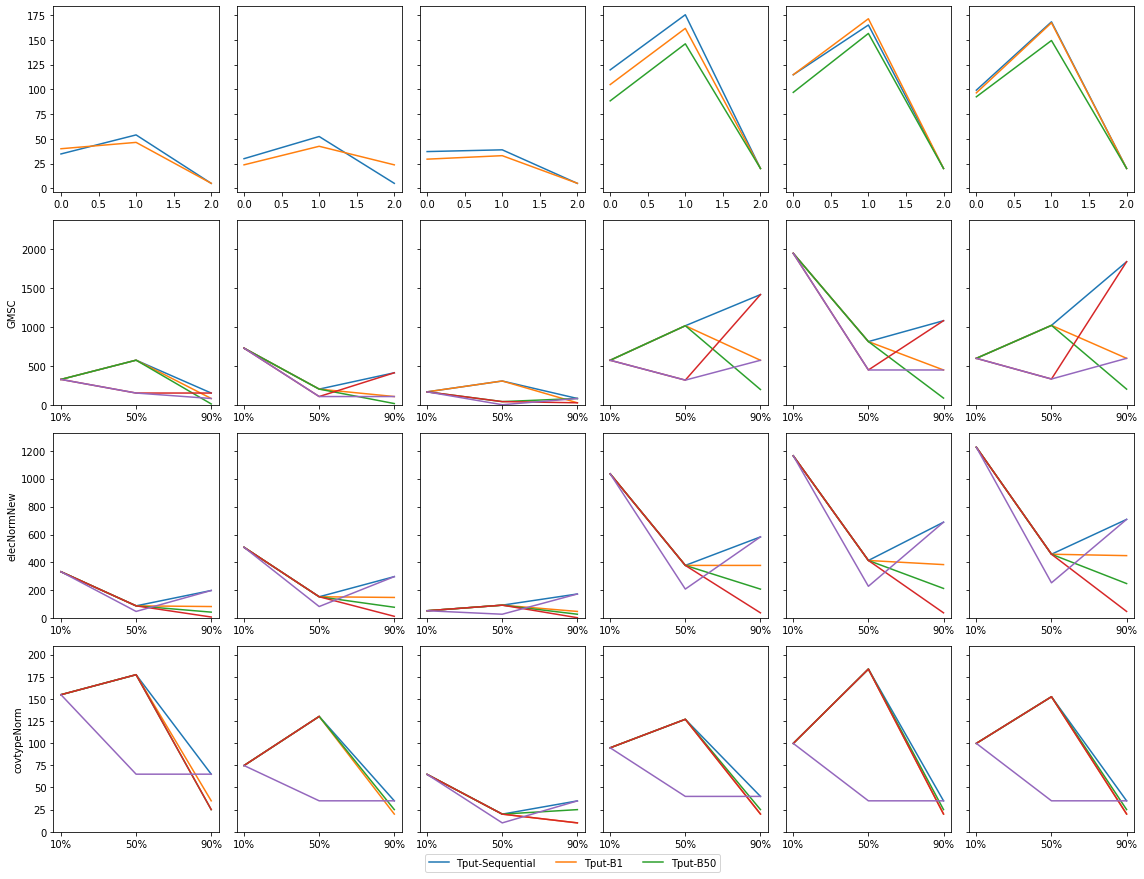

In [125]:
for freq,df in zip(freqs,dataframes):
    print(f'\n\n\n----------------- {freq} -----------------')
    show_tput(df, arch=freq.title())

In [ ]:
## Normalize Data Rasp Servidor Desicronizado

from datetime import datetime, timedelta

# Using readlines()
wm = open('Wm-800.log', 'r')
Lines = wm.readlines()

UltimaHoraOk = '2022/01/21 00:44:27' 
count = 0

current_line = Lines[0].split(',')
date_separated = current_line[0].split('/')
date = '20' + date_separated[2] + '/' + date_separated[1] + '/' + date_separated[0] + ' ' + current_line[1]

f = '%Y/%m/%d %H:%M:%S'
f2 = '%d/%m/%y,%H:%M:%S'

date_line = datetime.strptime(date, f)
dif = (datetime.strptime(UltimaHoraOk, f) - date_line).total_seconds()

new_date_line = date_line + timedelta(seconds=dif)

with open("Wm-800.log") as fp:
    while True:
        count += 1
        line = fp.readline()

        current_line_write = line.split(',')
 
        if not line:
            break
        
        if count == 1:
            continue

        new_date_line = new_date_line + timedelta(seconds=0.5)
        print(new_date_line.strftime(f2) + "," + current_line_write[2].replace("\n", ""))

d = {}
header_printed = False
moaDF = read_MOA(f"{PATH_TO_RESULTS}/Energy/vostro/socket", f"{PATH_TO_RESULTS}/Energy/vostro/inst-and-delay.csv")
moaDF = moaDF[["algorithm", "dataset", "cores", "batch_size", "inc_rate", "out_rate", "instances", "time", "delay"]]
measureDF = load_Wmeas(f'{PATH_TO_RESULTS}/Energy/vostro/Wm-vostro.log')
d = exper_order_to_dict(f'{PATH_TO_RESULTS}/Energy/vostro/exper_order-vostro.log', d)
d = populate_dict(d, measureDF)
mdf = append_dict_to_df(d)
sshDF = parse_SSH(f'{PATH_TO_RESULTS}/Energy/vostro/ssh-log-vostro')
sshDF['batch_size'] = sshDF['batch_size'].astype(int)

#join dfs
finaldf = moaDF.merge(mdf, on=['algorithm', 'dataset', 'cores', 'batch_size', 'inc_rate'])
finaldf = finaldf.merge(sshDF, 'left', on=['algorithm', 'dataset', 'batch_size', 'inc_rate'])
finaldf['joules'] = finaldf['avg_measure'] * finaldf['time']
finaldf['JPI'] = finaldf['joules'] / finaldf['instances']

### Add PERC column to identify if it used 90, 50 or 10% max rate

- Before merging rows with the same batch size, we need to differentiate the experiments with different work loads
- We use the **PERC**entage column for that

tdf = finaldf.sort_values(by=['dataset','algorithm','batch_size','inc_rate'], ascending=False)
tdf['PERC'] = 0
masks = {'90':[], '50': [], '10': []}
for k, v in zip(masks.keys(), [0, 1, 2]):
    for i in range(len(tdf)):
        masks[k].append(i % 3 == v)
tdf.loc[masks['90'],'PERC'] = '90'
tdf.loc[masks['50'],'PERC'] = '50'
tdf.loc[masks['10'],'PERC'] = '10'

Sharey = row

Linear scale

gen_graph(bars=True)

sharey = False

linear scale

gen_graph(bars=True, share_y=False)

sharey = false

log scale y

gen_graph(bars=True, share_y=False, log_y=True)

gen_graph(bars=True)

def table_delta_rates_vert(ratio=False):
    rates = ['10', '50', '90']
    algs = ['Ada', 'L', 'Patches', 'Adwin', 'ASHT', 'OzaBag']
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm','kyoto_binary']
    all_values = []
    # filtra algoritmo
    for alg in algs:
        line = '\hline\n\\multirow{3}{*}{' + alg + '} '
        algdf = filter_by_substring_algorithm(tdf, alg).sort_values(['algorithm','batch_size','cores'])
#         display(algdf)
        # filtra rate
        for rt in rates:
            if rt != '10':
                line += '\\\\\n'
            line += f' & {rt} '
            rtalgdf = rename_columns_by_rate(algdf[algdf.PERC == rt])
            # filtra dataset
            for ds in datasets:
#                 print(ds)
                dsrtalgdf = rtalgdf[rtalgdf.dataset == ds]
#                 display(dsrtalgdf)
                minoutro = min(dsrtalgdf[dsrtalgdf.batch_size == 1][f'JPI_{rt}'])
#                 print(f"JPI_{rt} minoutro {minoutro}")
                val = ((dsrtalgdf[dsrtalgdf.batch_size != 1][f'JPI_{rt}'].iloc[0] - minoutro)/minoutro)*100 if ratio else dsrtalgdf[dsrtalgdf.batch_size != 1][f'JPI_{rt}'].iloc[0] - minoutro 
                all_values.append(val)
                sval = f"{val:.2f} " if val < 0 else "\\textbf{ " + f"{val:.2f}" + "} "
                line += f"& {sval} "
        print(f"{line} \\\\")
    print(f'\n\nAverage reduction: {sum(all_values)/len(all_values)}')

table_delta_rates_vert()